# Clasificación de casos de estenosis coronaria usando Visual Transformers

### @Author Daniel Vallejo Aldana // Licenciatura en computación

#### Procesamiento de Imágenes biomédicas

In [1]:
import os
from transformers import ViTModel, ViTConfig, ViTForImageClassification
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import random_split,Dataset,DataLoader
from torch.optim import Adam
from time import time
from sklearn.metrics import classification_report, accuracy_score,f1_score
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import patchify
import cv2
from time import process_time 
import datetime

## Declaración de la clase que nos ayudará a cargar los datos de los archivos .pickle a tensores para clasificación

In [2]:
class EstenosisDS(Dataset):
    BS=16
    def __init__(self,pos_data,neg_data,ratios=(0.7,0.15,0.5),bs=16,handle_negatives=None,**kwargs):
        '''
        La clase se inicializa con los paths the los archivos pickle que debemos tener, el radio
        de separación de los conjuntos de prueba, validación y prueba
        handle_negatives tiene dos opciones
        balance <- deja el mismo número de ejemplos positivos y negativos
        None<-Deja el conjunto de datos tal cual está
        '''
        self.ratios=ratios
        self.labels=[]
        EstenosisDS.BS=bs
        file = open(pos_data, 'rb')
        positive_data = pickle.load(file)
        file.close()
        for i in range(positive_data.shape[0]):
            self.labels.append(np.array(1))
        file = open(neg_data, 'rb')
        negative_data = pickle.load(file)
        np.random.shuffle(negative_data)
        file.close()
        if handle_negatives is not None and type(handle_negatives)==int and handle_negatives<=10:
            negative_data=negative_data[:handle_negatives*positive_data.shape[0],:,:]
        for i in range(negative_data.shape[0]):
            self.labels.append(np.array(0))
        self.labels=np.asarray(self.labels)
        self.all=np.concatenate((positive_data,negative_data),axis=0)
        zero_dim=self.all.shape[0]
        if len(self.all.shape)<4:
            #No tiene un canal de entrada
            self.all=np.asarray([np.asarray(Image.fromarray(self.all[i]*255).convert('L')) for i in range(self.all.shape[0])])
            batch,d1,d2=self.all.shape
            self.all=self.all.reshape(batch,1,d1,d2)
        else:
            #Ya tiene un canal de entrada como en el de los datos artificiales
            batch,d1,d2,chanel=self.all.shape
            self.all=self.all.reshape(batch,chanel,d1,d2)*255
        ### Expansión con el conjunto de cifar 10 en blanco y negro
        '''
        De la literatura y de resultados experimentales se probó que Visual Transformers no converge rápidamente a conjuntos de datos con pocas clases, por lo tanto
        Necesitaremos enriquecer el conjunto de datos al menos en las primeras etapas
        '''
        if 'expand' in kwargs.keys():
             fo = open(kwargs['expand'], 'rb')
             datos = pickle.load(fo,encoding ='bytes')
             Imagenes=datos[b'data'].reshape(-1,32,32,3)
             Imagenes=np.asarray([np.asarray(Image.fromarray(Imagenes[i]).convert('L')) for i in range(Imagenes.shape[0])])
             etiquetas=datos[b'labels']
             Imagenes=Imagenes.reshape(-1,1,32,32)
             etiquetas=np.asarray(etiquetas)+2
             assert(self.all.shape[1:]==Imagenes.shape[1:])
             self.all=np.concatenate((self.all,Imagenes),axis=0)
             self.labels=np.concatenate((self.labels,etiquetas),axis=0)   
    def __len__(self):
        assert(self.all.shape[0]==self.labels.shape[0])
        return self.labels.shape[0]
    def __getitem__(self,index):
        return self.all[index],self.labels[index]
    def split_dataset(self):
        tr_ratio,val_ratio,test_ratio=self.ratios
        train_size = int(tr_ratio*self.__len__())
        val_size = int(val_ratio*self.__len__())
        test_size = int(test_ratio*self.__len__())
        train,test = random_split(self,[train_size,self.__len__()-train_size])
        test, val = random_split(test, [self.__len__()-train_size-val_size,val_size])
        test,_=random_split(test, [test_size,self.__len__()-train_size-val_size-test_size])
        return train,val,test
    def split_and_load(self):
        t,v,te=self.split_dataset()
        tdl,vdl,tedl=self.load_data(t,v,te)
        return tdl,vdl,tedl
    @staticmethod
    def load_data(ds1,ds2,ds3):
        train_dl=DataLoader(ds1,batch_size=EstenosisDS.BS,shuffle=True)
        val_dl=DataLoader(ds2,batch_size=EstenosisDS.BS,shuffle=False)
        test_dl=DataLoader(ds3,batch_size=EstenosisDS.BS,shuffle=False)
        return train_dl,val_dl,test_dl
    def load_single_set(ds):
        dataloader=DataLoader(ds,batch_size=EstenosisDS.BS,shuffle=False)

In [3]:
ds=EstenosisDS('125x32x32 positive.pickle','1394x32x32 negative.pickle',handle_negatives=1,bs=128)
train_ds,val_ds,test_ds=ds.split_dataset()

In [4]:
print("Numero de clases: {}".format(len(set(ds.labels))))

Numero de clases: 2


In [5]:
train_dl,val_dl,test_dl=ds.load_data(train_ds,val_ds,test_ds)

In [6]:
#Con esto ya tenemos todo listo para alimentar a la red neuronal
it=iter(train_dl)
x,y=next(it)
print(x.size(),y.size())

torch.Size([128, 1, 32, 32]) torch.Size([128])


In [7]:
#Necesitamos el dataset artificial para el Warmup de la red neuronal
artds=EstenosisDS('5000x32x32 positive.pickle','5000x32x32 negative.pickle',handle_negatives=1)

In [8]:
artds.all.shape #Los parches que vamos a usar para el calentamiento de la red neuronal

(10000, 1, 32, 32)

In [9]:
art_traindl,art_valdl,art_testdl=artds.split_and_load()

In [10]:
artit=iter(art_traindl)
x,y=next(it)
print(x.size(),y.size())

torch.Size([47, 1, 32, 32]) torch.Size([47])


# Definición del modelo de Visual Transformer para clasificación

In [7]:
class ViTEstDet(nn.Module):
    def __init__(self,classes=12,image_size=32,patch_size=16,channels=1,hidden_size=768, num_hidden_layers=12, num_attention_heads=12,attention_probs_dropout_prob=0.0):
        super(ViTEstDet,self).__init__()
        self.config=ViTConfig(num_labels=classes,image_size=image_size,patch_size=patch_size,hidden_size=hidden_size,num_channels=channels,attention_probs_dropout_prob=attention_probs_dropout_prob,num_hidden_layers=num_hidden_layers,num_attention_heads=num_attention_heads)
        self.vit = ViTForImageClassification(self.config)
        self.device="cuda:0" if next(self.parameters()).is_cuda else "cpu"
        
    def forward(self,pixel_values,output_attentions=False):
        '''
        input_fxt --> Feature extractor input
        '''
        if output_attentions:
            X = self.vit(pixel_values=pixel_values,output_attentions=True)
            x = X.pooler_output
        else:
            x = self.vit(pixel_values=pixel_values)[0]
        return x
    @torch.no_grad()
    def eval_model(self,dl):
        self.eval() #Ponemos el modelo en modo de evaluación
        flag=False
        if next(self.parameters()).is_cuda:
            flag=True
            self.cpu() #Y todo el modelo se manda a dispositivo cpu
        else:
            self.cpu()
        Y_real=[]
        Y_pred=[]
        for x,y in dl:
            y_pred=self.forward(x.float())
            y=y.numpy().tolist()
            y_pred=torch.argmax(y_pred,dim=1).numpy().tolist()
            Y_real=Y_real+y
            Y_pred=Y_pred+y_pred
        Y_real=np.array(Y_real)
        Y_pred=np.array(Y_pred)
        self.train() #Regresamos el modelo al módulo de entrenamiento
        if flag:
            self.cuda() #Y regresamos el modelo a GPU
        return Y_real,Y_pred
    @torch.no_grad()
    def predict(self,image):
        t1_start = process_time()
        was_training=self.training
        self.eval() #Ponemos el modelo en modo de evaluación
        imagen=cv2.imread(image,0)
        wi,he=imagen.shape
        imagen=imagen.reshape(1,wi,he)
        patches = patchify.patchify(imagen, (1, 32, 32), step=32)
        toUnpatch=patches.shape
        patches=patches.reshape(-1,1,32,32)
        TensorPatches=torch.FloatTensor(patches)
        Custom_batches=torch.split(TensorPatches, 16, dim=0)
        mask=[]
        maxs=[]
        for batch in Custom_batches:
            y_pred=self.forward(batch)
            preds=torch.argmax(y_pred,dim=1).numpy().tolist()
            maximos,_=torch.max(y_pred,dim=1)
            maximos=maximos.numpy().tolist()
            mask=mask+preds
            maxs=maxs+maximos
        mask=np.asarray(mask).reshape(toUnpatch[1],toUnpatch[2])
        maxs=np.asarray(maxs).reshape(toUnpatch[1],toUnpatch[2])
        mask=mask*(mask == 1.0)
        maxs=maxs*(mask == 1.0)
        t2_start = process_time() #Medir el tiempo de inferencia
        if was_training:
            self.train() #Regresamos a modo de entrenamiento si es que el modelo ya estaba en modo de entrenamiento
        return mask,maxs

In [12]:
#feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTEstDet(classes=2)

In [13]:
training=True
if training:
    assert(torch.cuda.is_available()==True)
device="cuda:0" if training else "cpu" #Inferencia se puede hacer con cpu sin problemas
if training:
    print("Dispositivo de entrenamiento: ",torch.cuda.get_device_name(0))

Dispositivo de entrenamiento:  NVIDIA GeForce RTX 2080 Ti


In [14]:
#Definción de hiperparametros como optimizadores y epocas
epochs=1300 #Es lo mismo que ponen en YOLO y en ViT
warmup_epochs=300
loss_f=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),momentum=0.8,lr=5e-4) #optimizadores adaptativos para datos dispersos
model=model.to(device)
current_train_dl=art_traindl
current_val_dl=art_valdl

In [15]:
#Ciclo de entrenamiento
improve=[]
if torch.cuda.is_available():
    torch.cuda.empty_cache()
best_f1=-float('inf')
best_loss=float('inf')
save_checkpoint=False
model_name=model.__class__.__name__+str(datetime.date.today())+".pt"
for epoch in tqdm(range(epochs)):
    avg_loss=0.0
    if epoch+1==warmup_epochs+1:
        print("[INFO] Cambiando a datos naturales...")
        #Hacemos el cambio a el conjunto de datos con angiogramas naturales
        current_train_dl=train_dl
        current_val_dl=val_dl
    for x,y in current_train_dl:
        optimizer.zero_grad()
        x=x.to(device)
        y=y.to(device)
        y_pred=model(x.float()) #Metemos la imagen para inferencia
        loss=loss_f(y_pred,y)
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()
    a,b=model.eval_model(current_val_dl)
    assert(model.training==True) #Checamos que el modelo se siga entrenando
    f1_validacion=classification_report(a,b)
    print("Done {}/{} Epochs with loss {} Memory Usage {} Gb".format(epoch+1,epochs,avg_loss/len(current_train_dl),round(torch.cuda.memory_allocated(0)/1e9,2)))
    print(f1_validacion)
    #Guardamos el mejor modelo de lo ya obtenido
    current_f1=round(f1_score(a,b,average='macro'),2)
    current_loss=round(avg_loss/len(train_dl),3)
    if current_f1>=best_f1 and avg_loss/len(train_dl) < 0.22:
        improve.append(current_f1)
        if current_loss<best_loss and current_f1==best_f1:
            if save_checkpoint:
                torch.save(model,model_name)
                print("Guardando modelo por mejora en el F1-score de {} a {}".format(best_f1,current_f1))
        elif current_f1>best_f1:
            if save_checkpoint:
                torch.save(model,model_name)
                print("Guardando modelo por mejora en el F1-score de {} a {}".format(best_f1,current_f1))
        best_f1=current_f1
if not save_checkpoint:
    torch.save(model,model_name) 

  0%|          | 0/1300 [00:00<?, ?it/s]/home/daniel.vallejo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/1300 [00:15<5:41:52, 15.79s/it]

Done 1/1300 Epochs with loss 0.7115672900252146 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  0%|          | 2/1300 [00:31<5:42:34, 15.84s/it]

Done 2/1300 Epochs with loss 0.7106585124992344 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  0%|          | 3/1300 [00:47<5:43:10, 15.88s/it]

Done 3/1300 Epochs with loss 0.7116323441403097 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  0%|          | 4/1300 [01:03<5:43:26, 15.90s/it]

Done 4/1300 Epochs with loss 0.7147382527725882 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  0%|          | 5/1300 [01:19<5:45:19, 16.00s/it]

Done 5/1300 Epochs with loss 0.7159567965220098 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  0%|          | 6/1300 [01:35<5:45:03, 16.00s/it]

Done 6/1300 Epochs with loss 0.7130460684702277 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  1%|          | 7/1300 [01:51<5:44:27, 15.98s/it]

Done 7/1300 Epochs with loss 0.709138797298414 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  1%|          | 8/1300 [02:07<5:43:36, 15.96s/it]

Done 8/1300 Epochs with loss 0.7119921820076633 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  1%|          | 9/1300 [02:23<5:43:34, 15.97s/it]

Done 9/1300 Epochs with loss 0.7125291925042732 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  1%|          | 10/1300 [02:39<5:43:10, 15.96s/it]

Done 10/1300 Epochs with loss 0.7124981014015468 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  1%|          | 11/1300 [02:55<5:42:37, 15.95s/it]

Done 11/1300 Epochs with loss 0.7126803882590168 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  1%|          | 12/1300 [03:11<5:42:28, 15.95s/it]

Done 12/1300 Epochs with loss 0.7061932855817281 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.78      0.01      0.02       783

    accuracy                           0.48      1500
   macro avg       0.63      0.50      0.33      1500
weighted avg       0.64      0.48      0.32      1500



  1%|          | 13/1300 [03:27<5:42:33, 15.97s/it]

Done 13/1300 Epochs with loss 0.7093078685949926 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  1%|          | 14/1300 [03:43<5:42:30, 15.98s/it]

Done 14/1300 Epochs with loss 0.7133340883200572 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  1%|          | 15/1300 [03:59<5:41:53, 15.96s/it]

Done 15/1300 Epochs with loss 0.7112854591243343 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  1%|          | 16/1300 [04:15<5:42:16, 15.99s/it]

Done 16/1300 Epochs with loss 0.712061263382707 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  1%|▏         | 17/1300 [04:31<5:42:21, 16.01s/it]

Done 17/1300 Epochs with loss 0.7138715002634753 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  1%|▏         | 18/1300 [04:47<5:41:53, 16.00s/it]

Done 18/1300 Epochs with loss 0.7109019165714038 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  1%|▏         | 19/1300 [05:03<5:41:38, 16.00s/it]

Done 19/1300 Epochs with loss 0.7091263320348035 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  2%|▏         | 20/1300 [05:19<5:41:33, 16.01s/it]

Done 20/1300 Epochs with loss 0.709769586722056 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.55      0.53       717
           1       0.55      0.50      0.53       783

    accuracy                           0.53      1500
   macro avg       0.53      0.53      0.53      1500
weighted avg       0.53      0.53      0.53      1500



  2%|▏         | 21/1300 [05:35<5:40:49, 15.99s/it]

Done 21/1300 Epochs with loss 0.7110944078665346 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  2%|▏         | 22/1300 [05:51<5:40:20, 15.98s/it]

Done 22/1300 Epochs with loss 0.7144405430854728 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  2%|▏         | 23/1300 [06:07<5:39:46, 15.96s/it]

Done 23/1300 Epochs with loss 0.7099294172574396 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      0.00      0.01       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.56      0.50      0.35      1500
weighted avg       0.56      0.52      0.36      1500



  2%|▏         | 24/1300 [06:23<5:39:34, 15.97s/it]

Done 24/1300 Epochs with loss 0.7086459542518337 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  2%|▏         | 25/1300 [06:39<5:39:27, 15.97s/it]

Done 25/1300 Epochs with loss 0.7103922324910011 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       1.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.74      0.50      0.32      1500
weighted avg       0.75      0.48      0.31      1500



  2%|▏         | 26/1300 [06:55<5:39:04, 15.97s/it]

Done 26/1300 Epochs with loss 0.7082683942089342 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  2%|▏         | 27/1300 [07:11<5:38:49, 15.97s/it]

Done 27/1300 Epochs with loss 0.7138220108535192 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.10      0.17       717
           1       0.53      0.93      0.67       783

    accuracy                           0.53      1500
   macro avg       0.54      0.51      0.42      1500
weighted avg       0.54      0.53      0.43      1500



  2%|▏         | 28/1300 [07:27<5:38:44, 15.98s/it]

Done 28/1300 Epochs with loss 0.7046609333116715 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  2%|▏         | 29/1300 [07:43<5:37:52, 15.95s/it]

Done 29/1300 Epochs with loss 0.7101431585610185 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  2%|▏         | 30/1300 [07:59<5:37:53, 15.96s/it]

Done 30/1300 Epochs with loss 0.7064378458887475 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      0.00      0.01       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.56      0.50      0.35      1500
weighted avg       0.56      0.52      0.36      1500



  2%|▏         | 31/1300 [08:15<5:38:04, 15.98s/it]

Done 31/1300 Epochs with loss 0.7135208846499387 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  2%|▏         | 32/1300 [08:31<5:38:47, 16.03s/it]

Done 32/1300 Epochs with loss 0.709362754266556 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.75      0.00      0.01       783

    accuracy                           0.48      1500
   macro avg       0.61      0.50      0.33      1500
weighted avg       0.62      0.48      0.31      1500



  3%|▎         | 33/1300 [08:47<5:37:53, 16.00s/it]

Done 33/1300 Epochs with loss 0.7132661271857345 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  3%|▎         | 34/1300 [09:03<5:37:43, 16.01s/it]

Done 34/1300 Epochs with loss 0.7137257264901514 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.76      0.50      0.34      1500
weighted avg       0.75      0.52      0.36      1500



  3%|▎         | 35/1300 [09:19<5:37:19, 16.00s/it]

Done 35/1300 Epochs with loss 0.7089558454681205 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.84      0.63       717
           1       0.62      0.25      0.35       783

    accuracy                           0.53      1500
   macro avg       0.56      0.54      0.49      1500
weighted avg       0.57      0.53      0.48      1500



  3%|▎         | 36/1300 [09:35<5:37:01, 16.00s/it]

Done 36/1300 Epochs with loss 0.7099935142961267 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  3%|▎         | 37/1300 [09:51<5:36:49, 16.00s/it]

Done 37/1300 Epochs with loss 0.7124781278578658 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.00      0.01       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.59      0.50      0.35      1500
weighted avg       0.59      0.52      0.36      1500



  3%|▎         | 38/1300 [10:07<5:37:41, 16.05s/it]

Done 38/1300 Epochs with loss 0.7091766858481925 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  3%|▎         | 39/1300 [10:23<5:37:26, 16.06s/it]

Done 39/1300 Epochs with loss 0.7101474736379162 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.10      0.17       717
           1       0.53      0.92      0.67       783

    accuracy                           0.53      1500
   macro avg       0.54      0.51      0.42      1500
weighted avg       0.53      0.53      0.43      1500



  3%|▎         | 40/1300 [10:39<5:36:34, 16.03s/it]

Done 40/1300 Epochs with loss 0.7076156656491702 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       1.00      0.00      0.01       783

    accuracy                           0.48      1500
   macro avg       0.74      0.50      0.33      1500
weighted avg       0.75      0.48      0.31      1500



  3%|▎         | 41/1300 [10:55<5:35:58, 16.01s/it]

Done 41/1300 Epochs with loss 0.7095921575750934 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       717
           1       0.55      0.63      0.59       783

    accuracy                           0.53      1500
   macro avg       0.53      0.53      0.53      1500
weighted avg       0.53      0.53      0.53      1500



  3%|▎         | 42/1300 [11:11<5:35:59, 16.03s/it]

Done 42/1300 Epochs with loss 0.7070480857265594 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  3%|▎         | 43/1300 [11:27<5:35:44, 16.03s/it]

Done 43/1300 Epochs with loss 0.7094069893501666 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  3%|▎         | 44/1300 [11:43<5:35:02, 16.01s/it]

Done 44/1300 Epochs with loss 0.7092353558703645 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  3%|▎         | 45/1300 [11:59<5:34:30, 15.99s/it]

Done 45/1300 Epochs with loss 0.7056722096656556 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  4%|▎         | 46/1300 [12:15<5:34:08, 15.99s/it]

Done 46/1300 Epochs with loss 0.7103227715786189 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  4%|▎         | 47/1300 [12:31<5:34:08, 16.00s/it]

Done 47/1300 Epochs with loss 0.7045612231781494 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  4%|▎         | 48/1300 [12:47<5:33:46, 16.00s/it]

Done 48/1300 Epochs with loss 0.7071901576159751 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.06      0.10       717
           1       0.53      0.96      0.68       783

    accuracy                           0.53      1500
   macro avg       0.53      0.51      0.39      1500
weighted avg       0.53      0.53      0.40      1500



  4%|▍         | 49/1300 [13:03<5:32:54, 15.97s/it]

Done 49/1300 Epochs with loss 0.7066752771808676 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.22      0.32       717
           1       0.54      0.82      0.65       783

    accuracy                           0.54      1500
   macro avg       0.54      0.52      0.48      1500
weighted avg       0.54      0.54      0.49      1500



  4%|▍         | 50/1300 [13:19<5:32:31, 15.96s/it]

Done 50/1300 Epochs with loss 0.7068324359856784 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  4%|▍         | 51/1300 [13:35<5:32:00, 15.95s/it]

Done 51/1300 Epochs with loss 0.709113942025459 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  4%|▍         | 52/1300 [13:51<5:31:11, 15.92s/it]

Done 52/1300 Epochs with loss 0.7062785263475218 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  4%|▍         | 53/1300 [14:07<5:31:05, 15.93s/it]

Done 53/1300 Epochs with loss 0.7070373846515673 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  4%|▍         | 54/1300 [14:23<5:31:26, 15.96s/it]

Done 54/1300 Epochs with loss 0.7093924327528096 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  4%|▍         | 55/1300 [14:39<5:31:27, 15.97s/it]

Done 55/1300 Epochs with loss 0.7065073768842166 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.02      0.05       717
           1       0.52      0.98      0.68       783

    accuracy                           0.52      1500
   macro avg       0.53      0.50      0.36      1500
weighted avg       0.53      0.52      0.38      1500



  4%|▍         | 56/1300 [14:55<5:30:46, 15.95s/it]

Done 56/1300 Epochs with loss 0.7071031487151368 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  4%|▍         | 57/1300 [15:11<5:31:01, 15.98s/it]

Done 57/1300 Epochs with loss 0.709766198510993 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  4%|▍         | 58/1300 [15:26<5:30:16, 15.95s/it]

Done 58/1300 Epochs with loss 0.7076965945360323 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  5%|▍         | 59/1300 [15:42<5:29:55, 15.95s/it]

Done 59/1300 Epochs with loss 0.7051131323864471 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.38      0.44       717
           1       0.54      0.68      0.61       783

    accuracy                           0.54      1500
   macro avg       0.53      0.53      0.52      1500
weighted avg       0.53      0.54      0.53      1500



  5%|▍         | 60/1300 [15:58<5:29:26, 15.94s/it]

Done 60/1300 Epochs with loss 0.7136181255453797 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  5%|▍         | 61/1300 [16:14<5:29:01, 15.93s/it]

Done 61/1300 Epochs with loss 0.7085749662085755 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  5%|▍         | 62/1300 [16:30<5:28:46, 15.93s/it]

Done 62/1300 Epochs with loss 0.7082543062837157 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  5%|▍         | 63/1300 [16:46<5:28:39, 15.94s/it]

Done 63/1300 Epochs with loss 0.7038848949893969 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  5%|▍         | 64/1300 [17:02<5:28:15, 15.93s/it]

Done 64/1300 Epochs with loss 0.7069213640744283 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  5%|▌         | 65/1300 [17:18<5:27:51, 15.93s/it]

Done 65/1300 Epochs with loss 0.7095868157469518 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  5%|▌         | 66/1300 [17:34<5:27:52, 15.94s/it]

Done 66/1300 Epochs with loss 0.7102881517584465 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.71      0.59       717
           1       0.59      0.37      0.45       783

    accuracy                           0.53      1500
   macro avg       0.55      0.54      0.52      1500
weighted avg       0.55      0.53      0.52      1500



  5%|▌         | 67/1300 [17:50<5:27:42, 15.95s/it]

Done 67/1300 Epochs with loss 0.7069484428183673 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  5%|▌         | 68/1300 [18:06<5:27:29, 15.95s/it]

Done 68/1300 Epochs with loss 0.7113953208270138 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  5%|▌         | 69/1300 [18:22<5:27:16, 15.95s/it]

Done 69/1300 Epochs with loss 0.712588924931609 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       1.00      0.00      0.01       783

    accuracy                           0.48      1500
   macro avg       0.74      0.50      0.33      1500
weighted avg       0.75      0.48      0.31      1500



  5%|▌         | 70/1300 [18:38<5:27:08, 15.96s/it]

Done 70/1300 Epochs with loss 0.7083973504909097 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       717
           1       0.56      0.58      0.57       783

    accuracy                           0.54      1500
   macro avg       0.54      0.54      0.54      1500
weighted avg       0.54      0.54      0.54      1500



  5%|▌         | 71/1300 [18:54<5:27:24, 15.98s/it]

Done 71/1300 Epochs with loss 0.7070123040240649 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  6%|▌         | 72/1300 [19:10<5:26:50, 15.97s/it]

Done 72/1300 Epochs with loss 0.712078735300395 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.16      0.24       717
           1       0.53      0.87      0.66       783

    accuracy                           0.53      1500
   macro avg       0.52      0.51      0.45      1500
weighted avg       0.53      0.53      0.46      1500



  6%|▌         | 73/1300 [19:26<5:26:35, 15.97s/it]

Done 73/1300 Epochs with loss 0.7047394478702109 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  6%|▌         | 74/1300 [19:42<5:25:30, 15.93s/it]

Done 74/1300 Epochs with loss 0.7071485948072721 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  6%|▌         | 75/1300 [19:57<5:24:51, 15.91s/it]

Done 75/1300 Epochs with loss 0.7119116951205414 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  6%|▌         | 76/1300 [20:13<5:24:20, 15.90s/it]

Done 76/1300 Epochs with loss 0.7079920213516444 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  6%|▌         | 77/1300 [20:29<5:24:25, 15.92s/it]

Done 77/1300 Epochs with loss 0.7085974100790068 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  6%|▌         | 78/1300 [20:45<5:24:18, 15.92s/it]

Done 78/1300 Epochs with loss 0.706048747039821 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  6%|▌         | 79/1300 [21:01<5:24:09, 15.93s/it]

Done 79/1300 Epochs with loss 0.7080005033103298 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  6%|▌         | 80/1300 [21:17<5:24:07, 15.94s/it]

Done 80/1300 Epochs with loss 0.7046862349390439 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  6%|▌         | 81/1300 [21:33<5:23:34, 15.93s/it]

Done 81/1300 Epochs with loss 0.712716341290844 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.91      0.64       717
           1       0.65      0.14      0.24       783

    accuracy                           0.51      1500
   macro avg       0.57      0.53      0.44      1500
weighted avg       0.57      0.51      0.43      1500



  6%|▋         | 82/1300 [21:49<5:23:34, 15.94s/it]

Done 82/1300 Epochs with loss 0.7072596370357357 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  6%|▋         | 83/1300 [22:05<5:23:25, 15.95s/it]

Done 83/1300 Epochs with loss 0.707141784772481 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.02      0.04       717
           1       0.52      0.98      0.68       783

    accuracy                           0.52      1500
   macro avg       0.55      0.50      0.36      1500
weighted avg       0.55      0.52      0.38      1500



  6%|▋         | 84/1300 [22:21<5:23:21, 15.96s/it]

Done 84/1300 Epochs with loss 0.7068310635819283 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.28      0.37       717
           1       0.54      0.77      0.64       783

    accuracy                           0.54      1500
   macro avg       0.54      0.53      0.50      1500
weighted avg       0.54      0.54      0.51      1500



  7%|▋         | 85/1300 [22:37<5:23:12, 15.96s/it]

Done 85/1300 Epochs with loss 0.7016742161419838 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  7%|▋         | 86/1300 [22:53<5:22:52, 15.96s/it]

Done 86/1300 Epochs with loss 0.709483098289738 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.76      0.61       717
           1       0.60      0.34      0.43       783

    accuracy                           0.54      1500
   macro avg       0.56      0.55      0.52      1500
weighted avg       0.56      0.54      0.52      1500



  7%|▋         | 87/1300 [23:09<5:22:29, 15.95s/it]

Done 87/1300 Epochs with loss 0.7127404143548992 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  7%|▋         | 88/1300 [23:25<5:22:06, 15.95s/it]

Done 88/1300 Epochs with loss 0.7063027606707185 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.65      0.58       717
           1       0.58      0.44      0.50       783

    accuracy                           0.54      1500
   macro avg       0.55      0.55      0.54      1500
weighted avg       0.55      0.54      0.54      1500



  7%|▋         | 89/1300 [23:41<5:21:44, 15.94s/it]

Done 89/1300 Epochs with loss 0.7140957152462442 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.20      0.29       717
           1       0.54      0.85      0.66       783

    accuracy                           0.54      1500
   macro avg       0.54      0.52      0.47      1500
weighted avg       0.54      0.54      0.48      1500



  7%|▋         | 90/1300 [23:57<5:21:25, 15.94s/it]

Done 90/1300 Epochs with loss 0.7064351473496929 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  7%|▋         | 91/1300 [24:12<5:20:55, 15.93s/it]

Done 91/1300 Epochs with loss 0.7112249982411458 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  7%|▋         | 92/1300 [24:28<5:20:44, 15.93s/it]

Done 92/1300 Epochs with loss 0.7064629337286841 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  7%|▋         | 93/1300 [24:44<5:20:48, 15.95s/it]

Done 93/1300 Epochs with loss 0.7114065577994743 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.94      0.65       717
           1       0.67      0.11      0.19       783

    accuracy                           0.51      1500
   macro avg       0.58      0.53      0.42      1500
weighted avg       0.58      0.51      0.41      1500



  7%|▋         | 94/1300 [25:00<5:20:58, 15.97s/it]

Done 94/1300 Epochs with loss 0.7046456984733338 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  7%|▋         | 95/1300 [25:16<5:20:45, 15.97s/it]

Done 95/1300 Epochs with loss 0.7090892137185624 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.36      1500



  7%|▋         | 96/1300 [25:32<5:20:28, 15.97s/it]

Done 96/1300 Epochs with loss 0.7032207506432381 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  7%|▋         | 97/1300 [25:48<5:19:54, 15.96s/it]

Done 97/1300 Epochs with loss 0.7015962388417493 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.99      0.65       717
           1       0.68      0.02      0.04       783

    accuracy                           0.48      1500
   macro avg       0.58      0.51      0.34      1500
weighted avg       0.58      0.48      0.33      1500



  8%|▊         | 98/1300 [26:04<5:19:23, 15.94s/it]

Done 98/1300 Epochs with loss 0.7092540402934976 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.78      0.61       717
           1       0.60      0.30      0.40       783

    accuracy                           0.53      1500
   macro avg       0.55      0.54      0.51      1500
weighted avg       0.56      0.53      0.50      1500



  8%|▊         | 99/1300 [26:20<5:19:08, 15.94s/it]

Done 99/1300 Epochs with loss 0.7037726119500861 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.80      0.62       717
           1       0.61      0.29      0.39       783

    accuracy                           0.53      1500
   macro avg       0.56      0.55      0.51      1500
weighted avg       0.56      0.53      0.50      1500



  8%|▊         | 100/1300 [26:36<5:18:49, 15.94s/it]

Done 100/1300 Epochs with loss 0.7105384244494242 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.28      0.37       717
           1       0.54      0.79      0.64       783

    accuracy                           0.54      1500
   macro avg       0.55      0.53      0.51      1500
weighted avg       0.55      0.54      0.51      1500



  8%|▊         | 101/1300 [26:52<5:18:46, 15.95s/it]

Done 101/1300 Epochs with loss 0.7022819838839579 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  8%|▊         | 102/1300 [27:08<5:18:12, 15.94s/it]

Done 102/1300 Epochs with loss 0.7030573873759405 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  8%|▊         | 103/1300 [27:24<5:18:06, 15.95s/it]

Done 103/1300 Epochs with loss 0.7021684766360069 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.81      0.62       717
           1       0.60      0.26      0.37       783

    accuracy                           0.53      1500
   macro avg       0.55      0.54      0.49      1500
weighted avg       0.56      0.53      0.49      1500



  8%|▊         | 104/1300 [27:40<5:18:21, 15.97s/it]

Done 104/1300 Epochs with loss 0.7031571357489721 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.93      0.64       717
           1       0.63      0.11      0.19       783

    accuracy                           0.50      1500
   macro avg       0.56      0.52      0.41      1500
weighted avg       0.56      0.50      0.40      1500



  8%|▊         | 105/1300 [27:56<5:17:54, 15.96s/it]

Done 105/1300 Epochs with loss 0.6998896615826375 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.05      0.09       717
           1       0.53      0.98      0.69       783

    accuracy                           0.53      1500
   macro avg       0.62      0.51      0.39      1500
weighted avg       0.61      0.53      0.40      1500



  8%|▊         | 106/1300 [28:12<5:17:41, 15.96s/it]

Done 106/1300 Epochs with loss 0.701294949746023 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.66      0.59       717
           1       0.60      0.46      0.52       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.55      1500
weighted avg       0.56      0.56      0.55      1500



  8%|▊         | 107/1300 [28:28<5:17:15, 15.96s/it]

Done 107/1300 Epochs with loss 0.706435287788034 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      0.10      0.17       717
           1       0.53      0.94      0.68       783

    accuracy                           0.53      1500
   macro avg       0.56      0.52      0.42      1500
weighted avg       0.55      0.53      0.43      1500



  8%|▊         | 108/1300 [28:44<5:17:07, 15.96s/it]

Done 108/1300 Epochs with loss 0.7039053124379894 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



  8%|▊         | 109/1300 [29:00<5:16:49, 15.96s/it]

Done 109/1300 Epochs with loss 0.7021966115252612 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.40      0.46       717
           1       0.56      0.69      0.62       783

    accuracy                           0.55      1500
   macro avg       0.55      0.55      0.54      1500
weighted avg       0.55      0.55      0.54      1500



  8%|▊         | 110/1300 [29:16<5:16:14, 15.95s/it]

Done 110/1300 Epochs with loss 0.699521426604763 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.78      0.62       717
           1       0.61      0.32      0.42       783

    accuracy                           0.54      1500
   macro avg       0.56      0.55      0.52      1500
weighted avg       0.56      0.54      0.52      1500



  9%|▊         | 111/1300 [29:32<5:16:05, 15.95s/it]

Done 111/1300 Epochs with loss 0.6972905264053171 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       717
           1       0.60      0.52      0.56       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



  9%|▊         | 112/1300 [29:48<5:15:57, 15.96s/it]

Done 112/1300 Epochs with loss 0.6993924443308077 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.80      0.62       717
           1       0.62      0.30      0.40       783

    accuracy                           0.54      1500
   macro avg       0.56      0.55      0.51      1500
weighted avg       0.56      0.54      0.51      1500



  9%|▊         | 113/1300 [30:04<5:15:46, 15.96s/it]

Done 113/1300 Epochs with loss 0.6976640180910014 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.72      0.60       717
           1       0.60      0.39      0.47       783

    accuracy                           0.55      1500
   macro avg       0.56      0.56      0.54      1500
weighted avg       0.56      0.55      0.54      1500



  9%|▉         | 114/1300 [30:20<5:15:37, 15.97s/it]

Done 114/1300 Epochs with loss 0.6982196599381155 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.30      0.39       717
           1       0.55      0.77      0.64       783

    accuracy                           0.55      1500
   macro avg       0.55      0.54      0.51      1500
weighted avg       0.55      0.55      0.52      1500



  9%|▉         | 115/1300 [30:36<5:15:31, 15.98s/it]

Done 115/1300 Epochs with loss 0.70084481438001 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.15      0.24       717
           1       0.54      0.90      0.67       783

    accuracy                           0.54      1500
   macro avg       0.55      0.52      0.45      1500
weighted avg       0.55      0.54      0.46      1500



  9%|▉         | 116/1300 [30:51<5:15:06, 15.97s/it]

Done 116/1300 Epochs with loss 0.7106998424007468 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.74      0.61       717
           1       0.61      0.38      0.47       783

    accuracy                           0.55      1500
   macro avg       0.56      0.56      0.54      1500
weighted avg       0.57      0.55      0.53      1500



  9%|▉         | 117/1300 [31:07<5:14:30, 15.95s/it]

Done 117/1300 Epochs with loss 0.6995698492548782 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.04      0.07       717
           1       0.53      0.98      0.69       783

    accuracy                           0.53      1500
   macro avg       0.61      0.51      0.38      1500
weighted avg       0.61      0.53      0.39      1500



  9%|▉         | 118/1300 [31:23<5:14:28, 15.96s/it]

Done 118/1300 Epochs with loss 0.6962440462961589 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.99      0.65       717
           1       0.58      0.01      0.02       783

    accuracy                           0.48      1500
   macro avg       0.53      0.50      0.33      1500
weighted avg       0.53      0.48      0.32      1500



  9%|▉         | 119/1300 [31:39<5:14:03, 15.96s/it]

Done 119/1300 Epochs with loss 0.6997418485956105 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.03      0.07       717
           1       0.53      0.98      0.68       783

    accuracy                           0.53      1500
   macro avg       0.57      0.51      0.38      1500
weighted avg       0.57      0.53      0.39      1500



  9%|▉         | 120/1300 [31:55<5:13:57, 15.96s/it]

Done 120/1300 Epochs with loss 0.7015666158776305 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.39      0.46       717
           1       0.56      0.72      0.63       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.54      1500
weighted avg       0.56      0.56      0.55      1500



  9%|▉         | 121/1300 [32:11<5:13:44, 15.97s/it]

Done 121/1300 Epochs with loss 0.698989648525029 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.79      0.62       717
           1       0.61      0.30      0.40       783

    accuracy                           0.54      1500
   macro avg       0.56      0.55      0.51      1500
weighted avg       0.56      0.54      0.51      1500



  9%|▉         | 122/1300 [32:27<5:13:21, 15.96s/it]

Done 122/1300 Epochs with loss 0.7002413423910533 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.02      0.03       717
           1       0.52      0.99      0.69       783

    accuracy                           0.52      1500
   macro avg       0.57      0.50      0.36      1500
weighted avg       0.57      0.52      0.37      1500



  9%|▉         | 123/1300 [32:43<5:12:53, 15.95s/it]

Done 123/1300 Epochs with loss 0.7004504150723758 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.57      0.57       717
           1       0.60      0.59      0.60       783

    accuracy                           0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.58      0.58      0.58      1500



 10%|▉         | 124/1300 [32:59<5:13:03, 15.97s/it]

Done 124/1300 Epochs with loss 0.7035421787603805 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.07      0.13       717
           1       0.53      0.97      0.69       783

    accuracy                           0.54      1500
   macro avg       0.62      0.52      0.41      1500
weighted avg       0.62      0.54      0.42      1500



 10%|▉         | 125/1300 [33:15<5:13:03, 15.99s/it]

Done 125/1300 Epochs with loss 0.7012188013421891 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.08      0.15       717
           1       0.53      0.96      0.68       783

    accuracy                           0.54      1500
   macro avg       0.59      0.52      0.42      1500
weighted avg       0.58      0.54      0.43      1500



 10%|▉         | 126/1300 [33:31<5:12:38, 15.98s/it]

Done 126/1300 Epochs with loss 0.6967413809201489 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.35      0.43       717
           1       0.55      0.74      0.63       783

    accuracy                           0.55      1500
   macro avg       0.55      0.54      0.53      1500
weighted avg       0.55      0.55      0.53      1500



 10%|▉         | 127/1300 [33:47<5:12:28, 15.98s/it]

Done 127/1300 Epochs with loss 0.699349487889303 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.04      0.08       717
           1       0.53      0.98      0.69       783

    accuracy                           0.53      1500
   macro avg       0.60      0.51      0.39      1500
weighted avg       0.59      0.53      0.40      1500



 10%|▉         | 128/1300 [34:03<5:12:01, 15.97s/it]

Done 128/1300 Epochs with loss 0.6981316370778976 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.42      0.48       717
           1       0.57      0.69      0.62       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.55      1500
weighted avg       0.56      0.56      0.55      1500



 10%|▉         | 129/1300 [34:19<5:11:48, 15.98s/it]

Done 129/1300 Epochs with loss 0.6988397926500399 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.69      0.59       717
           1       0.59      0.41      0.48       783

    accuracy                           0.54      1500
   macro avg       0.55      0.55      0.54      1500
weighted avg       0.55      0.54      0.53      1500



 10%|█         | 130/1300 [34:35<5:11:59, 16.00s/it]

Done 130/1300 Epochs with loss 0.696855236270112 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.88      0.63       717
           1       0.62      0.18      0.28       783

    accuracy                           0.51      1500
   macro avg       0.56      0.53      0.46      1500
weighted avg       0.56      0.51      0.45      1500



 10%|█         | 131/1300 [34:51<5:11:25, 15.98s/it]

Done 131/1300 Epochs with loss 0.7024442247331959 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.90      0.64       717
           1       0.62      0.14      0.23       783

    accuracy                           0.51      1500
   macro avg       0.55      0.52      0.43      1500
weighted avg       0.56      0.51      0.42      1500



 10%|█         | 132/1300 [35:07<5:11:02, 15.98s/it]

Done 132/1300 Epochs with loss 0.7041611408806283 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.03      0.06       717
           1       0.53      0.98      0.69       783

    accuracy                           0.53      1500
   macro avg       0.60      0.51      0.37      1500
weighted avg       0.59      0.53      0.39      1500



 10%|█         | 133/1300 [35:23<5:11:00, 15.99s/it]

Done 133/1300 Epochs with loss 0.697415518978415 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.55      0.56       717
           1       0.60      0.61      0.60       783

    accuracy                           0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.58      0.58      0.58      1500



 10%|█         | 134/1300 [35:39<5:10:19, 15.97s/it]

Done 134/1300 Epochs with loss 0.6929964379632854 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.57      0.56       717
           1       0.60      0.58      0.59       783

    accuracy                           0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.58      0.58      0.58      1500



 10%|█         | 135/1300 [35:55<5:10:20, 15.98s/it]

Done 135/1300 Epochs with loss 0.6954400177415647 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.98      0.64       717
           1       0.59      0.02      0.04       783

    accuracy                           0.48      1500
   macro avg       0.54      0.50      0.34      1500
weighted avg       0.54      0.48      0.33      1500



 10%|█         | 136/1300 [36:11<5:10:15, 15.99s/it]

Done 136/1300 Epochs with loss 0.6976828036242968 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      0.15      0.24       717
           1       0.54      0.90      0.67       783

    accuracy                           0.54      1500
   macro avg       0.56      0.53      0.46      1500
weighted avg       0.56      0.54      0.46      1500



 11%|█         | 137/1300 [36:27<5:09:57, 15.99s/it]

Done 137/1300 Epochs with loss 0.6968202024834341 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       717
           1       0.57      0.68      0.62       783

    accuracy                           0.57      1500
   macro avg       0.57      0.56      0.56      1500
weighted avg       0.57      0.57      0.56      1500



 11%|█         | 138/1300 [36:43<5:09:24, 15.98s/it]

Done 138/1300 Epochs with loss 0.6981898964676139 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.42      0.48       717
           1       0.57      0.70      0.63       783

    accuracy                           0.57      1500
   macro avg       0.57      0.56      0.55      1500
weighted avg       0.57      0.57      0.56      1500



 11%|█         | 139/1300 [36:59<5:09:10, 15.98s/it]

Done 139/1300 Epochs with loss 0.6978821735403854 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



 11%|█         | 140/1300 [37:15<5:09:00, 15.98s/it]

Done 140/1300 Epochs with loss 0.6965485586695475 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       717
           1       0.57      0.67      0.62       783

    accuracy                           0.57      1500
   macro avg       0.57      0.56      0.56      1500
weighted avg       0.57      0.57      0.56      1500



 11%|█         | 141/1300 [37:31<5:08:36, 15.98s/it]

Done 141/1300 Epochs with loss 0.6994924157449643 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.98      0.64       717
           1       0.57      0.03      0.05       783

    accuracy                           0.48      1500
   macro avg       0.53      0.50      0.35      1500
weighted avg       0.53      0.48      0.33      1500



 11%|█         | 142/1300 [37:47<5:08:32, 15.99s/it]

Done 142/1300 Epochs with loss 0.6958440349662685 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.92      0.64       717
           1       0.63      0.12      0.20       783

    accuracy                           0.50      1500
   macro avg       0.56      0.52      0.42      1500
weighted avg       0.56      0.50      0.41      1500



 11%|█         | 143/1300 [38:03<5:08:12, 15.98s/it]

Done 143/1300 Epochs with loss 0.6976775505227041 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.64      0.58       717
           1       0.59      0.48      0.53       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.56      0.55      1500



 11%|█         | 144/1300 [38:19<5:08:07, 15.99s/it]

Done 144/1300 Epochs with loss 0.6957835841532711 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.97      0.64       717
           1       0.62      0.05      0.09       783

    accuracy                           0.49      1500
   macro avg       0.55      0.51      0.37      1500
weighted avg       0.55      0.49      0.36      1500



 11%|█         | 145/1300 [38:35<5:07:56, 16.00s/it]

Done 145/1300 Epochs with loss 0.6964375527754222 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.83      0.63       717
           1       0.62      0.26      0.36       783

    accuracy                           0.53      1500
   macro avg       0.56      0.54      0.49      1500
weighted avg       0.56      0.53      0.49      1500



 11%|█         | 146/1300 [38:51<5:07:42, 16.00s/it]

Done 146/1300 Epochs with loss 0.6954184294291282 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.88      0.63       717
           1       0.61      0.17      0.27       783

    accuracy                           0.51      1500
   macro avg       0.55      0.52      0.45      1500
weighted avg       0.55      0.51      0.44      1500



 11%|█▏        | 147/1300 [39:07<5:07:13, 15.99s/it]

Done 147/1300 Epochs with loss 0.6943080706955636 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.90      0.64       717
           1       0.63      0.16      0.26       783

    accuracy                           0.51      1500
   macro avg       0.56      0.53      0.45      1500
weighted avg       0.56      0.51      0.44      1500



 11%|█▏        | 148/1300 [39:23<5:07:07, 16.00s/it]

Done 148/1300 Epochs with loss 0.6924320626748751 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       717
           1       0.63      0.19      0.29       783

    accuracy                           0.52      1500
   macro avg       0.56      0.53      0.46      1500
weighted avg       0.57      0.52      0.45      1500



 11%|█▏        | 149/1300 [39:39<5:06:33, 15.98s/it]

Done 149/1300 Epochs with loss 0.6963143269765323 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       717
           1       0.60      0.48      0.54       783

    accuracy                           0.56      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.57      0.56      0.56      1500



 12%|█▏        | 150/1300 [39:55<5:06:16, 15.98s/it]

Done 150/1300 Epochs with loss 0.6934984372631056 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.57      0.57       717
           1       0.60      0.59      0.60       783

    accuracy                           0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.59      0.58      0.58      1500



 12%|█▏        | 151/1300 [40:11<5:05:25, 15.95s/it]

Done 151/1300 Epochs with loss 0.6991365635640001 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.89      0.64       717
           1       0.63      0.17      0.27       783

    accuracy                           0.51      1500
   macro avg       0.56      0.53      0.45      1500
weighted avg       0.57      0.51      0.44      1500



 12%|█▏        | 152/1300 [40:27<5:05:07, 15.95s/it]

Done 152/1300 Epochs with loss 0.6894768249226487 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.49      0.52       717
           1       0.58      0.66      0.62       783

    accuracy                           0.58      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.58      0.57      1500



 12%|█▏        | 153/1300 [40:43<5:04:56, 15.95s/it]

Done 153/1300 Epochs with loss 0.6994802332632074 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.77      0.61       717
           1       0.60      0.33      0.42       783

    accuracy                           0.54      1500
   macro avg       0.56      0.55      0.52      1500
weighted avg       0.56      0.54      0.51      1500



 12%|█▏        | 154/1300 [40:58<5:04:24, 15.94s/it]

Done 154/1300 Epochs with loss 0.6969387996686648 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.91      0.64       717
           1       0.61      0.12      0.20       783

    accuracy                           0.50      1500
   macro avg       0.55      0.52      0.42      1500
weighted avg       0.55      0.50      0.41      1500



 12%|█▏        | 155/1300 [41:14<5:04:33, 15.96s/it]

Done 155/1300 Epochs with loss 0.6940166961112523 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.43      0.49       717
           1       0.57      0.69      0.62       783

    accuracy                           0.57      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.57      0.56      1500



 12%|█▏        | 156/1300 [41:30<5:04:30, 15.97s/it]

Done 156/1300 Epochs with loss 0.701041793442208 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.65      0.58       717
           1       0.60      0.47      0.52       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.55      1500
weighted avg       0.56      0.56      0.55      1500



 12%|█▏        | 157/1300 [41:46<5:03:58, 15.96s/it]

Done 157/1300 Epochs with loss 0.6916071656904265 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.61      0.58       717
           1       0.60      0.53      0.56       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 12%|█▏        | 158/1300 [42:02<5:03:34, 15.95s/it]

Done 158/1300 Epochs with loss 0.6987029584847628 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.99      0.65       717
           1       0.55      0.01      0.02       783

    accuracy                           0.48      1500
   macro avg       0.51      0.50      0.33      1500
weighted avg       0.51      0.48      0.32      1500



 12%|█▏        | 159/1300 [42:18<5:03:07, 15.94s/it]

Done 159/1300 Epochs with loss 0.6970536228456453 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.36      0.44       717
           1       0.56      0.74      0.64       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.54      1500
weighted avg       0.56      0.56      0.54      1500



 12%|█▏        | 160/1300 [42:34<5:02:33, 15.92s/it]

Done 160/1300 Epochs with loss 0.693010129953084 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



 12%|█▏        | 161/1300 [42:50<5:02:38, 15.94s/it]

Done 161/1300 Epochs with loss 0.697807540224023 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.41      0.47       717
           1       0.56      0.71      0.63       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.55      1500
weighted avg       0.56      0.56      0.55      1500



 12%|█▏        | 162/1300 [43:06<5:03:09, 15.98s/it]

Done 162/1300 Epochs with loss 0.6917006863306646 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.79      0.62       717
           1       0.62      0.31      0.41       783

    accuracy                           0.54      1500
   macro avg       0.56      0.55      0.52      1500
weighted avg       0.57      0.54      0.51      1500



 13%|█▎        | 163/1300 [43:22<5:02:26, 15.96s/it]

Done 163/1300 Epochs with loss 0.697532848408233 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.07      0.13       717
           1       0.53      0.97      0.69       783

    accuracy                           0.54      1500
   macro avg       0.60      0.52      0.41      1500
weighted avg       0.60      0.54      0.42      1500



 13%|█▎        | 164/1300 [43:38<5:02:15, 15.96s/it]

Done 164/1300 Epochs with loss 0.6940635430486235 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.48      0.52       717
           1       0.58      0.66      0.62       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 13%|█▎        | 165/1300 [43:54<5:02:02, 15.97s/it]

Done 165/1300 Epochs with loss 0.6915983706032305 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.10      0.18       717
           1       0.54      0.95      0.68       783

    accuracy                           0.54      1500
   macro avg       0.59      0.53      0.43      1500
weighted avg       0.59      0.54      0.44      1500



 13%|█▎        | 166/1300 [44:10<5:02:24, 16.00s/it]

Done 166/1300 Epochs with loss 0.6904302549688783 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.77      0.61       717
           1       0.61      0.32      0.42       783

    accuracy                           0.54      1500
   macro avg       0.56      0.55      0.52      1500
weighted avg       0.56      0.54      0.51      1500



 13%|█▎        | 167/1300 [44:26<5:01:40, 15.98s/it]

Done 167/1300 Epochs with loss 0.6965061386698457 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      0.05      0.09       717
           1       0.53      0.98      0.69       783

    accuracy                           0.53      1500
   macro avg       0.59      0.51      0.39      1500
weighted avg       0.59      0.53      0.40      1500



 13%|█▎        | 168/1300 [44:42<5:01:36, 15.99s/it]

Done 168/1300 Epochs with loss 0.6942369654842707 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.96      0.64       717
           1       0.62      0.06      0.11       783

    accuracy                           0.49      1500
   macro avg       0.55      0.51      0.37      1500
weighted avg       0.55      0.49      0.36      1500



 13%|█▎        | 169/1300 [44:58<5:01:08, 15.98s/it]

Done 169/1300 Epochs with loss 0.6977294127554654 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.40      0.46       717
           1       0.56      0.70      0.62       783

    accuracy                           0.56      1500
   macro avg       0.55      0.55      0.54      1500
weighted avg       0.55      0.56      0.54      1500



 13%|█▎        | 170/1300 [45:14<5:00:16, 15.94s/it]

Done 170/1300 Epochs with loss 0.6939794476990286 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.83      0.63       717
           1       0.62      0.26      0.37       783

    accuracy                           0.53      1500
   macro avg       0.56      0.54      0.50      1500
weighted avg       0.57      0.53      0.49      1500



 13%|█▎        | 171/1300 [45:30<5:00:15, 15.96s/it]

Done 171/1300 Epochs with loss 0.6954476079440008 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.37      0.44       717
           1       0.56      0.74      0.64       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.54      1500
weighted avg       0.56      0.56      0.55      1500



 13%|█▎        | 172/1300 [45:46<4:59:57, 15.95s/it]

Done 172/1300 Epochs with loss 0.6954745674786502 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.34      0.42       717
           1       0.56      0.75      0.64       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.53      1500
weighted avg       0.56      0.56      0.54      1500



 13%|█▎        | 173/1300 [46:02<4:59:34, 15.95s/it]

Done 173/1300 Epochs with loss 0.6866161271453448 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.79      0.62       717
           1       0.62      0.32      0.42       783

    accuracy                           0.54      1500
   macro avg       0.57      0.55      0.52      1500
weighted avg       0.57      0.54      0.52      1500



 13%|█▎        | 174/1300 [46:18<4:59:19, 15.95s/it]

Done 174/1300 Epochs with loss 0.6925821908532757 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.80      0.62       717
           1       0.62      0.30      0.40       783

    accuracy                           0.54      1500
   macro avg       0.57      0.55      0.51      1500
weighted avg       0.57      0.54      0.51      1500



 13%|█▎        | 175/1300 [46:34<4:58:58, 15.95s/it]

Done 175/1300 Epochs with loss 0.6905943786716897 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.42      0.48       717
           1       0.57      0.69      0.62       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.55      1500
weighted avg       0.56      0.56      0.56      1500



 14%|█▎        | 176/1300 [46:50<4:59:11, 15.97s/it]

Done 176/1300 Epochs with loss 0.6958240429832511 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.79      0.62       717
           1       0.62      0.32      0.42       783

    accuracy                           0.54      1500
   macro avg       0.57      0.55      0.52      1500
weighted avg       0.57      0.54      0.52      1500



 14%|█▎        | 177/1300 [47:06<4:59:12, 15.99s/it]

Done 177/1300 Epochs with loss 0.6926252354769946 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.66      0.59       717
           1       0.61      0.48      0.54       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.58      0.57      0.57      1500



 14%|█▎        | 178/1300 [47:22<4:58:35, 15.97s/it]

Done 178/1300 Epochs with loss 0.6914885033211208 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.01      0.02       717
           1       0.52      0.99      0.69       783

    accuracy                           0.52      1500
   macro avg       0.60      0.50      0.35      1500
weighted avg       0.59      0.52      0.37      1500



 14%|█▍        | 179/1300 [47:38<4:58:34, 15.98s/it]

Done 179/1300 Epochs with loss 0.6955154558567151 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.05      0.10       717
           1       0.53      0.97      0.68       783

    accuracy                           0.53      1500
   macro avg       0.57      0.51      0.39      1500
weighted avg       0.57      0.53      0.40      1500



 14%|█▍        | 180/1300 [47:54<4:58:16, 15.98s/it]

Done 180/1300 Epochs with loss 0.6909298183711152 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.64      0.58       717
           1       0.60      0.49      0.54       783

    accuracy                           0.56      1500
   macro avg       0.57      0.56      0.56      1500
weighted avg       0.57      0.56      0.56      1500



 14%|█▍        | 181/1300 [48:10<4:58:01, 15.98s/it]

Done 181/1300 Epochs with loss 0.6896693526201596 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.75      0.62       717
           1       0.62      0.38      0.47       783

    accuracy                           0.55      1500
   macro avg       0.57      0.56      0.54      1500
weighted avg       0.57      0.55      0.54      1500



 14%|█▍        | 182/1300 [48:26<4:57:47, 15.98s/it]

Done 182/1300 Epochs with loss 0.6928848273133579 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.48      0.52       717
           1       0.58      0.66      0.62       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 14%|█▍        | 183/1300 [48:42<4:57:18, 15.97s/it]

Done 183/1300 Epochs with loss 0.6908472912496628 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.30      0.39       717
           1       0.55      0.78      0.64       783

    accuracy                           0.55      1500
   macro avg       0.55      0.54      0.52      1500
weighted avg       0.55      0.55      0.52      1500



 14%|█▍        | 184/1300 [48:57<4:56:59, 15.97s/it]

Done 184/1300 Epochs with loss 0.69039455335162 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.92      0.64       717
           1       0.64      0.12      0.21       783

    accuracy                           0.51      1500
   macro avg       0.57      0.52      0.42      1500
weighted avg       0.57      0.51      0.41      1500



 14%|█▍        | 185/1300 [49:14<4:58:19, 16.05s/it]

Done 185/1300 Epochs with loss 0.6907442199857268 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.78      0.62       717
           1       0.62      0.33      0.43       783

    accuracy                           0.55      1500
   macro avg       0.57      0.56      0.53      1500
weighted avg       0.57      0.55      0.52      1500



 14%|█▍        | 186/1300 [49:30<4:57:14, 16.01s/it]

Done 186/1300 Epochs with loss 0.6908197971783816 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.30      0.39       717
           1       0.55      0.79      0.65       783

    accuracy                           0.56      1500
   macro avg       0.56      0.54      0.52      1500
weighted avg       0.56      0.56      0.53      1500



 14%|█▍        | 187/1300 [49:46<4:56:59, 16.01s/it]

Done 187/1300 Epochs with loss 0.6906792760983994 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       717
           1       0.57      0.67      0.62       783

    accuracy                           0.57      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.57      0.57      0.56      1500



 14%|█▍        | 188/1300 [50:02<4:56:37, 16.00s/it]

Done 188/1300 Epochs with loss 0.6940278302725047 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.68      0.59       717
           1       0.60      0.43      0.50       783

    accuracy                           0.55      1500
   macro avg       0.56      0.56      0.55      1500
weighted avg       0.56      0.55      0.55      1500



 15%|█▍        | 189/1300 [50:18<4:56:05, 15.99s/it]

Done 189/1300 Epochs with loss 0.6908432135026749 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.73      0.61       717
           1       0.61      0.39      0.48       783

    accuracy                           0.55      1500
   macro avg       0.57      0.56      0.54      1500
weighted avg       0.57      0.55      0.54      1500



 15%|█▍        | 190/1300 [50:34<4:56:03, 16.00s/it]

Done 190/1300 Epochs with loss 0.6908568693622607 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.97      0.65       717
           1       0.64      0.05      0.09       783

    accuracy                           0.49      1500
   macro avg       0.56      0.51      0.37      1500
weighted avg       0.57      0.49      0.36      1500



 15%|█▍        | 191/1300 [50:50<4:56:01, 16.02s/it]

Done 191/1300 Epochs with loss 0.6918562065520787 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.66      0.10      0.17       717
           1       0.54      0.96      0.69       783

    accuracy                           0.54      1500
   macro avg       0.60      0.53      0.43      1500
weighted avg       0.60      0.54      0.44      1500



 15%|█▍        | 192/1300 [51:06<4:55:30, 16.00s/it]

Done 192/1300 Epochs with loss 0.6935127392479273 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.72      0.61       717
           1       0.61      0.40      0.49       783

    accuracy                           0.55      1500
   macro avg       0.57      0.56      0.55      1500
weighted avg       0.57      0.55      0.54      1500



 15%|█▍        | 193/1300 [51:22<4:55:11, 16.00s/it]

Done 193/1300 Epochs with loss 0.6920518609078508 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.93      0.64       717
           1       0.65      0.11      0.20       783

    accuracy                           0.51      1500
   macro avg       0.57      0.52      0.42      1500
weighted avg       0.58      0.51      0.41      1500



 15%|█▍        | 194/1300 [51:38<4:54:28, 15.98s/it]

Done 194/1300 Epochs with loss 0.6918542857311633 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      0.12      0.20       717
           1       0.54      0.93      0.68       783

    accuracy                           0.54      1500
   macro avg       0.57      0.52      0.44      1500
weighted avg       0.57      0.54      0.45      1500



 15%|█▌        | 195/1300 [51:54<4:54:33, 15.99s/it]

Done 195/1300 Epochs with loss 0.693713059300157 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.20      0.30       717
           1       0.54      0.86      0.66       783

    accuracy                           0.55      1500
   macro avg       0.55      0.53      0.48      1500
weighted avg       0.55      0.55      0.49      1500



 15%|█▌        | 196/1300 [52:10<4:53:58, 15.98s/it]

Done 196/1300 Epochs with loss 0.6920134896012746 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       717
           1       0.63      0.23      0.33       783

    accuracy                           0.53      1500
   macro avg       0.56      0.54      0.48      1500
weighted avg       0.57      0.53      0.48      1500



 15%|█▌        | 197/1300 [52:25<4:53:25, 15.96s/it]

Done 197/1300 Epochs with loss 0.6936551922396438 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.30      0.39       717
           1       0.55      0.78      0.64       783

    accuracy                           0.55      1500
   macro avg       0.55      0.54      0.52      1500
weighted avg       0.55      0.55      0.52      1500



 15%|█▌        | 198/1300 [52:41<4:53:35, 15.98s/it]

Done 198/1300 Epochs with loss 0.6856695391816091 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.63      0.07      0.13       717
           1       0.53      0.96      0.68       783

    accuracy                           0.54      1500
   macro avg       0.58      0.52      0.41      1500
weighted avg       0.58      0.54      0.42      1500



 15%|█▌        | 199/1300 [52:57<4:53:13, 15.98s/it]

Done 199/1300 Epochs with loss 0.6899581249446085 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      0.97      0.64       717
           1       0.62      0.04      0.07       783

    accuracy                           0.49      1500
   macro avg       0.55      0.51      0.36      1500
weighted avg       0.55      0.49      0.35      1500



 15%|█▌        | 200/1300 [53:13<4:52:47, 15.97s/it]

Done 200/1300 Epochs with loss 0.6892845455097826 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.68      0.60       717
           1       0.61      0.46      0.52       783

    accuracy                           0.56      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.57      0.56      0.56      1500



 15%|█▌        | 201/1300 [53:29<4:52:36, 15.97s/it]

Done 201/1300 Epochs with loss 0.6893583910378147 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.31      0.40       717
           1       0.55      0.78      0.65       783

    accuracy                           0.55      1500
   macro avg       0.56      0.54      0.52      1500
weighted avg       0.56      0.55      0.53      1500



 16%|█▌        | 202/1300 [53:45<4:52:01, 15.96s/it]

Done 202/1300 Epochs with loss 0.6968344760267702 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.16      0.25       717
           1       0.53      0.88      0.66       783

    accuracy                           0.54      1500
   macro avg       0.54      0.52      0.46      1500
weighted avg       0.54      0.54      0.47      1500



 16%|█▌        | 203/1300 [54:01<4:52:23, 15.99s/it]

Done 203/1300 Epochs with loss 0.6906092523439834 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.66      0.06      0.11       717
           1       0.53      0.97      0.69       783

    accuracy                           0.54      1500
   macro avg       0.59      0.52      0.40      1500
weighted avg       0.59      0.54      0.41      1500



 16%|█▌        | 204/1300 [54:17<4:52:02, 15.99s/it]

Done 204/1300 Epochs with loss 0.6915965280304216 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.16      0.25       717
           1       0.54      0.88      0.67       783

    accuracy                           0.54      1500
   macro avg       0.55      0.52      0.46      1500
weighted avg       0.55      0.54      0.47      1500



 16%|█▌        | 205/1300 [54:33<4:51:33, 15.98s/it]

Done 205/1300 Epochs with loss 0.6872742196468458 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.23      0.33       717
           1       0.54      0.83      0.66       783

    accuracy                           0.55      1500
   macro avg       0.55      0.53      0.49      1500
weighted avg       0.55      0.55      0.50      1500



 16%|█▌        | 206/1300 [54:49<4:51:10, 15.97s/it]

Done 206/1300 Epochs with loss 0.6949946661926296 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.27      0.37       717
           1       0.55      0.81      0.65       783

    accuracy                           0.55      1500
   macro avg       0.55      0.54      0.51      1500
weighted avg       0.55      0.55      0.52      1500



 16%|█▌        | 207/1300 [55:05<4:50:38, 15.95s/it]

Done 207/1300 Epochs with loss 0.6881267816916993 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.74      0.61       717
           1       0.61      0.38      0.47       783

    accuracy                           0.55      1500
   macro avg       0.57      0.56      0.54      1500
weighted avg       0.57      0.55      0.54      1500



 16%|█▌        | 208/1300 [55:21<4:50:07, 15.94s/it]

Done 208/1300 Epochs with loss 0.6893806861688013 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       717
           1       0.52      1.00      0.69       783

    accuracy                           0.52      1500
   macro avg       0.76      0.50      0.35      1500
weighted avg       0.75      0.52      0.36      1500



 16%|█▌        | 209/1300 [55:37<4:49:57, 15.95s/it]

Done 209/1300 Epochs with loss 0.6882004105064967 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.66      0.59       717
           1       0.61      0.48      0.53       783

    accuracy                           0.56      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.57      0.56      0.56      1500



 16%|█▌        | 210/1300 [55:53<4:49:46, 15.95s/it]

Done 210/1300 Epochs with loss 0.6891901897240992 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.23      0.32       717
           1       0.54      0.84      0.66       783

    accuracy                           0.55      1500
   macro avg       0.55      0.53      0.49      1500
weighted avg       0.55      0.55      0.50      1500



 16%|█▌        | 211/1300 [56:09<4:49:15, 15.94s/it]

Done 211/1300 Epochs with loss 0.6868171082239717 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.03      0.06       717
           1       0.53      0.98      0.68       783

    accuracy                           0.53      1500
   macro avg       0.57      0.51      0.37      1500
weighted avg       0.56      0.53      0.39      1500



 16%|█▋        | 212/1300 [56:25<4:49:17, 15.95s/it]

Done 212/1300 Epochs with loss 0.6890942761887154 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.15      0.23       717
           1       0.53      0.90      0.67       783

    accuracy                           0.54      1500
   macro avg       0.55      0.52      0.45      1500
weighted avg       0.55      0.54      0.46      1500



 16%|█▋        | 213/1300 [56:41<4:49:03, 15.96s/it]

Done 213/1300 Epochs with loss 0.6869002497631665 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.12      0.20       717
           1       0.53      0.92      0.67       783

    accuracy                           0.54      1500
   macro avg       0.55      0.52      0.44      1500
weighted avg       0.55      0.54      0.45      1500



 16%|█▋        | 214/1300 [56:57<4:48:56, 15.96s/it]

Done 214/1300 Epochs with loss 0.6884426617459075 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.46      0.50       717
           1       0.57      0.66      0.61       783

    accuracy                           0.57      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.57      0.56      1500



 17%|█▋        | 215/1300 [57:13<4:48:14, 15.94s/it]

Done 215/1300 Epochs with loss 0.6889736709529406 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.79      0.63       717
           1       0.64      0.34      0.44       783

    accuracy                           0.55      1500
   macro avg       0.58      0.56      0.53      1500
weighted avg       0.58      0.55      0.53      1500



 17%|█▋        | 216/1300 [57:29<4:47:58, 15.94s/it]

Done 216/1300 Epochs with loss 0.6833065847555796 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.20      0.29       717
           1       0.54      0.86      0.66       783

    accuracy                           0.54      1500
   macro avg       0.55      0.53      0.48      1500
weighted avg       0.55      0.54      0.49      1500



 17%|█▋        | 217/1300 [57:45<4:47:47, 15.94s/it]

Done 217/1300 Epochs with loss 0.6898262468783278 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.59      0.57       717
           1       0.59      0.55      0.57       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 17%|█▋        | 218/1300 [58:01<4:47:56, 15.97s/it]

Done 218/1300 Epochs with loss 0.6888565614343234 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       717
           1       0.57      0.67      0.62       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.55      1500
weighted avg       0.56      0.56      0.56      1500



 17%|█▋        | 219/1300 [58:17<4:47:40, 15.97s/it]

Done 219/1300 Epochs with loss 0.685148378893665 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.11      0.18       717
           1       0.53      0.94      0.68       783

    accuracy                           0.54      1500
   macro avg       0.57      0.52      0.43      1500
weighted avg       0.57      0.54      0.44      1500



 17%|█▋        | 220/1300 [58:33<4:48:08, 16.01s/it]

Done 220/1300 Epochs with loss 0.6890977644212714 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.25      0.34       717
           1       0.54      0.82      0.65       783

    accuracy                           0.55      1500
   macro avg       0.55      0.53      0.50      1500
weighted avg       0.55      0.55      0.51      1500



 17%|█▋        | 221/1300 [58:49<4:47:53, 16.01s/it]

Done 221/1300 Epochs with loss 0.6876252552826111 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.45      0.50       717
           1       0.57      0.66      0.61       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.56      0.56      1500



 17%|█▋        | 222/1300 [59:05<4:47:32, 16.00s/it]

Done 222/1300 Epochs with loss 0.688724622130394 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.21      0.30       717
           1       0.54      0.86      0.66       783

    accuracy                           0.54      1500
   macro avg       0.55      0.53      0.48      1500
weighted avg       0.55      0.54      0.49      1500



 17%|█▋        | 223/1300 [59:21<4:47:03, 15.99s/it]

Done 223/1300 Epochs with loss 0.6890697782714618 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.27      0.37       717
           1       0.55      0.81      0.65       783

    accuracy                           0.55      1500
   macro avg       0.56      0.54      0.51      1500
weighted avg       0.56      0.55      0.52      1500



 17%|█▋        | 224/1300 [59:37<4:47:14, 16.02s/it]

Done 224/1300 Epochs with loss 0.6878619431496755 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.16      0.24       717
           1       0.53      0.89      0.67       783

    accuracy                           0.54      1500
   macro avg       0.55      0.52      0.46      1500
weighted avg       0.55      0.54      0.47      1500



 17%|█▋        | 225/1300 [59:53<4:47:00, 16.02s/it]

Done 225/1300 Epochs with loss 0.6889112881601673 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.49      0.52       717
           1       0.58      0.63      0.60       783

    accuracy                           0.57      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.57      0.56      1500



 17%|█▋        | 226/1300 [1:00:09<4:46:46, 16.02s/it]

Done 226/1300 Epochs with loss 0.688332994778951 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.09      0.15       717
           1       0.53      0.95      0.68       783

    accuracy                           0.54      1500
   macro avg       0.57      0.52      0.42      1500
weighted avg       0.57      0.54      0.43      1500



 17%|█▋        | 227/1300 [1:00:25<4:46:47, 16.04s/it]

Done 227/1300 Epochs with loss 0.6875528484991152 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.26      0.36       717
           1       0.55      0.81      0.65       783

    accuracy                           0.55      1500
   macro avg       0.55      0.54      0.51      1500
weighted avg       0.55      0.55      0.51      1500



 18%|█▊        | 228/1300 [1:00:41<4:46:31, 16.04s/it]

Done 228/1300 Epochs with loss 0.6892587122035353 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.31      0.40       717
           1       0.55      0.78      0.65       783

    accuracy                           0.55      1500
   macro avg       0.56      0.54      0.52      1500
weighted avg       0.56      0.55      0.53      1500



 18%|█▊        | 229/1300 [1:00:57<4:45:49, 16.01s/it]

Done 229/1300 Epochs with loss 0.6840589869784438 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.21      0.30       717
           1       0.54      0.85      0.66       783

    accuracy                           0.54      1500
   macro avg       0.55      0.53      0.48      1500
weighted avg       0.54      0.54      0.49      1500



 18%|█▊        | 230/1300 [1:01:13<4:45:34, 16.01s/it]

Done 230/1300 Epochs with loss 0.6857666840019836 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.27      0.37       717
           1       0.55      0.80      0.65       783

    accuracy                           0.55      1500
   macro avg       0.55      0.54      0.51      1500
weighted avg       0.55      0.55      0.52      1500



 18%|█▊        | 231/1300 [1:01:29<4:44:59, 16.00s/it]

Done 231/1300 Epochs with loss 0.688068347434475 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.61      0.58       717
           1       0.60      0.54      0.57       783

    accuracy                           0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.58      0.58      0.58      1500



 18%|█▊        | 232/1300 [1:01:45<4:44:48, 16.00s/it]

Done 232/1300 Epochs with loss 0.6932847939397646 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.70      0.60       717
           1       0.61      0.43      0.50       783

    accuracy                           0.56      1500
   macro avg       0.57      0.56      0.55      1500
weighted avg       0.57      0.56      0.55      1500



 18%|█▊        | 233/1300 [1:02:01<4:44:19, 15.99s/it]

Done 233/1300 Epochs with loss 0.682337338249433 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.94      0.64       717
           1       0.66      0.11      0.19       783

    accuracy                           0.51      1500
   macro avg       0.57      0.52      0.42      1500
weighted avg       0.58      0.51      0.41      1500



 18%|█▊        | 234/1300 [1:02:17<4:43:50, 15.98s/it]

Done 234/1300 Epochs with loss 0.6877554705426029 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.27      0.37       717
           1       0.55      0.80      0.65       783

    accuracy                           0.55      1500
   macro avg       0.55      0.54      0.51      1500
weighted avg       0.55      0.55      0.52      1500



 18%|█▊        | 235/1300 [1:02:33<4:43:30, 15.97s/it]

Done 235/1300 Epochs with loss 0.6864950387445214 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.79      0.62       717
           1       0.62      0.33      0.43       783

    accuracy                           0.55      1500
   macro avg       0.57      0.56      0.53      1500
weighted avg       0.57      0.55      0.52      1500



 18%|█▊        | 236/1300 [1:02:49<4:43:37, 15.99s/it]

Done 236/1300 Epochs with loss 0.6845398243159464 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       717
           1       0.61      0.42      0.50       783

    accuracy                           0.56      1500
   macro avg       0.57      0.56      0.55      1500
weighted avg       0.57      0.56      0.55      1500



 18%|█▊        | 237/1300 [1:03:05<4:43:16, 15.99s/it]

Done 237/1300 Epochs with loss 0.6903124722443759 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      0.07      0.12       717
           1       0.53      0.96      0.68       783

    accuracy                           0.53      1500
   macro avg       0.56      0.51      0.40      1500
weighted avg       0.56      0.53      0.41      1500



 18%|█▊        | 238/1300 [1:03:21<4:42:55, 15.98s/it]

Done 238/1300 Epochs with loss 0.6859997612972782 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.42      0.47       717
           1       0.56      0.68      0.62       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.55      1500
weighted avg       0.56      0.56      0.55      1500



 18%|█▊        | 239/1300 [1:03:37<4:42:39, 15.98s/it]

Done 239/1300 Epochs with loss 0.6829968688830937 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.72      0.61       717
           1       0.62      0.41      0.49       783

    accuracy                           0.56      1500
   macro avg       0.57      0.57      0.55      1500
weighted avg       0.58      0.56      0.55      1500



 18%|█▊        | 240/1300 [1:03:53<4:42:12, 15.97s/it]

Done 240/1300 Epochs with loss 0.6834917544774269 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.66      0.59       717
           1       0.61      0.48      0.54       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.56      1500



 19%|█▊        | 241/1300 [1:04:09<4:42:49, 16.02s/it]

Done 241/1300 Epochs with loss 0.6896047299583209 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.63      0.05      0.09       717
           1       0.53      0.97      0.68       783

    accuracy                           0.53      1500
   macro avg       0.58      0.51      0.39      1500
weighted avg       0.58      0.53      0.40      1500



 19%|█▊        | 242/1300 [1:04:25<4:42:21, 16.01s/it]

Done 242/1300 Epochs with loss 0.6851916749999948 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.94      0.64       717
           1       0.61      0.09      0.16       783

    accuracy                           0.50      1500
   macro avg       0.55      0.51      0.40      1500
weighted avg       0.55      0.50      0.39      1500



 19%|█▊        | 243/1300 [1:04:41<4:41:31, 15.98s/it]

Done 243/1300 Epochs with loss 0.6853826470571022 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.86      0.63       717
           1       0.63      0.22      0.33       783

    accuracy                           0.53      1500
   macro avg       0.57      0.54      0.48      1500
weighted avg       0.57      0.53      0.47      1500



 19%|█▉        | 244/1300 [1:04:57<4:41:28, 15.99s/it]

Done 244/1300 Epochs with loss 0.6853324687235975 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.84      0.63       717
           1       0.62      0.24      0.34       783

    accuracy                           0.53      1500
   macro avg       0.56      0.54      0.49      1500
weighted avg       0.56      0.53      0.48      1500



 19%|█▉        | 245/1300 [1:05:13<4:40:53, 15.97s/it]

Done 245/1300 Epochs with loss 0.6878164393580668 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.94      0.64       717
           1       0.65      0.10      0.18       783

    accuracy                           0.50      1500
   macro avg       0.57      0.52      0.41      1500
weighted avg       0.57      0.50      0.40      1500



 19%|█▉        | 246/1300 [1:05:29<4:40:30, 15.97s/it]

Done 246/1300 Epochs with loss 0.6824734624662355 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.21      0.30       717
           1       0.54      0.85      0.66       783

    accuracy                           0.54      1500
   macro avg       0.55      0.53      0.48      1500
weighted avg       0.55      0.54      0.49      1500



 19%|█▉        | 247/1300 [1:05:45<4:40:45, 16.00s/it]

Done 247/1300 Epochs with loss 0.6844809788819317 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      0.09      0.16       717
           1       0.53      0.94      0.68       783

    accuracy                           0.53      1500
   macro avg       0.56      0.52      0.42      1500
weighted avg       0.56      0.53      0.43      1500



 19%|█▉        | 248/1300 [1:06:01<4:40:22, 15.99s/it]

Done 248/1300 Epochs with loss 0.68825135206523 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       717
           1       0.61      0.46      0.53       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.58      0.57      0.56      1500



 19%|█▉        | 249/1300 [1:06:17<4:39:46, 15.97s/it]

Done 249/1300 Epochs with loss 0.6810456151015138 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.75      0.01      0.02       783

    accuracy                           0.48      1500
   macro avg       0.61      0.50      0.34      1500
weighted avg       0.62      0.48      0.32      1500



 19%|█▉        | 250/1300 [1:06:33<4:39:41, 15.98s/it]

Done 250/1300 Epochs with loss 0.6792351359918237 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       717
           1       0.60      0.54      0.57       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 19%|█▉        | 251/1300 [1:06:49<4:39:31, 15.99s/it]

Done 251/1300 Epochs with loss 0.6866875388850905 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.82      0.63       717
           1       0.64      0.30      0.40       783

    accuracy                           0.55      1500
   macro avg       0.58      0.56      0.52      1500
weighted avg       0.58      0.55      0.51      1500



 19%|█▉        | 252/1300 [1:07:05<4:38:54, 15.97s/it]

Done 252/1300 Epochs with loss 0.6863792553612086 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.22      0.31       717
           1       0.54      0.84      0.65       783

    accuracy                           0.54      1500
   macro avg       0.54      0.53      0.48      1500
weighted avg       0.54      0.54      0.49      1500



 19%|█▉        | 253/1300 [1:07:21<4:38:58, 15.99s/it]

Done 253/1300 Epochs with loss 0.6891208005278078 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.27      0.36       717
           1       0.55      0.81      0.65       783

    accuracy                           0.55      1500
   macro avg       0.56      0.54      0.51      1500
weighted avg       0.56      0.55      0.52      1500



 20%|█▉        | 254/1300 [1:07:37<4:38:51, 16.00s/it]

Done 254/1300 Epochs with loss 0.6828492149778697 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.17      0.26       717
           1       0.54      0.88      0.67       783

    accuracy                           0.54      1500
   macro avg       0.55      0.52      0.46      1500
weighted avg       0.55      0.54      0.47      1500



 20%|█▉        | 255/1300 [1:07:53<4:38:22, 15.98s/it]

Done 255/1300 Epochs with loss 0.6886085022802222 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       717
           1       0.58      0.62      0.60       783

    accuracy                           0.57      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.57      0.56      1500



 20%|█▉        | 256/1300 [1:08:09<4:38:11, 15.99s/it]

Done 256/1300 Epochs with loss 0.6897364702398918 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       717
           1       0.57      0.63      0.60       783

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.56      0.56      1500



 20%|█▉        | 257/1300 [1:08:24<4:37:20, 15.95s/it]

Done 257/1300 Epochs with loss 0.6848292258912569 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       717
           1       0.62      0.22      0.33       783

    accuracy                           0.52      1500
   macro avg       0.56      0.54      0.48      1500
weighted avg       0.57      0.52      0.47      1500



 20%|█▉        | 258/1300 [1:08:40<4:37:27, 15.98s/it]

Done 258/1300 Epochs with loss 0.6856233130579126 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.69      0.60       717
           1       0.61      0.44      0.51       783

    accuracy                           0.56      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.57      0.56      0.56      1500



 20%|█▉        | 259/1300 [1:08:56<4:37:33, 16.00s/it]

Done 259/1300 Epochs with loss 0.685657718682398 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.74      0.61       717
           1       0.62      0.39      0.48       783

    accuracy                           0.55      1500
   macro avg       0.57      0.56      0.54      1500
weighted avg       0.57      0.55      0.54      1500



 20%|██        | 260/1300 [1:09:13<4:37:32, 16.01s/it]

Done 260/1300 Epochs with loss 0.6816027090974051 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       717
           1       0.59      0.62      0.60       783

    accuracy                           0.58      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.58      0.58      0.58      1500



 20%|██        | 261/1300 [1:09:29<4:37:13, 16.01s/it]

Done 261/1300 Epochs with loss 0.6855456590924633 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.23      0.33       717
           1       0.54      0.84      0.66       783

    accuracy                           0.55      1500
   macro avg       0.55      0.53      0.49      1500
weighted avg       0.55      0.55      0.50      1500



 20%|██        | 262/1300 [1:09:45<4:37:22, 16.03s/it]

Done 262/1300 Epochs with loss 0.6855645317193035 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.16      0.25       717
           1       0.54      0.89      0.67       783

    accuracy                           0.54      1500
   macro avg       0.55      0.52      0.46      1500
weighted avg       0.55      0.54      0.47      1500



 20%|██        | 263/1300 [1:10:01<4:36:32, 16.00s/it]

Done 263/1300 Epochs with loss 0.6857217310090044 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.51      0.79      0.62       717
           1       0.62      0.31      0.42       783

    accuracy                           0.54      1500
   macro avg       0.56      0.55      0.52      1500
weighted avg       0.57      0.54      0.51      1500



 20%|██        | 264/1300 [1:10:17<4:36:27, 16.01s/it]

Done 264/1300 Epochs with loss 0.6817714922368254 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.86      0.64       717
           1       0.64      0.22      0.33       783

    accuracy                           0.53      1500
   macro avg       0.57      0.54      0.48      1500
weighted avg       0.57      0.53      0.48      1500



 20%|██        | 265/1300 [1:10:33<4:36:04, 16.00s/it]

Done 265/1300 Epochs with loss 0.6892744706918116 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.65      0.59       717
           1       0.62      0.52      0.56       783

    accuracy                           0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.58      0.58      0.58      1500



 20%|██        | 266/1300 [1:10:49<4:35:34, 15.99s/it]

Done 266/1300 Epochs with loss 0.684497339812588 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.66      0.59       717
           1       0.60      0.48      0.53       783

    accuracy                           0.56      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.57      0.56      0.56      1500



 21%|██        | 267/1300 [1:11:04<4:34:52, 15.97s/it]

Done 267/1300 Epochs with loss 0.6852409415729513 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.41      0.47       717
           1       0.56      0.70      0.62       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.55      1500
weighted avg       0.56      0.56      0.55      1500



 21%|██        | 268/1300 [1:11:21<4:35:21, 16.01s/it]

Done 268/1300 Epochs with loss 0.6806228103703016 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.49      0.93      0.64       717
           1       0.66      0.13      0.21       783

    accuracy                           0.51      1500
   macro avg       0.58      0.53      0.43      1500
weighted avg       0.58      0.51      0.42      1500



 21%|██        | 269/1300 [1:11:37<4:35:04, 16.01s/it]

Done 269/1300 Epochs with loss 0.6836415664654344 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.43      0.48       717
           1       0.57      0.69      0.62       783

    accuracy                           0.57      1500
   macro avg       0.56      0.56      0.55      1500
weighted avg       0.56      0.57      0.56      1500



 21%|██        | 270/1300 [1:11:52<4:34:30, 15.99s/it]

Done 270/1300 Epochs with loss 0.6821305755883047 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.76      0.62       717
           1       0.63      0.38      0.47       783

    accuracy                           0.56      1500
   macro avg       0.58      0.57      0.55      1500
weighted avg       0.58      0.56      0.54      1500



 21%|██        | 271/1300 [1:12:08<4:33:51, 15.97s/it]

Done 271/1300 Epochs with loss 0.6818675001462301 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.49      0.52       717
           1       0.58      0.64      0.61       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.57      0.57      0.57      1500



 21%|██        | 272/1300 [1:12:24<4:33:47, 15.98s/it]

Done 272/1300 Epochs with loss 0.6797028317979482 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.35      0.43       717
           1       0.56      0.75      0.64       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.53      1500
weighted avg       0.56      0.56      0.54      1500



 21%|██        | 273/1300 [1:12:40<4:33:42, 15.99s/it]

Done 273/1300 Epochs with loss 0.684785843643968 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       717
           1       0.59      0.61      0.60       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 21%|██        | 274/1300 [1:12:56<4:33:19, 15.98s/it]

Done 274/1300 Epochs with loss 0.6839367321364955 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       717
           1       0.62      0.50      0.55       783

    accuracy                           0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.59      0.58      0.58      1500



 21%|██        | 275/1300 [1:13:12<4:32:59, 15.98s/it]

Done 275/1300 Epochs with loss 0.6817857674812073 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       717
           1       0.64      0.20      0.30       783

    accuracy                           0.52      1500
   macro avg       0.57      0.54      0.47      1500
weighted avg       0.57      0.52      0.46      1500



 21%|██        | 276/1300 [1:13:28<4:32:29, 15.97s/it]

Done 276/1300 Epochs with loss 0.6868242577194623 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.41      0.47       717
           1       0.57      0.72      0.63       783

    accuracy                           0.57      1500
   macro avg       0.57      0.56      0.55      1500
weighted avg       0.57      0.57      0.56      1500



 21%|██▏       | 277/1300 [1:13:44<4:31:59, 15.95s/it]

Done 277/1300 Epochs with loss 0.6795695981342499 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.09      0.16       717
           1       0.53      0.93      0.67       783

    accuracy                           0.53      1500
   macro avg       0.54      0.51      0.42      1500
weighted avg       0.54      0.53      0.43      1500



 21%|██▏       | 278/1300 [1:14:00<4:31:44, 15.95s/it]

Done 278/1300 Epochs with loss 0.6821962359561223 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       717
           1       0.61      0.49      0.54       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 21%|██▏       | 279/1300 [1:14:16<4:31:40, 15.97s/it]

Done 279/1300 Epochs with loss 0.6799931072345063 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.29      0.38       717
           1       0.55      0.80      0.65       783

    accuracy                           0.56      1500
   macro avg       0.56      0.54      0.52      1500
weighted avg       0.56      0.56      0.52      1500



 22%|██▏       | 280/1300 [1:14:32<4:31:23, 15.96s/it]

Done 280/1300 Epochs with loss 0.6749609146760479 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      0.30      0.40       717
           1       0.56      0.80      0.66       783

    accuracy                           0.56      1500
   macro avg       0.57      0.55      0.53      1500
weighted avg       0.57      0.56      0.53      1500



 22%|██▏       | 281/1300 [1:14:48<4:31:06, 15.96s/it]

Done 281/1300 Epochs with loss 0.6795407256034955 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.39      0.46       717
           1       0.56      0.72      0.63       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.55      1500
weighted avg       0.56      0.56      0.55      1500



 22%|██▏       | 282/1300 [1:15:04<4:31:30, 16.00s/it]

Done 282/1300 Epochs with loss 0.6776134144497789 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       717
           1       0.60      0.52      0.56       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 22%|██▏       | 283/1300 [1:15:20<4:31:08, 16.00s/it]

Done 283/1300 Epochs with loss 0.6790736054993112 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.72      0.61       717
           1       0.62      0.42      0.50       783

    accuracy                           0.57      1500
   macro avg       0.58      0.57      0.56      1500
weighted avg       0.58      0.57      0.56      1500



 22%|██▏       | 284/1300 [1:15:36<4:30:57, 16.00s/it]

Done 284/1300 Epochs with loss 0.6874515199906206 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.91      0.64       717
           1       0.65      0.16      0.25       783

    accuracy                           0.52      1500
   macro avg       0.57      0.53      0.45      1500
weighted avg       0.58      0.52      0.44      1500



 22%|██▏       | 285/1300 [1:15:52<4:30:21, 15.98s/it]

Done 285/1300 Epochs with loss 0.6766145134761453 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       717
           1       0.65      0.20      0.31       783

    accuracy                           0.53      1500
   macro avg       0.58      0.54      0.47      1500
weighted avg       0.58      0.53      0.47      1500



 22%|██▏       | 286/1300 [1:16:08<4:30:05, 15.98s/it]

Done 286/1300 Epochs with loss 0.6793426409976123 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      0.04      0.08       717
           1       0.53      0.97      0.68       783

    accuracy                           0.53      1500
   macro avg       0.56      0.51      0.38      1500
weighted avg       0.56      0.53      0.39      1500



 22%|██▏       | 287/1300 [1:16:24<4:29:38, 15.97s/it]

Done 287/1300 Epochs with loss 0.6838560731715808 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.41      0.47       717
           1       0.56      0.70      0.62       783

    accuracy                           0.56      1500
   macro avg       0.56      0.55      0.55      1500
weighted avg       0.56      0.56      0.55      1500



 22%|██▏       | 288/1300 [1:16:40<4:29:33, 15.98s/it]

Done 288/1300 Epochs with loss 0.6789850342219279 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.75      0.61       717
           1       0.61      0.36      0.45       783

    accuracy                           0.55      1500
   macro avg       0.56      0.56      0.53      1500
weighted avg       0.57      0.55      0.53      1500



 22%|██▏       | 289/1300 [1:16:56<4:29:14, 15.98s/it]

Done 289/1300 Epochs with loss 0.6778564277577074 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       717
           1       0.62      0.35      0.45       783

    accuracy                           0.55      1500
   macro avg       0.57      0.56      0.53      1500
weighted avg       0.57      0.55      0.53      1500



 22%|██▏       | 290/1300 [1:17:12<4:29:02, 15.98s/it]

Done 290/1300 Epochs with loss 0.6760268691059661 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      0.23      0.33       717
           1       0.55      0.85      0.66       783

    accuracy                           0.55      1500
   macro avg       0.56      0.54      0.50      1500
weighted avg       0.56      0.55      0.50      1500



 22%|██▏       | 291/1300 [1:17:28<4:28:35, 15.97s/it]

Done 291/1300 Epochs with loss 0.6762695630935773 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.63      0.59       717
           1       0.61      0.53      0.56       783

    accuracy                           0.58      1500
   macro avg       0.58      0.58      0.58      1500
weighted avg       0.58      0.58      0.58      1500



 22%|██▏       | 292/1300 [1:17:44<4:28:33, 15.99s/it]

Done 292/1300 Epochs with loss 0.6791916050050901 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.43      0.49       717
           1       0.57      0.69      0.63       783

    accuracy                           0.57      1500
   macro avg       0.57      0.56      0.56      1500
weighted avg       0.57      0.57      0.56      1500



 23%|██▎       | 293/1300 [1:18:00<4:27:51, 15.96s/it]

Done 293/1300 Epochs with loss 0.6732963522955707 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.70      0.60       717
           1       0.61      0.44      0.51       783

    accuracy                           0.56      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.57      0.56      0.56      1500



 23%|██▎       | 294/1300 [1:18:16<4:27:31, 15.96s/it]

Done 294/1300 Epochs with loss 0.6750446794103814 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.69      0.60       717
           1       0.61      0.45      0.52       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.56      1500
weighted avg       0.58      0.57      0.56      1500



 23%|██▎       | 295/1300 [1:18:32<4:27:24, 15.97s/it]

Done 295/1300 Epochs with loss 0.6834139044834598 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.15      0.24       717
           1       0.53      0.89      0.67       783

    accuracy                           0.54      1500
   macro avg       0.54      0.52      0.45      1500
weighted avg       0.54      0.54      0.46      1500



 23%|██▎       | 296/1300 [1:18:48<4:27:13, 15.97s/it]

Done 296/1300 Epochs with loss 0.6770073770115909 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.55      0.54      0.55       717
           1       0.59      0.60      0.59       783

    accuracy                           0.57      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.57      0.57      0.57      1500



 23%|██▎       | 297/1300 [1:19:04<4:27:39, 16.01s/it]

Done 297/1300 Epochs with loss 0.6739269674640812 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       717
           1       0.00      0.00      0.00       783

    accuracy                           0.48      1500
   macro avg       0.24      0.50      0.32      1500
weighted avg       0.23      0.48      0.31      1500



 23%|██▎       | 298/1300 [1:19:20<4:27:02, 15.99s/it]

Done 298/1300 Epochs with loss 0.6750084380172703 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.70      0.60       717
           1       0.61      0.43      0.50       783

    accuracy                           0.56      1500
   macro avg       0.57      0.56      0.55      1500
weighted avg       0.57      0.56      0.55      1500



 23%|██▎       | 299/1300 [1:19:36<4:26:24, 15.97s/it]

Done 299/1300 Epochs with loss 0.6742155287227675 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.69      0.60       717
           1       0.62      0.45      0.52       783

    accuracy                           0.57      1500
   macro avg       0.58      0.57      0.56      1500
weighted avg       0.58      0.57      0.56      1500



 23%|██▎       | 300/1300 [1:19:52<4:26:09, 15.97s/it]

Done 300/1300 Epochs with loss 0.6818657168378569 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.91      0.64       717
           1       0.66      0.16      0.26       783

    accuracy                           0.52      1500
   macro avg       0.58      0.54      0.45      1500
weighted avg       0.58      0.52      0.44      1500

[INFO] Cambiando a datos naturales...


 23%|██▎       | 301/1300 [1:19:52<3:09:01, 11.35s/it]

Done 301/1300 Epochs with loss 0.6752839386463165 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.42      0.73      0.54        15
           1       0.64      0.32      0.42        22

    accuracy                           0.49        37
   macro avg       0.53      0.53      0.48        37
weighted avg       0.55      0.49      0.47        37



 23%|██▎       | 302/1300 [1:19:53<2:14:22,  8.08s/it]

Done 302/1300 Epochs with loss 0.705547958612442 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.41      0.73      0.52        15
           1       0.60      0.27      0.37        22

    accuracy                           0.46        37
   macro avg       0.50      0.50      0.45        37
weighted avg       0.52      0.46      0.44        37



 23%|██▎       | 303/1300 [1:19:53<1:36:11,  5.79s/it]

Done 303/1300 Epochs with loss 0.712748110294342 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.41      0.60      0.49        15
           1       0.60      0.41      0.49        22

    accuracy                           0.49        37
   macro avg       0.50      0.50      0.49        37
weighted avg       0.52      0.49      0.49        37



 23%|██▎       | 304/1300 [1:19:54<1:09:28,  4.19s/it]

Done 304/1300 Epochs with loss 0.6744336783885956 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.38      0.33      0.36        15
           1       0.58      0.64      0.61        22

    accuracy                           0.51        37
   macro avg       0.48      0.48      0.48        37
weighted avg       0.50      0.51      0.51        37



 23%|██▎       | 305/1300 [1:19:54<50:48,  3.06s/it]  

Done 305/1300 Epochs with loss 0.6571182012557983 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.36      0.27      0.31        15
           1       0.58      0.68      0.62        22

    accuracy                           0.51        37
   macro avg       0.47      0.47      0.47        37
weighted avg       0.49      0.51      0.50        37



 24%|██▎       | 306/1300 [1:19:55<37:40,  2.27s/it]

Done 306/1300 Epochs with loss 0.6715112924575806 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.42      0.33      0.37        15
           1       0.60      0.68      0.64        22

    accuracy                           0.54        37
   macro avg       0.51      0.51      0.50        37
weighted avg       0.53      0.54      0.53        37



 24%|██▎       | 307/1300 [1:19:55<28:34,  1.73s/it]

Done 307/1300 Epochs with loss 0.6505068838596344 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.44      0.53      0.48        15
           1       0.63      0.55      0.59        22

    accuracy                           0.54        37
   macro avg       0.54      0.54      0.54        37
weighted avg       0.56      0.54      0.54        37



 24%|██▎       | 308/1300 [1:19:55<22:11,  1.34s/it]

Done 308/1300 Epochs with loss 0.6393421292304993 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.43      0.60      0.50        15
           1       0.62      0.45      0.53        22

    accuracy                           0.51        37
   macro avg       0.53      0.53      0.51        37
weighted avg       0.55      0.51      0.52        37



 24%|██▍       | 309/1300 [1:19:56<17:43,  1.07s/it]

Done 309/1300 Epochs with loss 0.640971302986145 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.47      0.53      0.50        15
           1       0.65      0.59      0.62        22

    accuracy                           0.57        37
   macro avg       0.56      0.56      0.56        37
weighted avg       0.58      0.57      0.57        37



 24%|██▍       | 310/1300 [1:19:56<14:34,  1.13it/s]

Done 310/1300 Epochs with loss 0.6361615359783173 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.67      0.64      0.65        22

    accuracy                           0.59        37
   macro avg       0.58      0.58      0.58        37
weighted avg       0.60      0.59      0.60        37



 24%|██▍       | 311/1300 [1:19:57<12:22,  1.33it/s]

Done 311/1300 Epochs with loss 0.638025313615799 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.68      0.68      0.68        22

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



 24%|██▍       | 312/1300 [1:19:57<10:50,  1.52it/s]

Done 312/1300 Epochs with loss 0.6388701796531677 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.67      0.64      0.65        22

    accuracy                           0.59        37
   macro avg       0.58      0.58      0.58        37
weighted avg       0.60      0.59      0.60        37



 24%|██▍       | 313/1300 [1:19:58<09:45,  1.69it/s]

Done 313/1300 Epochs with loss 0.6203670799732208 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.47      0.53      0.50        15
           1       0.65      0.59      0.62        22

    accuracy                           0.57        37
   macro avg       0.56      0.56      0.56        37
weighted avg       0.58      0.57      0.57        37



 24%|██▍       | 314/1300 [1:19:58<09:00,  1.82it/s]

Done 314/1300 Epochs with loss 0.6325473785400391 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.47      0.53      0.50        15
           1       0.65      0.59      0.62        22

    accuracy                           0.57        37
   macro avg       0.56      0.56      0.56        37
weighted avg       0.58      0.57      0.57        37



 24%|██▍       | 315/1300 [1:19:59<08:29,  1.93it/s]

Done 315/1300 Epochs with loss 0.6333240270614624 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.68      0.68      0.68        22

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



 24%|██▍       | 316/1300 [1:19:59<08:06,  2.02it/s]

Done 316/1300 Epochs with loss 0.6283739507198334 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.47      0.50        15
           1       0.67      0.73      0.70        22

    accuracy                           0.62        37
   macro avg       0.60      0.60      0.60        37
weighted avg       0.61      0.62      0.62        37



 24%|██▍       | 317/1300 [1:19:59<07:48,  2.10it/s]

Done 317/1300 Epochs with loss 0.6168645322322845 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        15
           1       0.64      0.73      0.68        22

    accuracy                           0.59        37
   macro avg       0.57      0.56      0.56        37
weighted avg       0.58      0.59      0.59        37



 24%|██▍       | 318/1300 [1:20:00<07:36,  2.15it/s]

Done 318/1300 Epochs with loss 0.6130750477313995 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 25%|██▍       | 319/1300 [1:20:00<07:28,  2.19it/s]

Done 319/1300 Epochs with loss 0.6237063705921173 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 25%|██▍       | 320/1300 [1:20:01<07:24,  2.21it/s]

Done 320/1300 Epochs with loss 0.606604814529419 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 25%|██▍       | 321/1300 [1:20:01<07:20,  2.22it/s]

Done 321/1300 Epochs with loss 0.6133527159690857 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.67      0.64      0.65        22

    accuracy                           0.59        37
   macro avg       0.58      0.58      0.58        37
weighted avg       0.60      0.59      0.60        37



 25%|██▍       | 322/1300 [1:20:02<07:18,  2.23it/s]

Done 322/1300 Epochs with loss 0.6171350479125977 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.67      0.64      0.65        22

    accuracy                           0.59        37
   macro avg       0.58      0.58      0.58        37
weighted avg       0.60      0.59      0.60        37



 25%|██▍       | 323/1300 [1:20:02<07:16,  2.24it/s]

Done 323/1300 Epochs with loss 0.6232461035251617 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.67      0.64      0.65        22

    accuracy                           0.59        37
   macro avg       0.58      0.58      0.58        37
weighted avg       0.60      0.59      0.60        37



 25%|██▍       | 324/1300 [1:20:02<07:14,  2.25it/s]

Done 324/1300 Epochs with loss 0.5979709625244141 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.67      0.64      0.65        22

    accuracy                           0.59        37
   macro avg       0.58      0.58      0.58        37
weighted avg       0.60      0.59      0.60        37



 25%|██▌       | 325/1300 [1:20:03<07:12,  2.26it/s]

Done 325/1300 Epochs with loss 0.6081928014755249 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 25%|██▌       | 326/1300 [1:20:03<07:07,  2.28it/s]

Done 326/1300 Epochs with loss 0.6081346571445465 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.47      0.50        15
           1       0.67      0.73      0.70        22

    accuracy                           0.62        37
   macro avg       0.60      0.60      0.60        37
weighted avg       0.61      0.62      0.62        37



 25%|██▌       | 327/1300 [1:20:04<07:04,  2.29it/s]

Done 327/1300 Epochs with loss 0.6140797436237335 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      0.47      0.50        15
           1       0.67      0.73      0.70        22

    accuracy                           0.62        37
   macro avg       0.60      0.60      0.60        37
weighted avg       0.61      0.62      0.62        37



 25%|██▌       | 328/1300 [1:20:04<07:03,  2.30it/s]

Done 328/1300 Epochs with loss 0.6006108820438385 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 25%|██▌       | 329/1300 [1:20:05<07:05,  2.28it/s]

Done 329/1300 Epochs with loss 0.6138128936290741 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 25%|██▌       | 330/1300 [1:20:05<07:06,  2.28it/s]

Done 330/1300 Epochs with loss 0.5991491377353668 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 25%|██▌       | 331/1300 [1:20:06<07:07,  2.27it/s]

Done 331/1300 Epochs with loss 0.6215991675853729 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 26%|██▌       | 332/1300 [1:20:06<07:08,  2.26it/s]

Done 332/1300 Epochs with loss 0.597335159778595 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.68      0.68      0.68        22

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



 26%|██▌       | 333/1300 [1:20:06<07:07,  2.26it/s]

Done 333/1300 Epochs with loss 0.5909378230571747 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 26%|██▌       | 334/1300 [1:20:07<07:04,  2.28it/s]

Done 334/1300 Epochs with loss 0.5992079079151154 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 26%|██▌       | 335/1300 [1:20:07<07:05,  2.27it/s]

Done 335/1300 Epochs with loss 0.6210300922393799 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 26%|██▌       | 336/1300 [1:20:08<07:05,  2.27it/s]

Done 336/1300 Epochs with loss 0.6022590100765228 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 26%|██▌       | 337/1300 [1:20:08<07:01,  2.28it/s]

Done 337/1300 Epochs with loss 0.5784152150154114 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 26%|██▌       | 338/1300 [1:20:09<07:01,  2.28it/s]

Done 338/1300 Epochs with loss 0.6020188629627228 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 26%|██▌       | 339/1300 [1:20:09<07:02,  2.28it/s]

Done 339/1300 Epochs with loss 0.5962929129600525 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 26%|██▌       | 340/1300 [1:20:09<07:02,  2.27it/s]

Done 340/1300 Epochs with loss 0.6003621220588684 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 26%|██▌       | 341/1300 [1:20:10<07:06,  2.25it/s]

Done 341/1300 Epochs with loss 0.5932605862617493 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 26%|██▋       | 342/1300 [1:20:10<07:06,  2.25it/s]

Done 342/1300 Epochs with loss 0.6091589331626892 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 26%|██▋       | 343/1300 [1:20:11<07:06,  2.25it/s]

Done 343/1300 Epochs with loss 0.5806612372398376 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.68      0.68      0.68        22

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



 26%|██▋       | 344/1300 [1:20:11<07:04,  2.25it/s]

Done 344/1300 Epochs with loss 0.5905493795871735 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.68      0.68      0.68        22

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



 27%|██▋       | 345/1300 [1:20:12<07:04,  2.25it/s]

Done 345/1300 Epochs with loss 0.5810885429382324 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.68      0.68      0.68        22

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



 27%|██▋       | 346/1300 [1:20:12<07:03,  2.25it/s]

Done 346/1300 Epochs with loss 0.6080885827541351 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 27%|██▋       | 347/1300 [1:20:13<07:02,  2.26it/s]

Done 347/1300 Epochs with loss 0.5894339680671692 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.69      0.82      0.75        22

    accuracy                           0.68        37
   macro avg       0.66      0.64      0.64        37
weighted avg       0.67      0.68      0.66        37



 27%|██▋       | 348/1300 [1:20:13<07:02,  2.25it/s]

Done 348/1300 Epochs with loss 0.5844023823738098 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.69      0.82      0.75        22

    accuracy                           0.68        37
   macro avg       0.66      0.64      0.64        37
weighted avg       0.67      0.68      0.66        37



 27%|██▋       | 349/1300 [1:20:14<07:03,  2.24it/s]

Done 349/1300 Epochs with loss 0.5757707953453064 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 27%|██▋       | 350/1300 [1:20:14<07:02,  2.25it/s]

Done 350/1300 Epochs with loss 0.588102251291275 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.67      0.64      0.65        22

    accuracy                           0.59        37
   macro avg       0.58      0.58      0.58        37
weighted avg       0.60      0.59      0.60        37



 27%|██▋       | 351/1300 [1:20:14<07:01,  2.25it/s]

Done 351/1300 Epochs with loss 0.5932797789573669 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.60      0.56        15
           1       0.70      0.64      0.67        22

    accuracy                           0.62        37
   macro avg       0.61      0.62      0.61        37
weighted avg       0.63      0.62      0.62        37



 27%|██▋       | 352/1300 [1:20:15<07:01,  2.25it/s]

Done 352/1300 Epochs with loss 0.5953861176967621 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 27%|██▋       | 353/1300 [1:20:15<06:59,  2.26it/s]

Done 353/1300 Epochs with loss 0.5755015015602112 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.27      0.36        15
           1       0.63      0.86      0.73        22

    accuracy                           0.62        37
   macro avg       0.60      0.57      0.55        37
weighted avg       0.61      0.62      0.58        37



 27%|██▋       | 354/1300 [1:20:16<06:59,  2.25it/s]

Done 354/1300 Epochs with loss 0.5798739790916443 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.27      0.36        15
           1       0.63      0.86      0.73        22

    accuracy                           0.62        37
   macro avg       0.60      0.57      0.55        37
weighted avg       0.61      0.62      0.58        37



 27%|██▋       | 355/1300 [1:20:16<06:59,  2.25it/s]

Done 355/1300 Epochs with loss 0.6236933171749115 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 27%|██▋       | 356/1300 [1:20:17<06:58,  2.25it/s]

Done 356/1300 Epochs with loss 0.5817282795906067 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.67      0.61        15
           1       0.74      0.64      0.68        22

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.64        37
weighted avg       0.66      0.65      0.65        37



 27%|██▋       | 357/1300 [1:20:17<06:58,  2.25it/s]

Done 357/1300 Epochs with loss 0.5956292450428009 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.67      0.61        15
           1       0.74      0.64      0.68        22

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.64        37
weighted avg       0.66      0.65      0.65        37



 28%|██▊       | 358/1300 [1:20:18<06:57,  2.25it/s]

Done 358/1300 Epochs with loss 0.5988617837429047 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 28%|██▊       | 359/1300 [1:20:18<06:56,  2.26it/s]

Done 359/1300 Epochs with loss 0.5742430984973907 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.33      0.43        15
           1       0.66      0.86      0.75        22

    accuracy                           0.65        37
   macro avg       0.64      0.60      0.59        37
weighted avg       0.64      0.65      0.62        37



 28%|██▊       | 360/1300 [1:20:18<06:55,  2.26it/s]

Done 360/1300 Epochs with loss 0.573827713727951 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.27      0.36        15
           1       0.63      0.86      0.73        22

    accuracy                           0.62        37
   macro avg       0.60      0.57      0.55        37
weighted avg       0.61      0.62      0.58        37



 28%|██▊       | 361/1300 [1:20:19<06:55,  2.26it/s]

Done 361/1300 Epochs with loss 0.5936408936977386 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 28%|██▊       | 362/1300 [1:20:19<06:56,  2.25it/s]

Done 362/1300 Epochs with loss 0.5870577692985535 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.67      0.61        15
           1       0.74      0.64      0.68        22

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.64        37
weighted avg       0.66      0.65      0.65        37



 28%|██▊       | 363/1300 [1:20:20<06:57,  2.25it/s]

Done 363/1300 Epochs with loss 0.5696726143360138 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.67      0.61        15
           1       0.74      0.64      0.68        22

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.64        37
weighted avg       0.66      0.65      0.65        37



 28%|██▊       | 364/1300 [1:20:20<06:56,  2.25it/s]

Done 364/1300 Epochs with loss 0.5818985998630524 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 28%|██▊       | 365/1300 [1:20:21<06:56,  2.25it/s]

Done 365/1300 Epochs with loss 0.5713522434234619 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.69      0.82      0.75        22

    accuracy                           0.68        37
   macro avg       0.66      0.64      0.64        37
weighted avg       0.67      0.68      0.66        37



 28%|██▊       | 366/1300 [1:20:21<06:55,  2.25it/s]

Done 366/1300 Epochs with loss 0.5856744945049286 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 28%|██▊       | 367/1300 [1:20:22<06:55,  2.24it/s]

Done 367/1300 Epochs with loss 0.5557004511356354 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.68      0.68      0.68        22

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



 28%|██▊       | 368/1300 [1:20:22<06:54,  2.25it/s]

Done 368/1300 Epochs with loss 0.5677635669708252 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.67      0.61        15
           1       0.74      0.64      0.68        22

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.64        37
weighted avg       0.66      0.65      0.65        37



 28%|██▊       | 369/1300 [1:20:22<06:52,  2.26it/s]

Done 369/1300 Epochs with loss 0.5646060109138489 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.75      0.68      0.71        22

    accuracy                           0.68        37
   macro avg       0.67      0.67      0.67        37
weighted avg       0.68      0.68      0.68        37



 28%|██▊       | 370/1300 [1:20:23<06:52,  2.25it/s]

Done 370/1300 Epochs with loss 0.5785845816135406 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 29%|██▊       | 371/1300 [1:20:23<06:54,  2.24it/s]

Done 371/1300 Epochs with loss 0.5570419132709503 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.69      0.82      0.75        22

    accuracy                           0.68        37
   macro avg       0.66      0.64      0.64        37
weighted avg       0.67      0.68      0.66        37



 29%|██▊       | 372/1300 [1:20:24<06:54,  2.24it/s]

Done 372/1300 Epochs with loss 0.5769478380680084 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        15
           1       0.68      0.86      0.76        22

    accuracy                           0.68        37
   macro avg       0.67      0.63      0.63        37
weighted avg       0.67      0.68      0.65        37



 29%|██▊       | 373/1300 [1:20:24<06:53,  2.24it/s]

Done 373/1300 Epochs with loss 0.5648060142993927 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.69      0.82      0.75        22

    accuracy                           0.68        37
   macro avg       0.66      0.64      0.64        37
weighted avg       0.67      0.68      0.66        37



 29%|██▉       | 374/1300 [1:20:25<06:52,  2.24it/s]

Done 374/1300 Epochs with loss 0.5626695156097412 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 29%|██▉       | 375/1300 [1:20:25<06:49,  2.26it/s]

Done 375/1300 Epochs with loss 0.5603871643543243 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 29%|██▉       | 376/1300 [1:20:25<06:45,  2.28it/s]

Done 376/1300 Epochs with loss 0.5577261745929718 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.68      0.68      0.68        22

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



 29%|██▉       | 377/1300 [1:20:26<06:42,  2.29it/s]

Done 377/1300 Epochs with loss 0.5409143418073654 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 29%|██▉       | 378/1300 [1:20:26<06:40,  2.30it/s]

Done 378/1300 Epochs with loss 0.5683739483356476 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 29%|██▉       | 379/1300 [1:20:27<06:41,  2.29it/s]

Done 379/1300 Epochs with loss 0.5614312589168549 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 29%|██▉       | 380/1300 [1:20:27<06:42,  2.29it/s]

Done 380/1300 Epochs with loss 0.550316721200943 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 29%|██▉       | 381/1300 [1:20:28<06:44,  2.27it/s]

Done 381/1300 Epochs with loss 0.5745103359222412 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 29%|██▉       | 382/1300 [1:20:28<06:45,  2.26it/s]

Done 382/1300 Epochs with loss 0.5473141372203827 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.75      0.68      0.71        22

    accuracy                           0.68        37
   macro avg       0.67      0.67      0.67        37
weighted avg       0.68      0.68      0.68        37



 29%|██▉       | 383/1300 [1:20:29<06:44,  2.26it/s]

Done 383/1300 Epochs with loss 0.5588175058364868 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.75      0.68      0.71        22

    accuracy                           0.68        37
   macro avg       0.67      0.67      0.67        37
weighted avg       0.68      0.68      0.68        37



 30%|██▉       | 384/1300 [1:20:29<06:45,  2.26it/s]

Done 384/1300 Epochs with loss 0.5535610318183899 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 30%|██▉       | 385/1300 [1:20:29<06:42,  2.27it/s]

Done 385/1300 Epochs with loss 0.5677326917648315 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 30%|██▉       | 386/1300 [1:20:30<06:41,  2.27it/s]

Done 386/1300 Epochs with loss 0.549899697303772 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 30%|██▉       | 387/1300 [1:20:30<06:42,  2.27it/s]

Done 387/1300 Epochs with loss 0.5396791398525238 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 30%|██▉       | 388/1300 [1:20:31<06:42,  2.27it/s]

Done 388/1300 Epochs with loss 0.5618968605995178 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.75      0.68      0.71        22

    accuracy                           0.68        37
   macro avg       0.67      0.67      0.67        37
weighted avg       0.68      0.68      0.68        37



 30%|██▉       | 389/1300 [1:20:31<06:42,  2.26it/s]

Done 389/1300 Epochs with loss 0.5502216517925262 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.75      0.68      0.71        22

    accuracy                           0.68        37
   macro avg       0.67      0.67      0.67        37
weighted avg       0.68      0.68      0.68        37



 30%|███       | 390/1300 [1:20:32<06:42,  2.26it/s]

Done 390/1300 Epochs with loss 0.5673270523548126 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.75      0.68      0.71        22

    accuracy                           0.68        37
   macro avg       0.67      0.67      0.67        37
weighted avg       0.68      0.68      0.68        37



 30%|███       | 391/1300 [1:20:32<06:41,  2.27it/s]

Done 391/1300 Epochs with loss 0.553859531879425 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.75      0.68      0.71        22

    accuracy                           0.68        37
   macro avg       0.67      0.67      0.67        37
weighted avg       0.68      0.68      0.68        37



 30%|███       | 392/1300 [1:20:33<06:40,  2.27it/s]

Done 392/1300 Epochs with loss 0.533051460981369 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.70      0.73      0.71        22

    accuracy                           0.65        37
   macro avg       0.63      0.63      0.63        37
weighted avg       0.65      0.65      0.65        37



 30%|███       | 393/1300 [1:20:33<06:40,  2.26it/s]

Done 393/1300 Epochs with loss 0.545066773891449 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 30%|███       | 394/1300 [1:20:33<06:40,  2.26it/s]

Done 394/1300 Epochs with loss 0.5389434695243835 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.33      0.43        15
           1       0.66      0.86      0.75        22

    accuracy                           0.65        37
   macro avg       0.64      0.60      0.59        37
weighted avg       0.64      0.65      0.62        37



 30%|███       | 395/1300 [1:20:34<06:40,  2.26it/s]

Done 395/1300 Epochs with loss 0.5805393755435944 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.70      0.86      0.78        22

    accuracy                           0.70        37
   macro avg       0.70      0.67      0.67        37
weighted avg       0.70      0.70      0.69        37



 30%|███       | 396/1300 [1:20:34<06:40,  2.26it/s]

Done 396/1300 Epochs with loss 0.5279567092657089 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.75      0.68      0.71        22

    accuracy                           0.68        37
   macro avg       0.67      0.67      0.67        37
weighted avg       0.68      0.68      0.68        37



 31%|███       | 397/1300 [1:20:35<06:40,  2.26it/s]

Done 397/1300 Epochs with loss 0.5498175919055939 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      0.80      0.69        15
           1       0.82      0.64      0.72        22

    accuracy                           0.70        37
   macro avg       0.71      0.72      0.70        37
weighted avg       0.73      0.70      0.70        37



 31%|███       | 398/1300 [1:20:35<06:39,  2.26it/s]

Done 398/1300 Epochs with loss 0.532813549041748 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        15
           1       0.76      0.73      0.74        22

    accuracy                           0.70        37
   macro avg       0.69      0.70      0.69        37
weighted avg       0.71      0.70      0.70        37



 31%|███       | 399/1300 [1:20:36<06:38,  2.26it/s]

Done 399/1300 Epochs with loss 0.5652939975261688 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███       | 400/1300 [1:20:36<06:37,  2.26it/s]

Done 400/1300 Epochs with loss 0.5449659526348114 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███       | 401/1300 [1:20:37<06:36,  2.26it/s]

Done 401/1300 Epochs with loss 0.5106067657470703 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███       | 402/1300 [1:20:37<06:35,  2.27it/s]

Done 402/1300 Epochs with loss 0.5365053415298462 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███       | 403/1300 [1:20:37<06:32,  2.28it/s]

Done 403/1300 Epochs with loss 0.5228174030780792 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███       | 404/1300 [1:20:38<06:34,  2.27it/s]

Done 404/1300 Epochs with loss 0.5328330397605896 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███       | 405/1300 [1:20:38<06:34,  2.27it/s]

Done 405/1300 Epochs with loss 0.5394196510314941 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███       | 406/1300 [1:20:39<06:34,  2.26it/s]

Done 406/1300 Epochs with loss 0.5452618896961212 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 31%|███▏      | 407/1300 [1:20:39<06:34,  2.26it/s]

Done 407/1300 Epochs with loss 0.5238491594791412 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███▏      | 408/1300 [1:20:40<06:33,  2.26it/s]

Done 408/1300 Epochs with loss 0.5209344029426575 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 31%|███▏      | 409/1300 [1:20:40<06:34,  2.26it/s]

Done 409/1300 Epochs with loss 0.5021485388278961 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 32%|███▏      | 410/1300 [1:20:40<06:34,  2.26it/s]

Done 410/1300 Epochs with loss 0.5262791514396667 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 32%|███▏      | 411/1300 [1:20:41<06:33,  2.26it/s]

Done 411/1300 Epochs with loss 0.5262813568115234 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 32%|███▏      | 412/1300 [1:20:41<06:32,  2.26it/s]

Done 412/1300 Epochs with loss 0.5391562879085541 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        15
           1       0.76      0.73      0.74        22

    accuracy                           0.70        37
   macro avg       0.69      0.70      0.69        37
weighted avg       0.71      0.70      0.70        37



 32%|███▏      | 413/1300 [1:20:42<06:31,  2.26it/s]

Done 413/1300 Epochs with loss 0.5408212244510651 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 32%|███▏      | 414/1300 [1:20:42<06:30,  2.27it/s]

Done 414/1300 Epochs with loss 0.5258243978023529 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 32%|███▏      | 415/1300 [1:20:43<06:32,  2.26it/s]

Done 415/1300 Epochs with loss 0.5146127343177795 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 32%|███▏      | 416/1300 [1:20:43<06:32,  2.25it/s]

Done 416/1300 Epochs with loss 0.5341164171695709 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 32%|███▏      | 417/1300 [1:20:44<06:32,  2.25it/s]

Done 417/1300 Epochs with loss 0.5134882777929306 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 32%|███▏      | 418/1300 [1:20:44<06:31,  2.25it/s]

Done 418/1300 Epochs with loss 0.530091792345047 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.73      0.67        15
           1       0.79      0.68      0.73        22

    accuracy                           0.70        37
   macro avg       0.70      0.71      0.70        37
weighted avg       0.72      0.70      0.71        37



 32%|███▏      | 419/1300 [1:20:44<06:32,  2.25it/s]

Done 419/1300 Epochs with loss 0.5212981998920441 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        15
           1       0.80      0.73      0.76        22

    accuracy                           0.73        37
   macro avg       0.72      0.73      0.72        37
weighted avg       0.74      0.73      0.73        37



 32%|███▏      | 420/1300 [1:20:45<06:32,  2.24it/s]

Done 420/1300 Epochs with loss 0.5448944717645645 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 32%|███▏      | 421/1300 [1:20:45<06:31,  2.25it/s]

Done 421/1300 Epochs with loss 0.5233083665370941 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 32%|███▏      | 422/1300 [1:20:46<06:28,  2.26it/s]

Done 422/1300 Epochs with loss 0.5314351618289948 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 33%|███▎      | 423/1300 [1:20:46<06:28,  2.26it/s]

Done 423/1300 Epochs with loss 0.5253908038139343 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 33%|███▎      | 424/1300 [1:20:47<06:27,  2.26it/s]

Done 424/1300 Epochs with loss 0.5174678266048431 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 33%|███▎      | 425/1300 [1:20:47<06:28,  2.25it/s]

Done 425/1300 Epochs with loss 0.5094698965549469 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 33%|███▎      | 426/1300 [1:20:48<06:26,  2.26it/s]

Done 426/1300 Epochs with loss 0.5277321040630341 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 33%|███▎      | 427/1300 [1:20:48<06:26,  2.26it/s]

Done 427/1300 Epochs with loss 0.5065061748027802 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 33%|███▎      | 428/1300 [1:20:48<06:25,  2.26it/s]

Done 428/1300 Epochs with loss 0.5060111582279205 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 33%|███▎      | 429/1300 [1:20:49<06:24,  2.26it/s]

Done 429/1300 Epochs with loss 0.5189243257045746 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.75      0.82      0.78        22

    accuracy                           0.73        37
   macro avg       0.72      0.71      0.71        37
weighted avg       0.73      0.73      0.73        37



 33%|███▎      | 430/1300 [1:20:49<06:22,  2.28it/s]

Done 430/1300 Epochs with loss 0.4971100986003876 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 33%|███▎      | 431/1300 [1:20:50<06:23,  2.27it/s]

Done 431/1300 Epochs with loss 0.500893846154213 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 33%|███▎      | 432/1300 [1:20:50<06:24,  2.26it/s]

Done 432/1300 Epochs with loss 0.5196451842784882 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 33%|███▎      | 433/1300 [1:20:51<06:24,  2.26it/s]

Done 433/1300 Epochs with loss 0.5111797004938126 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 33%|███▎      | 434/1300 [1:20:51<06:24,  2.25it/s]

Done 434/1300 Epochs with loss 0.5021012872457504 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 33%|███▎      | 435/1300 [1:20:52<06:23,  2.26it/s]

Done 435/1300 Epochs with loss 0.4829762428998947 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 34%|███▎      | 436/1300 [1:20:52<06:22,  2.26it/s]

Done 436/1300 Epochs with loss 0.5147668868303299 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 34%|███▎      | 437/1300 [1:20:52<06:22,  2.26it/s]

Done 437/1300 Epochs with loss 0.5036977529525757 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 34%|███▎      | 438/1300 [1:20:53<06:21,  2.26it/s]

Done 438/1300 Epochs with loss 0.4839808940887451 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 34%|███▍      | 439/1300 [1:20:53<06:21,  2.26it/s]

Done 439/1300 Epochs with loss 0.5051398575305939 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.75      0.82      0.78        22

    accuracy                           0.73        37
   macro avg       0.72      0.71      0.71        37
weighted avg       0.73      0.73      0.73        37



 34%|███▍      | 440/1300 [1:20:54<06:20,  2.26it/s]

Done 440/1300 Epochs with loss 0.4963897615671158 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 34%|███▍      | 441/1300 [1:20:54<06:16,  2.28it/s]

Done 441/1300 Epochs with loss 0.5021711736917496 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 34%|███▍      | 442/1300 [1:20:55<06:13,  2.30it/s]

Done 442/1300 Epochs with loss 0.5142768174409866 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 34%|███▍      | 443/1300 [1:20:55<06:13,  2.30it/s]

Done 443/1300 Epochs with loss 0.47839803993701935 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 34%|███▍      | 444/1300 [1:20:55<06:11,  2.31it/s]

Done 444/1300 Epochs with loss 0.5089391767978668 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 34%|███▍      | 445/1300 [1:20:56<06:12,  2.29it/s]

Done 445/1300 Epochs with loss 0.5032171159982681 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 34%|███▍      | 446/1300 [1:20:56<06:10,  2.31it/s]

Done 446/1300 Epochs with loss 0.4745914191007614 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 34%|███▍      | 447/1300 [1:20:57<06:11,  2.30it/s]

Done 447/1300 Epochs with loss 0.4868309646844864 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 34%|███▍      | 448/1300 [1:20:57<06:12,  2.29it/s]

Done 448/1300 Epochs with loss 0.48591142892837524 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 35%|███▍      | 449/1300 [1:20:58<06:13,  2.28it/s]

Done 449/1300 Epochs with loss 0.48007455468177795 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 35%|███▍      | 450/1300 [1:20:58<06:13,  2.27it/s]

Done 450/1300 Epochs with loss 0.5254369378089905 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 35%|███▍      | 451/1300 [1:20:59<06:13,  2.28it/s]

Done 451/1300 Epochs with loss 0.46252065896987915 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 35%|███▍      | 452/1300 [1:20:59<06:15,  2.26it/s]

Done 452/1300 Epochs with loss 0.4799237698316574 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.74      0.77      0.76        22

    accuracy                           0.70        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.70      0.70      0.70        37



 35%|███▍      | 453/1300 [1:20:59<06:15,  2.26it/s]

Done 453/1300 Epochs with loss 0.46721816062927246 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.70      0.86      0.78        22

    accuracy                           0.70        37
   macro avg       0.70      0.67      0.67        37
weighted avg       0.70      0.70      0.69        37



 35%|███▍      | 454/1300 [1:21:00<06:10,  2.29it/s]

Done 454/1300 Epochs with loss 0.49122099578380585 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 35%|███▌      | 455/1300 [1:21:00<06:10,  2.28it/s]

Done 455/1300 Epochs with loss 0.4832920432090759 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 35%|███▌      | 456/1300 [1:21:01<06:07,  2.30it/s]

Done 456/1300 Epochs with loss 0.48098260164260864 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 35%|███▌      | 457/1300 [1:21:01<06:07,  2.29it/s]

Done 457/1300 Epochs with loss 0.5022254288196564 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 35%|███▌      | 458/1300 [1:21:02<06:10,  2.28it/s]

Done 458/1300 Epochs with loss 0.4936727285385132 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 35%|███▌      | 459/1300 [1:21:02<06:08,  2.28it/s]

Done 459/1300 Epochs with loss 0.4676368832588196 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 35%|███▌      | 460/1300 [1:21:03<06:10,  2.27it/s]

Done 460/1300 Epochs with loss 0.4700146019458771 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 35%|███▌      | 461/1300 [1:21:03<06:10,  2.27it/s]

Done 461/1300 Epochs with loss 0.4845999628305435 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▌      | 462/1300 [1:21:03<06:10,  2.26it/s]

Done 462/1300 Epochs with loss 0.5055480897426605 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▌      | 463/1300 [1:21:04<06:10,  2.26it/s]

Done 463/1300 Epochs with loss 0.4495612531900406 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▌      | 464/1300 [1:21:04<06:09,  2.26it/s]

Done 464/1300 Epochs with loss 0.49508795142173767 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▌      | 465/1300 [1:21:05<06:05,  2.29it/s]

Done 465/1300 Epochs with loss 0.4998350739479065 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▌      | 466/1300 [1:21:05<06:06,  2.28it/s]

Done 466/1300 Epochs with loss 0.4781715124845505 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▌      | 467/1300 [1:21:06<06:07,  2.27it/s]

Done 467/1300 Epochs with loss 0.4645663946866989 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▌      | 468/1300 [1:21:06<06:06,  2.27it/s]

Done 468/1300 Epochs with loss 0.4926798790693283 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 36%|███▌      | 469/1300 [1:21:06<06:03,  2.29it/s]

Done 469/1300 Epochs with loss 0.4755763113498688 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 36%|███▌      | 470/1300 [1:21:07<06:05,  2.27it/s]

Done 470/1300 Epochs with loss 0.4760347455739975 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▌      | 471/1300 [1:21:07<06:06,  2.26it/s]

Done 471/1300 Epochs with loss 0.47073206305503845 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 36%|███▋      | 472/1300 [1:21:08<06:06,  2.26it/s]

Done 472/1300 Epochs with loss 0.500935971736908 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 36%|███▋      | 473/1300 [1:21:08<06:05,  2.26it/s]

Done 473/1300 Epochs with loss 0.47414883971214294 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 36%|███▋      | 474/1300 [1:21:09<06:04,  2.26it/s]

Done 474/1300 Epochs with loss 0.470235675573349 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 37%|███▋      | 475/1300 [1:21:09<06:02,  2.27it/s]

Done 475/1300 Epochs with loss 0.4714379161596298 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 37%|███▋      | 476/1300 [1:21:10<06:04,  2.26it/s]

Done 476/1300 Epochs with loss 0.4549214541912079 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 37%|███▋      | 477/1300 [1:21:10<06:04,  2.26it/s]

Done 477/1300 Epochs with loss 0.4665753096342087 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 37%|███▋      | 478/1300 [1:21:10<06:04,  2.26it/s]

Done 478/1300 Epochs with loss 0.4565488249063492 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 37%|███▋      | 479/1300 [1:21:11<06:05,  2.25it/s]

Done 479/1300 Epochs with loss 0.4578801989555359 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 37%|███▋      | 480/1300 [1:21:11<06:04,  2.25it/s]

Done 480/1300 Epochs with loss 0.46113884449005127 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 37%|███▋      | 481/1300 [1:21:12<06:03,  2.25it/s]

Done 481/1300 Epochs with loss 0.45405204594135284 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 37%|███▋      | 482/1300 [1:21:12<06:00,  2.27it/s]

Done 482/1300 Epochs with loss 0.4656796455383301 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 37%|███▋      | 483/1300 [1:21:13<05:59,  2.27it/s]

Done 483/1300 Epochs with loss 0.44563063979148865 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 37%|███▋      | 484/1300 [1:21:13<06:03,  2.25it/s]

Done 484/1300 Epochs with loss 0.4529678523540497 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.73      0.86      0.79        22

    accuracy                           0.73        37
   macro avg       0.73      0.70      0.70        37
weighted avg       0.73      0.73      0.72        37



 37%|███▋      | 485/1300 [1:21:14<06:03,  2.24it/s]

Done 485/1300 Epochs with loss 0.45168010890483856 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 37%|███▋      | 486/1300 [1:21:14<06:02,  2.24it/s]

Done 486/1300 Epochs with loss 0.4635849893093109 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 37%|███▋      | 487/1300 [1:21:14<06:02,  2.24it/s]

Done 487/1300 Epochs with loss 0.4433049112558365 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.71      0.77      0.74        22

    accuracy                           0.68        37
   macro avg       0.66      0.65      0.66        37
weighted avg       0.67      0.68      0.67        37



 38%|███▊      | 488/1300 [1:21:15<06:01,  2.25it/s]

Done 488/1300 Epochs with loss 0.4507780075073242 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 38%|███▊      | 489/1300 [1:21:15<06:01,  2.25it/s]

Done 489/1300 Epochs with loss 0.4521495848894119 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 38%|███▊      | 490/1300 [1:21:16<05:59,  2.25it/s]

Done 490/1300 Epochs with loss 0.4702605754137039 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 38%|███▊      | 491/1300 [1:21:16<05:57,  2.26it/s]

Done 491/1300 Epochs with loss 0.4568185359239578 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.73      0.86      0.79        22

    accuracy                           0.73        37
   macro avg       0.73      0.70      0.70        37
weighted avg       0.73      0.73      0.72        37



 38%|███▊      | 492/1300 [1:21:17<05:53,  2.28it/s]

Done 492/1300 Epochs with loss 0.4395613968372345 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 38%|███▊      | 493/1300 [1:21:17<05:51,  2.29it/s]

Done 493/1300 Epochs with loss 0.43997734785079956 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 38%|███▊      | 494/1300 [1:21:18<05:53,  2.28it/s]

Done 494/1300 Epochs with loss 0.44317714869976044 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 38%|███▊      | 495/1300 [1:21:18<05:55,  2.26it/s]

Done 495/1300 Epochs with loss 0.4468526840209961 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 38%|███▊      | 496/1300 [1:21:18<05:56,  2.26it/s]

Done 496/1300 Epochs with loss 0.43327389657497406 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 38%|███▊      | 497/1300 [1:21:19<05:56,  2.25it/s]

Done 497/1300 Epochs with loss 0.45507122576236725 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 38%|███▊      | 498/1300 [1:21:19<05:56,  2.25it/s]

Done 498/1300 Epochs with loss 0.45498815178871155 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 38%|███▊      | 499/1300 [1:21:20<05:54,  2.26it/s]

Done 499/1300 Epochs with loss 0.4499672055244446 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 38%|███▊      | 500/1300 [1:21:20<05:54,  2.26it/s]

Done 500/1300 Epochs with loss 0.44547827541828156 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 39%|███▊      | 501/1300 [1:21:21<05:53,  2.26it/s]

Done 501/1300 Epochs with loss 0.46486516296863556 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 39%|███▊      | 502/1300 [1:21:21<05:52,  2.27it/s]

Done 502/1300 Epochs with loss 0.4883623421192169 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 39%|███▊      | 503/1300 [1:21:22<05:52,  2.26it/s]

Done 503/1300 Epochs with loss 0.45502740144729614 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 39%|███▉      | 504/1300 [1:21:22<05:52,  2.26it/s]

Done 504/1300 Epochs with loss 0.44890882074832916 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 39%|███▉      | 505/1300 [1:21:22<05:52,  2.25it/s]

Done 505/1300 Epochs with loss 0.4435007870197296 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 39%|███▉      | 506/1300 [1:21:23<05:52,  2.25it/s]

Done 506/1300 Epochs with loss 0.4461720287799835 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 39%|███▉      | 507/1300 [1:21:23<05:53,  2.25it/s]

Done 507/1300 Epochs with loss 0.46642981469631195 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 39%|███▉      | 508/1300 [1:21:24<05:47,  2.28it/s]

Done 508/1300 Epochs with loss 0.47331127524375916 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 39%|███▉      | 509/1300 [1:21:24<05:48,  2.27it/s]

Done 509/1300 Epochs with loss 0.41246989369392395 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 39%|███▉      | 510/1300 [1:21:25<05:49,  2.26it/s]

Done 510/1300 Epochs with loss 0.475354939699173 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 39%|███▉      | 511/1300 [1:21:25<05:49,  2.26it/s]

Done 511/1300 Epochs with loss 0.4282051622867584 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 39%|███▉      | 512/1300 [1:21:26<05:49,  2.25it/s]

Done 512/1300 Epochs with loss 0.4738033264875412 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 39%|███▉      | 513/1300 [1:21:26<05:45,  2.28it/s]

Done 513/1300 Epochs with loss 0.41055603325366974 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.70      0.86      0.78        22

    accuracy                           0.70        37
   macro avg       0.70      0.67      0.67        37
weighted avg       0.70      0.70      0.69        37



 40%|███▉      | 514/1300 [1:21:26<05:42,  2.30it/s]

Done 514/1300 Epochs with loss 0.4488973319530487 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 40%|███▉      | 515/1300 [1:21:27<05:43,  2.29it/s]

Done 515/1300 Epochs with loss 0.44053518772125244 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 40%|███▉      | 516/1300 [1:21:27<05:40,  2.30it/s]

Done 516/1300 Epochs with loss 0.44843676686286926 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 40%|███▉      | 517/1300 [1:21:28<05:42,  2.28it/s]

Done 517/1300 Epochs with loss 0.459603026509285 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.77      0.77      0.77        22

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.73      0.73      0.73        37



 40%|███▉      | 518/1300 [1:21:28<05:43,  2.28it/s]

Done 518/1300 Epochs with loss 0.44390979409217834 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 40%|███▉      | 519/1300 [1:21:29<05:43,  2.27it/s]

Done 519/1300 Epochs with loss 0.43709705770015717 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 40%|████      | 520/1300 [1:21:29<05:43,  2.27it/s]

Done 520/1300 Epochs with loss 0.4401025027036667 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.72      0.82      0.77        22

    accuracy                           0.70        37
   macro avg       0.69      0.68      0.68        37
weighted avg       0.70      0.70      0.70        37



 40%|████      | 521/1300 [1:21:29<05:43,  2.27it/s]

Done 521/1300 Epochs with loss 0.4140241891145706 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.69      0.82      0.75        22

    accuracy                           0.68        37
   macro avg       0.66      0.64      0.64        37
weighted avg       0.67      0.68      0.66        37



 40%|████      | 522/1300 [1:21:30<05:43,  2.26it/s]

Done 522/1300 Epochs with loss 0.42207708954811096 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 40%|████      | 523/1300 [1:21:30<05:43,  2.26it/s]

Done 523/1300 Epochs with loss 0.4366193413734436 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 40%|████      | 524/1300 [1:21:31<05:43,  2.26it/s]

Done 524/1300 Epochs with loss 0.41065922379493713 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 40%|████      | 525/1300 [1:21:31<05:43,  2.26it/s]

Done 525/1300 Epochs with loss 0.4477851539850235 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 40%|████      | 526/1300 [1:21:32<05:42,  2.26it/s]

Done 526/1300 Epochs with loss 0.4138411581516266 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 41%|████      | 527/1300 [1:21:32<05:42,  2.26it/s]

Done 527/1300 Epochs with loss 0.44482411444187164 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.75      0.82      0.78        22

    accuracy                           0.73        37
   macro avg       0.72      0.71      0.71        37
weighted avg       0.73      0.73      0.73        37



 41%|████      | 528/1300 [1:21:33<05:41,  2.26it/s]

Done 528/1300 Epochs with loss 0.4264935404062271 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.75      0.82      0.78        22

    accuracy                           0.73        37
   macro avg       0.72      0.71      0.71        37
weighted avg       0.73      0.73      0.73        37



 41%|████      | 529/1300 [1:21:33<05:41,  2.26it/s]

Done 529/1300 Epochs with loss 0.4152344763278961 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 41%|████      | 530/1300 [1:21:33<05:40,  2.26it/s]

Done 530/1300 Epochs with loss 0.42138807475566864 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 41%|████      | 531/1300 [1:21:34<05:39,  2.26it/s]

Done 531/1300 Epochs with loss 0.4133449047803879 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.75      0.82      0.78        22

    accuracy                           0.73        37
   macro avg       0.72      0.71      0.71        37
weighted avg       0.73      0.73      0.73        37



 41%|████      | 532/1300 [1:21:34<05:40,  2.26it/s]

Done 532/1300 Epochs with loss 0.442433163523674 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.82      0.80        22

    accuracy                           0.76        37
   macro avg       0.75      0.74      0.74        37
weighted avg       0.75      0.76      0.76        37



 41%|████      | 533/1300 [1:21:35<05:37,  2.27it/s]

Done 533/1300 Epochs with loss 0.39697371423244476 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 41%|████      | 534/1300 [1:21:35<05:34,  2.29it/s]

Done 534/1300 Epochs with loss 0.4070110321044922 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 41%|████      | 535/1300 [1:21:36<05:35,  2.28it/s]

Done 535/1300 Epochs with loss 0.4217795878648758 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.75      0.82      0.78        22

    accuracy                           0.73        37
   macro avg       0.72      0.71      0.71        37
weighted avg       0.73      0.73      0.73        37



 41%|████      | 536/1300 [1:21:36<05:36,  2.27it/s]

Done 536/1300 Epochs with loss 0.4128152132034302 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 41%|████▏     | 537/1300 [1:21:37<05:36,  2.26it/s]

Done 537/1300 Epochs with loss 0.40582379698753357 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 41%|████▏     | 538/1300 [1:21:37<05:36,  2.27it/s]

Done 538/1300 Epochs with loss 0.3886836767196655 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 41%|████▏     | 539/1300 [1:21:37<05:37,  2.26it/s]

Done 539/1300 Epochs with loss 0.4191286414861679 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 42%|████▏     | 540/1300 [1:21:38<05:36,  2.26it/s]

Done 540/1300 Epochs with loss 0.41574719548225403 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 42%|████▏     | 541/1300 [1:21:38<05:37,  2.25it/s]

Done 541/1300 Epochs with loss 0.4031718820333481 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 42%|████▏     | 542/1300 [1:21:39<05:37,  2.25it/s]

Done 542/1300 Epochs with loss 0.44240187108516693 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 42%|████▏     | 543/1300 [1:21:39<05:36,  2.25it/s]

Done 543/1300 Epochs with loss 0.4184354245662689 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 42%|████▏     | 544/1300 [1:21:40<05:36,  2.25it/s]

Done 544/1300 Epochs with loss 0.42092739045619965 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 42%|████▏     | 545/1300 [1:21:40<05:35,  2.25it/s]

Done 545/1300 Epochs with loss 0.37811779975891113 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.82      0.82      0.82        22

    accuracy                           0.78        37
   macro avg       0.78      0.78      0.78        37
weighted avg       0.78      0.78      0.78        37



 42%|████▏     | 546/1300 [1:21:41<05:35,  2.25it/s]

Done 546/1300 Epochs with loss 0.3951885551214218 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 42%|████▏     | 547/1300 [1:21:41<05:34,  2.25it/s]

Done 547/1300 Epochs with loss 0.41434529423713684 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 42%|████▏     | 548/1300 [1:21:41<05:33,  2.25it/s]

Done 548/1300 Epochs with loss 0.4141051024198532 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 42%|████▏     | 549/1300 [1:21:42<05:33,  2.25it/s]

Done 549/1300 Epochs with loss 0.4079807698726654 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 42%|████▏     | 550/1300 [1:21:42<05:32,  2.26it/s]

Done 550/1300 Epochs with loss 0.3877583146095276 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 42%|████▏     | 551/1300 [1:21:43<05:32,  2.25it/s]

Done 551/1300 Epochs with loss 0.39838650822639465 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.82      0.82      0.82        22

    accuracy                           0.78        37
   macro avg       0.78      0.78      0.78        37
weighted avg       0.78      0.78      0.78        37



 42%|████▏     | 552/1300 [1:21:43<05:32,  2.25it/s]

Done 552/1300 Epochs with loss 0.39459940791130066 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 43%|████▎     | 553/1300 [1:21:44<05:32,  2.25it/s]

Done 553/1300 Epochs with loss 0.41606949269771576 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 43%|████▎     | 554/1300 [1:21:44<05:31,  2.25it/s]

Done 554/1300 Epochs with loss 0.3952139616012573 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 43%|████▎     | 555/1300 [1:21:45<05:31,  2.25it/s]

Done 555/1300 Epochs with loss 0.377841055393219 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 43%|████▎     | 556/1300 [1:21:45<05:30,  2.25it/s]

Done 556/1300 Epochs with loss 0.41662265360355377 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 43%|████▎     | 557/1300 [1:21:45<05:28,  2.26it/s]

Done 557/1300 Epochs with loss 0.398812860250473 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 43%|████▎     | 558/1300 [1:21:46<05:29,  2.25it/s]

Done 558/1300 Epochs with loss 0.4130859225988388 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 43%|████▎     | 559/1300 [1:21:46<05:29,  2.25it/s]

Done 559/1300 Epochs with loss 0.3992076814174652 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.82      0.82      0.82        22

    accuracy                           0.78        37
   macro avg       0.78      0.78      0.78        37
weighted avg       0.78      0.78      0.78        37



 43%|████▎     | 560/1300 [1:21:47<05:28,  2.25it/s]

Done 560/1300 Epochs with loss 0.40189535915851593 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 43%|████▎     | 561/1300 [1:21:47<05:27,  2.26it/s]

Done 561/1300 Epochs with loss 0.36308184266090393 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 43%|████▎     | 562/1300 [1:21:48<05:27,  2.26it/s]

Done 562/1300 Epochs with loss 0.3953535705804825 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 43%|████▎     | 563/1300 [1:21:48<05:26,  2.26it/s]

Done 563/1300 Epochs with loss 0.4131723791360855 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 43%|████▎     | 564/1300 [1:21:49<05:25,  2.26it/s]

Done 564/1300 Epochs with loss 0.38363412022590637 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 43%|████▎     | 565/1300 [1:21:49<05:25,  2.26it/s]

Done 565/1300 Epochs with loss 0.36407338082790375 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 44%|████▎     | 566/1300 [1:21:49<05:24,  2.26it/s]

Done 566/1300 Epochs with loss 0.3771725594997406 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.82      0.82      0.82        22

    accuracy                           0.78        37
   macro avg       0.78      0.78      0.78        37
weighted avg       0.78      0.78      0.78        37



 44%|████▎     | 567/1300 [1:21:50<05:24,  2.26it/s]

Done 567/1300 Epochs with loss 0.38581395149230957 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 44%|████▎     | 568/1300 [1:21:50<05:24,  2.26it/s]

Done 568/1300 Epochs with loss 0.40237879753112793 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.82      0.82      0.82        22

    accuracy                           0.78        37
   macro avg       0.78      0.78      0.78        37
weighted avg       0.78      0.78      0.78        37



 44%|████▍     | 569/1300 [1:21:51<05:23,  2.26it/s]

Done 569/1300 Epochs with loss 0.3707144856452942 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.82      0.82      0.82        22

    accuracy                           0.78        37
   macro avg       0.78      0.78      0.78        37
weighted avg       0.78      0.78      0.78        37



 44%|████▍     | 570/1300 [1:21:51<05:22,  2.26it/s]

Done 570/1300 Epochs with loss 0.3657519370317459 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 44%|████▍     | 571/1300 [1:21:52<05:22,  2.26it/s]

Done 571/1300 Epochs with loss 0.39788736402988434 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 44%|████▍     | 572/1300 [1:21:52<05:22,  2.26it/s]

Done 572/1300 Epochs with loss 0.3722185343503952 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 44%|████▍     | 573/1300 [1:21:52<05:21,  2.26it/s]

Done 573/1300 Epochs with loss 0.38024504482746124 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 44%|████▍     | 574/1300 [1:21:53<05:21,  2.26it/s]

Done 574/1300 Epochs with loss 0.3685178756713867 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 44%|████▍     | 575/1300 [1:21:53<05:21,  2.26it/s]

Done 575/1300 Epochs with loss 0.4012021869421005 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 44%|████▍     | 576/1300 [1:21:54<05:20,  2.26it/s]

Done 576/1300 Epochs with loss 0.4050486534833908 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 44%|████▍     | 577/1300 [1:21:54<05:21,  2.25it/s]

Done 577/1300 Epochs with loss 0.35633818805217743 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 44%|████▍     | 578/1300 [1:21:55<05:20,  2.25it/s]

Done 578/1300 Epochs with loss 0.4526175856590271 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 45%|████▍     | 579/1300 [1:21:55<05:19,  2.25it/s]

Done 579/1300 Epochs with loss 0.3960178345441818 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 45%|████▍     | 580/1300 [1:21:56<05:19,  2.25it/s]

Done 580/1300 Epochs with loss 0.4100879728794098 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 45%|████▍     | 581/1300 [1:21:56<05:20,  2.25it/s]

Done 581/1300 Epochs with loss 0.37392887473106384 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 45%|████▍     | 582/1300 [1:21:56<05:18,  2.26it/s]

Done 582/1300 Epochs with loss 0.3723504990339279 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 45%|████▍     | 583/1300 [1:21:57<05:13,  2.28it/s]

Done 583/1300 Epochs with loss 0.3840130418539047 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 45%|████▍     | 584/1300 [1:21:57<05:14,  2.27it/s]

Done 584/1300 Epochs with loss 0.34730684757232666 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 45%|████▌     | 585/1300 [1:21:58<05:15,  2.26it/s]

Done 585/1300 Epochs with loss 0.3921871483325958 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 45%|████▌     | 586/1300 [1:21:58<05:15,  2.26it/s]

Done 586/1300 Epochs with loss 0.3735741525888443 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 45%|████▌     | 587/1300 [1:21:59<05:14,  2.26it/s]

Done 587/1300 Epochs with loss 0.34639064967632294 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 45%|████▌     | 588/1300 [1:21:59<05:14,  2.26it/s]

Done 588/1300 Epochs with loss 0.3447624146938324 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 45%|████▌     | 589/1300 [1:22:00<05:14,  2.26it/s]

Done 589/1300 Epochs with loss 0.3863704353570938 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 45%|████▌     | 590/1300 [1:22:00<05:15,  2.25it/s]

Done 590/1300 Epochs with loss 0.378703236579895 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 45%|████▌     | 591/1300 [1:22:00<05:14,  2.25it/s]

Done 591/1300 Epochs with loss 0.3636874854564667 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 46%|████▌     | 592/1300 [1:22:01<05:13,  2.26it/s]

Done 592/1300 Epochs with loss 0.35152770578861237 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 46%|████▌     | 593/1300 [1:22:01<05:12,  2.26it/s]

Done 593/1300 Epochs with loss 0.362415611743927 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 46%|████▌     | 594/1300 [1:22:02<05:10,  2.27it/s]

Done 594/1300 Epochs with loss 0.3865724503993988 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 46%|████▌     | 595/1300 [1:22:02<05:10,  2.27it/s]

Done 595/1300 Epochs with loss 0.3655381500720978 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 46%|████▌     | 596/1300 [1:22:03<05:09,  2.27it/s]

Done 596/1300 Epochs with loss 0.36026139557361603 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 46%|████▌     | 597/1300 [1:22:03<05:09,  2.27it/s]

Done 597/1300 Epochs with loss 0.3796139359474182 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 46%|████▌     | 598/1300 [1:22:04<05:09,  2.27it/s]

Done 598/1300 Epochs with loss 0.34141169488430023 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 46%|████▌     | 599/1300 [1:22:04<05:10,  2.26it/s]

Done 599/1300 Epochs with loss 0.32014282792806625 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 46%|████▌     | 600/1300 [1:22:04<05:09,  2.26it/s]

Done 600/1300 Epochs with loss 0.35882239043712616 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 46%|████▌     | 601/1300 [1:22:05<05:10,  2.25it/s]

Done 601/1300 Epochs with loss 0.37345124781131744 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 46%|████▋     | 602/1300 [1:22:05<05:10,  2.25it/s]

Done 602/1300 Epochs with loss 0.3549432307481766 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 46%|████▋     | 603/1300 [1:22:06<05:09,  2.25it/s]

Done 603/1300 Epochs with loss 0.35935698449611664 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 46%|████▋     | 604/1300 [1:22:06<05:06,  2.27it/s]

Done 604/1300 Epochs with loss 0.32521359622478485 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 47%|████▋     | 605/1300 [1:22:07<05:04,  2.28it/s]

Done 605/1300 Epochs with loss 0.3466954231262207 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 47%|████▋     | 606/1300 [1:22:07<05:05,  2.27it/s]

Done 606/1300 Epochs with loss 0.37531915307044983 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 47%|████▋     | 607/1300 [1:22:08<05:07,  2.26it/s]

Done 607/1300 Epochs with loss 0.35787008702754974 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 47%|████▋     | 608/1300 [1:22:08<05:06,  2.26it/s]

Done 608/1300 Epochs with loss 0.35118068754673004 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 47%|████▋     | 609/1300 [1:22:08<05:05,  2.26it/s]

Done 609/1300 Epochs with loss 0.38209372758865356 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 47%|████▋     | 610/1300 [1:22:09<05:06,  2.25it/s]

Done 610/1300 Epochs with loss 0.39771392941474915 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 47%|████▋     | 611/1300 [1:22:09<05:05,  2.25it/s]

Done 611/1300 Epochs with loss 0.3854241967201233 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 47%|████▋     | 612/1300 [1:22:10<05:05,  2.25it/s]

Done 612/1300 Epochs with loss 0.32996194064617157 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.74      0.91      0.82        22

    accuracy                           0.76        37
   macro avg       0.77      0.72      0.73        37
weighted avg       0.76      0.76      0.74        37



 47%|████▋     | 613/1300 [1:22:10<05:03,  2.26it/s]

Done 613/1300 Epochs with loss 0.3908730447292328 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 47%|████▋     | 614/1300 [1:22:11<05:03,  2.26it/s]

Done 614/1300 Epochs with loss 0.3529297560453415 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 47%|████▋     | 615/1300 [1:22:11<05:02,  2.26it/s]

Done 615/1300 Epochs with loss 0.36231009662151337 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 47%|████▋     | 616/1300 [1:22:12<05:02,  2.26it/s]

Done 616/1300 Epochs with loss 0.3499370664358139 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 47%|████▋     | 617/1300 [1:22:12<05:01,  2.27it/s]

Done 617/1300 Epochs with loss 0.3322126120328903 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 48%|████▊     | 618/1300 [1:22:12<05:01,  2.26it/s]

Done 618/1300 Epochs with loss 0.34683857858181 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 48%|████▊     | 619/1300 [1:22:13<05:01,  2.26it/s]

Done 619/1300 Epochs with loss 0.3667070120573044 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 48%|████▊     | 620/1300 [1:22:13<05:02,  2.25it/s]

Done 620/1300 Epochs with loss 0.334509938955307 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 48%|████▊     | 621/1300 [1:22:14<05:03,  2.24it/s]

Done 621/1300 Epochs with loss 0.36593423783779144 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 48%|████▊     | 622/1300 [1:22:14<05:02,  2.24it/s]

Done 622/1300 Epochs with loss 0.35944509506225586 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 48%|████▊     | 623/1300 [1:22:15<05:02,  2.24it/s]

Done 623/1300 Epochs with loss 0.36535121500492096 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 48%|████▊     | 624/1300 [1:22:15<05:01,  2.24it/s]

Done 624/1300 Epochs with loss 0.3536229431629181 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 48%|████▊     | 625/1300 [1:22:16<05:00,  2.25it/s]

Done 625/1300 Epochs with loss 0.32578256726264954 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 48%|████▊     | 626/1300 [1:22:16<05:00,  2.24it/s]

Done 626/1300 Epochs with loss 0.35569076240062714 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 48%|████▊     | 627/1300 [1:22:16<05:00,  2.24it/s]

Done 627/1300 Epochs with loss 0.3171905428171158 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 48%|████▊     | 628/1300 [1:22:17<05:00,  2.24it/s]

Done 628/1300 Epochs with loss 0.3368513733148575 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 48%|████▊     | 629/1300 [1:22:17<04:59,  2.24it/s]

Done 629/1300 Epochs with loss 0.33364610373973846 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 48%|████▊     | 630/1300 [1:22:18<04:59,  2.24it/s]

Done 630/1300 Epochs with loss 0.3374457061290741 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 49%|████▊     | 631/1300 [1:22:18<04:58,  2.24it/s]

Done 631/1300 Epochs with loss 0.35565365850925446 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 49%|████▊     | 632/1300 [1:22:19<04:58,  2.24it/s]

Done 632/1300 Epochs with loss 0.3028321862220764 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 49%|████▊     | 633/1300 [1:22:19<04:58,  2.24it/s]

Done 633/1300 Epochs with loss 0.3663787245750427 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 49%|████▉     | 634/1300 [1:22:20<04:56,  2.25it/s]

Done 634/1300 Epochs with loss 0.3351307660341263 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 49%|████▉     | 635/1300 [1:22:20<04:56,  2.24it/s]

Done 635/1300 Epochs with loss 0.35678310692310333 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 49%|████▉     | 636/1300 [1:22:20<04:56,  2.24it/s]

Done 636/1300 Epochs with loss 0.33582597970962524 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 49%|████▉     | 637/1300 [1:22:21<04:55,  2.25it/s]

Done 637/1300 Epochs with loss 0.3565518409013748 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 49%|████▉     | 638/1300 [1:22:21<04:54,  2.25it/s]

Done 638/1300 Epochs with loss 0.3341473788022995 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 49%|████▉     | 639/1300 [1:22:22<04:55,  2.24it/s]

Done 639/1300 Epochs with loss 0.3130868524312973 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 49%|████▉     | 640/1300 [1:22:22<04:54,  2.24it/s]

Done 640/1300 Epochs with loss 0.3315715044736862 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 49%|████▉     | 641/1300 [1:22:23<04:55,  2.23it/s]

Done 641/1300 Epochs with loss 0.3052024692296982 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 49%|████▉     | 642/1300 [1:22:23<04:55,  2.23it/s]

Done 642/1300 Epochs with loss 0.32455097138881683 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 49%|████▉     | 643/1300 [1:22:24<04:53,  2.24it/s]

Done 643/1300 Epochs with loss 0.3452044725418091 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 50%|████▉     | 644/1300 [1:22:24<04:52,  2.24it/s]

Done 644/1300 Epochs with loss 0.32919931411743164 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 50%|████▉     | 645/1300 [1:22:24<04:51,  2.24it/s]

Done 645/1300 Epochs with loss 0.331596702337265 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 50%|████▉     | 646/1300 [1:22:25<04:51,  2.25it/s]

Done 646/1300 Epochs with loss 0.3228774070739746 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 50%|████▉     | 647/1300 [1:22:25<04:50,  2.24it/s]

Done 647/1300 Epochs with loss 0.33227379620075226 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 50%|████▉     | 648/1300 [1:22:26<04:50,  2.25it/s]

Done 648/1300 Epochs with loss 0.31031695008277893 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 50%|████▉     | 649/1300 [1:22:26<04:49,  2.25it/s]

Done 649/1300 Epochs with loss 0.34783898293972015 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 50%|█████     | 650/1300 [1:22:27<04:49,  2.24it/s]

Done 650/1300 Epochs with loss 0.32982437312602997 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 50%|█████     | 651/1300 [1:22:27<04:46,  2.26it/s]

Done 651/1300 Epochs with loss 0.33112844824790955 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 50%|█████     | 652/1300 [1:22:28<04:45,  2.27it/s]

Done 652/1300 Epochs with loss 0.3185989260673523 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 50%|█████     | 653/1300 [1:22:28<04:45,  2.27it/s]

Done 653/1300 Epochs with loss 0.33660878241062164 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 50%|█████     | 654/1300 [1:22:28<04:45,  2.27it/s]

Done 654/1300 Epochs with loss 0.33413664996623993 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 50%|█████     | 655/1300 [1:22:29<04:45,  2.26it/s]

Done 655/1300 Epochs with loss 0.3477993309497833 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 50%|█████     | 656/1300 [1:22:29<04:45,  2.26it/s]

Done 656/1300 Epochs with loss 0.32405614852905273 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 51%|█████     | 657/1300 [1:22:30<04:44,  2.26it/s]

Done 657/1300 Epochs with loss 0.318704217672348 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 51%|█████     | 658/1300 [1:22:30<04:43,  2.26it/s]

Done 658/1300 Epochs with loss 0.3279077559709549 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 51%|█████     | 659/1300 [1:22:31<04:42,  2.27it/s]

Done 659/1300 Epochs with loss 0.3289774954319 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 51%|█████     | 660/1300 [1:22:31<04:42,  2.27it/s]

Done 660/1300 Epochs with loss 0.33522507548332214 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 51%|█████     | 661/1300 [1:22:32<04:42,  2.26it/s]

Done 661/1300 Epochs with loss 0.33714599907398224 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 51%|█████     | 662/1300 [1:22:32<04:41,  2.27it/s]

Done 662/1300 Epochs with loss 0.3266817182302475 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 51%|█████     | 663/1300 [1:22:32<04:41,  2.26it/s]

Done 663/1300 Epochs with loss 0.30001088976860046 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 51%|█████     | 664/1300 [1:22:33<04:41,  2.26it/s]

Done 664/1300 Epochs with loss 0.31059205532073975 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 51%|█████     | 665/1300 [1:22:33<04:41,  2.26it/s]

Done 665/1300 Epochs with loss 0.30628839135169983 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 51%|█████     | 666/1300 [1:22:34<04:41,  2.25it/s]

Done 666/1300 Epochs with loss 0.3490277826786041 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 51%|█████▏    | 667/1300 [1:22:34<04:41,  2.25it/s]

Done 667/1300 Epochs with loss 0.33029496669769287 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 51%|█████▏    | 668/1300 [1:22:35<04:40,  2.25it/s]

Done 668/1300 Epochs with loss 0.3003920018672943 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 51%|█████▏    | 669/1300 [1:22:35<04:40,  2.25it/s]

Done 669/1300 Epochs with loss 0.3331556171178818 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 52%|█████▏    | 670/1300 [1:22:36<04:40,  2.24it/s]

Done 670/1300 Epochs with loss 0.32347892224788666 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 52%|█████▏    | 671/1300 [1:22:36<04:40,  2.25it/s]

Done 671/1300 Epochs with loss 0.309676855802536 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 52%|█████▏    | 672/1300 [1:22:36<04:39,  2.25it/s]

Done 672/1300 Epochs with loss 0.3300139158964157 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 52%|█████▏    | 673/1300 [1:22:37<04:39,  2.25it/s]

Done 673/1300 Epochs with loss 0.31386537849903107 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 52%|█████▏    | 674/1300 [1:22:37<04:37,  2.25it/s]

Done 674/1300 Epochs with loss 0.2977525442838669 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 52%|█████▏    | 675/1300 [1:22:38<04:36,  2.26it/s]

Done 675/1300 Epochs with loss 0.2877829074859619 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 52%|█████▏    | 676/1300 [1:22:38<04:36,  2.26it/s]

Done 676/1300 Epochs with loss 0.28760024905204773 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 52%|█████▏    | 677/1300 [1:22:39<04:35,  2.26it/s]

Done 677/1300 Epochs with loss 0.31033243238925934 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 52%|█████▏    | 678/1300 [1:22:39<04:35,  2.26it/s]

Done 678/1300 Epochs with loss 0.30558474361896515 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 52%|█████▏    | 679/1300 [1:22:40<04:35,  2.25it/s]

Done 679/1300 Epochs with loss 0.36773665249347687 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 52%|█████▏    | 680/1300 [1:22:40<04:35,  2.25it/s]

Done 680/1300 Epochs with loss 0.31859591603279114 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 52%|█████▏    | 681/1300 [1:22:40<04:35,  2.25it/s]

Done 681/1300 Epochs with loss 0.29737572371959686 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 52%|█████▏    | 682/1300 [1:22:41<04:34,  2.26it/s]

Done 682/1300 Epochs with loss 0.3467662185430527 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 53%|█████▎    | 683/1300 [1:22:41<04:30,  2.28it/s]

Done 683/1300 Epochs with loss 0.34896694123744965 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 53%|█████▎    | 684/1300 [1:22:42<04:31,  2.27it/s]

Done 684/1300 Epochs with loss 0.32104597985744476 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 53%|█████▎    | 685/1300 [1:22:42<04:31,  2.27it/s]

Done 685/1300 Epochs with loss 0.3091936707496643 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 53%|█████▎    | 686/1300 [1:22:43<04:30,  2.27it/s]

Done 686/1300 Epochs with loss 0.2878631427884102 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 53%|█████▎    | 687/1300 [1:22:43<04:30,  2.27it/s]

Done 687/1300 Epochs with loss 0.30578114092350006 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 53%|█████▎    | 688/1300 [1:22:43<04:27,  2.29it/s]

Done 688/1300 Epochs with loss 0.31677477061748505 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 53%|█████▎    | 689/1300 [1:22:44<04:28,  2.28it/s]

Done 689/1300 Epochs with loss 0.3133429139852524 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 53%|█████▎    | 690/1300 [1:22:44<04:28,  2.27it/s]

Done 690/1300 Epochs with loss 0.3265651613473892 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 53%|█████▎    | 691/1300 [1:22:45<04:29,  2.26it/s]

Done 691/1300 Epochs with loss 0.30304446816444397 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      0.93      0.72        15
           1       0.92      0.55      0.69        22

    accuracy                           0.70        37
   macro avg       0.75      0.74      0.70        37
weighted avg       0.79      0.70      0.70        37



 53%|█████▎    | 692/1300 [1:22:45<04:28,  2.26it/s]

Done 692/1300 Epochs with loss 0.3454143553972244 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 53%|█████▎    | 693/1300 [1:22:46<04:29,  2.25it/s]

Done 693/1300 Epochs with loss 0.3773256093263626 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 53%|█████▎    | 694/1300 [1:22:46<04:30,  2.24it/s]

Done 694/1300 Epochs with loss 0.33556677401065826 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 53%|█████▎    | 695/1300 [1:22:47<04:30,  2.24it/s]

Done 695/1300 Epochs with loss 0.2936176657676697 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 54%|█████▎    | 696/1300 [1:22:47<04:29,  2.24it/s]

Done 696/1300 Epochs with loss 0.3013434559106827 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.93      0.70        15
           1       0.92      0.50      0.65        22

    accuracy                           0.68        37
   macro avg       0.74      0.72      0.67        37
weighted avg       0.77      0.68      0.67        37



 54%|█████▎    | 697/1300 [1:22:47<04:27,  2.25it/s]

Done 697/1300 Epochs with loss 0.3581531345844269 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 54%|█████▎    | 698/1300 [1:22:48<04:27,  2.25it/s]

Done 698/1300 Epochs with loss 0.32260100543498993 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 54%|█████▍    | 699/1300 [1:22:48<04:27,  2.25it/s]

Done 699/1300 Epochs with loss 0.325811043381691 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       0.95      0.86      0.90        22

    accuracy                           0.89        37
   macro avg       0.89      0.90      0.89        37
weighted avg       0.90      0.89      0.89        37



 54%|█████▍    | 700/1300 [1:22:49<04:26,  2.25it/s]

Done 700/1300 Epochs with loss 0.3272300958633423 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 54%|█████▍    | 701/1300 [1:22:49<04:25,  2.25it/s]

Done 701/1300 Epochs with loss 0.2757083475589752 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        15
           1       0.93      0.64      0.76        22

    accuracy                           0.76        37
   macro avg       0.78      0.78      0.76        37
weighted avg       0.81      0.76      0.76        37



 54%|█████▍    | 702/1300 [1:22:50<04:22,  2.28it/s]

Done 702/1300 Epochs with loss 0.2963273301720619 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 54%|█████▍    | 703/1300 [1:22:50<04:20,  2.29it/s]

Done 703/1300 Epochs with loss 0.3016984313726425 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 54%|█████▍    | 704/1300 [1:22:51<04:21,  2.28it/s]

Done 704/1300 Epochs with loss 0.28335317969322205 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 54%|█████▍    | 705/1300 [1:22:51<04:22,  2.27it/s]

Done 705/1300 Epochs with loss 0.25143183022737503 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 54%|█████▍    | 706/1300 [1:22:51<04:22,  2.26it/s]

Done 706/1300 Epochs with loss 0.3049597889184952 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 54%|█████▍    | 707/1300 [1:22:52<04:22,  2.26it/s]

Done 707/1300 Epochs with loss 0.27994295954704285 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 54%|█████▍    | 708/1300 [1:22:52<04:21,  2.26it/s]

Done 708/1300 Epochs with loss 0.2896319329738617 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 55%|█████▍    | 709/1300 [1:22:53<04:21,  2.26it/s]

Done 709/1300 Epochs with loss 0.2640187069773674 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 55%|█████▍    | 710/1300 [1:22:53<04:20,  2.27it/s]

Done 710/1300 Epochs with loss 0.2766403555870056 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 55%|█████▍    | 711/1300 [1:22:54<04:20,  2.26it/s]

Done 711/1300 Epochs with loss 0.322313129901886 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 55%|█████▍    | 712/1300 [1:22:54<04:19,  2.27it/s]

Done 712/1300 Epochs with loss 0.2768039181828499 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 55%|█████▍    | 713/1300 [1:22:55<04:19,  2.27it/s]

Done 713/1300 Epochs with loss 0.2763165682554245 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 55%|█████▍    | 714/1300 [1:22:55<04:18,  2.26it/s]

Done 714/1300 Epochs with loss 0.281428799033165 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 55%|█████▌    | 715/1300 [1:22:55<04:18,  2.26it/s]

Done 715/1300 Epochs with loss 0.2985132932662964 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 55%|█████▌    | 716/1300 [1:22:56<04:18,  2.26it/s]

Done 716/1300 Epochs with loss 0.279779851436615 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 55%|█████▌    | 717/1300 [1:22:56<04:17,  2.26it/s]

Done 717/1300 Epochs with loss 0.30765094608068466 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 55%|█████▌    | 718/1300 [1:22:57<04:17,  2.26it/s]

Done 718/1300 Epochs with loss 0.28041134774684906 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 55%|█████▌    | 719/1300 [1:22:57<04:16,  2.26it/s]

Done 719/1300 Epochs with loss 0.2646075040102005 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 55%|█████▌    | 720/1300 [1:22:58<04:16,  2.26it/s]

Done 720/1300 Epochs with loss 0.25771214812994003 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 55%|█████▌    | 721/1300 [1:22:58<04:15,  2.27it/s]

Done 721/1300 Epochs with loss 0.30955228209495544 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 56%|█████▌    | 722/1300 [1:22:59<04:12,  2.29it/s]

Done 722/1300 Epochs with loss 0.2907032370567322 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 56%|█████▌    | 723/1300 [1:22:59<04:13,  2.27it/s]

Done 723/1300 Epochs with loss 0.29165269434452057 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 56%|█████▌    | 724/1300 [1:22:59<04:13,  2.27it/s]

Done 724/1300 Epochs with loss 0.2713485509157181 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 56%|█████▌    | 725/1300 [1:23:00<04:13,  2.27it/s]

Done 725/1300 Epochs with loss 0.28378304839134216 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 56%|█████▌    | 726/1300 [1:23:00<04:12,  2.27it/s]

Done 726/1300 Epochs with loss 0.253401055932045 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 56%|█████▌    | 727/1300 [1:23:01<04:13,  2.26it/s]

Done 727/1300 Epochs with loss 0.2576436847448349 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 56%|█████▌    | 728/1300 [1:23:01<04:12,  2.26it/s]

Done 728/1300 Epochs with loss 0.2806156128644943 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 56%|█████▌    | 729/1300 [1:23:02<04:10,  2.28it/s]

Done 729/1300 Epochs with loss 0.2622798830270767 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 56%|█████▌    | 730/1300 [1:23:02<04:10,  2.27it/s]

Done 730/1300 Epochs with loss 0.24088101089000702 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 56%|█████▌    | 731/1300 [1:23:02<04:11,  2.26it/s]

Done 731/1300 Epochs with loss 0.24129889160394669 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 56%|█████▋    | 732/1300 [1:23:03<04:10,  2.27it/s]

Done 732/1300 Epochs with loss 0.23059172183275223 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 56%|█████▋    | 733/1300 [1:23:03<04:08,  2.29it/s]

Done 733/1300 Epochs with loss 0.2948004752397537 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 56%|█████▋    | 734/1300 [1:23:04<04:09,  2.27it/s]

Done 734/1300 Epochs with loss 0.27146901190280914 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 57%|█████▋    | 735/1300 [1:23:04<04:08,  2.27it/s]

Done 735/1300 Epochs with loss 0.24863461405038834 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 57%|█████▋    | 736/1300 [1:23:05<04:08,  2.27it/s]

Done 736/1300 Epochs with loss 0.26993028819561005 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 57%|█████▋    | 737/1300 [1:23:05<04:08,  2.26it/s]

Done 737/1300 Epochs with loss 0.2626280337572098 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 57%|█████▋    | 738/1300 [1:23:06<04:05,  2.29it/s]

Done 738/1300 Epochs with loss 0.2659919485449791 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 57%|█████▋    | 739/1300 [1:23:06<04:07,  2.27it/s]

Done 739/1300 Epochs with loss 0.2383975014090538 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 57%|█████▋    | 740/1300 [1:23:06<04:07,  2.26it/s]

Done 740/1300 Epochs with loss 0.2612595111131668 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 57%|█████▋    | 741/1300 [1:23:07<04:07,  2.26it/s]

Done 741/1300 Epochs with loss 0.24278603494167328 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 57%|█████▋    | 742/1300 [1:23:07<04:06,  2.26it/s]

Done 742/1300 Epochs with loss 0.25091367959976196 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 57%|█████▋    | 743/1300 [1:23:08<04:06,  2.26it/s]

Done 743/1300 Epochs with loss 0.2220919355750084 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 57%|█████▋    | 744/1300 [1:23:08<04:05,  2.26it/s]

Done 744/1300 Epochs with loss 0.24981199204921722 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 57%|█████▋    | 745/1300 [1:23:09<04:05,  2.26it/s]

Done 745/1300 Epochs with loss 0.2662976160645485 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 57%|█████▋    | 746/1300 [1:23:09<04:04,  2.27it/s]

Done 746/1300 Epochs with loss 0.25017988681793213 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 57%|█████▋    | 747/1300 [1:23:10<04:04,  2.26it/s]

Done 747/1300 Epochs with loss 0.23758874833583832 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 58%|█████▊    | 748/1300 [1:23:10<04:04,  2.26it/s]

Done 748/1300 Epochs with loss 0.2479512169957161 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 58%|█████▊    | 749/1300 [1:23:10<04:03,  2.26it/s]

Done 749/1300 Epochs with loss 0.24652082473039627 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 58%|█████▊    | 750/1300 [1:23:11<04:03,  2.26it/s]

Done 750/1300 Epochs with loss 0.28517382591962814 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 58%|█████▊    | 751/1300 [1:23:11<04:02,  2.26it/s]

Done 751/1300 Epochs with loss 0.2512173429131508 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 58%|█████▊    | 752/1300 [1:23:12<04:02,  2.26it/s]

Done 752/1300 Epochs with loss 0.2559984624385834 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 58%|█████▊    | 753/1300 [1:23:12<04:02,  2.26it/s]

Done 753/1300 Epochs with loss 0.24944432079792023 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 58%|█████▊    | 754/1300 [1:23:13<04:01,  2.26it/s]

Done 754/1300 Epochs with loss 0.27749501168727875 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 58%|█████▊    | 755/1300 [1:23:13<03:58,  2.29it/s]

Done 755/1300 Epochs with loss 0.25728099048137665 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 58%|█████▊    | 756/1300 [1:23:14<03:58,  2.28it/s]

Done 756/1300 Epochs with loss 0.24912310391664505 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 58%|█████▊    | 757/1300 [1:23:14<03:57,  2.29it/s]

Done 757/1300 Epochs with loss 0.23083661496639252 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 58%|█████▊    | 758/1300 [1:23:14<03:58,  2.27it/s]

Done 758/1300 Epochs with loss 0.24929463118314743 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 58%|█████▊    | 759/1300 [1:23:15<03:59,  2.26it/s]

Done 759/1300 Epochs with loss 0.3115597069263458 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        15
           1       1.00      0.36      0.53        22

    accuracy                           0.62        37
   macro avg       0.76      0.68      0.61        37
weighted avg       0.80      0.62      0.59        37



 58%|█████▊    | 760/1300 [1:23:15<03:59,  2.25it/s]

Done 760/1300 Epochs with loss 0.37179479002952576 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 59%|█████▊    | 761/1300 [1:23:16<03:59,  2.25it/s]

Done 761/1300 Epochs with loss 0.30407217144966125 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 59%|█████▊    | 762/1300 [1:23:16<03:58,  2.25it/s]

Done 762/1300 Epochs with loss 0.26137249171733856 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 59%|█████▊    | 763/1300 [1:23:17<03:57,  2.26it/s]

Done 763/1300 Epochs with loss 0.2066003903746605 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 59%|█████▉    | 764/1300 [1:23:17<03:57,  2.26it/s]

Done 764/1300 Epochs with loss 0.2728670835494995 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 59%|█████▉    | 765/1300 [1:23:18<03:57,  2.26it/s]

Done 765/1300 Epochs with loss 0.23789045214653015 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 59%|█████▉    | 766/1300 [1:23:18<03:56,  2.26it/s]

Done 766/1300 Epochs with loss 0.2571879103779793 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.55      0.71        22

    accuracy                           0.73        37
   macro avg       0.80      0.77      0.73        37
weighted avg       0.84      0.73      0.72        37



 59%|█████▉    | 767/1300 [1:23:18<03:56,  2.25it/s]

Done 767/1300 Epochs with loss 0.2844814881682396 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 59%|█████▉    | 768/1300 [1:23:19<03:55,  2.26it/s]

Done 768/1300 Epochs with loss 0.2853497117757797 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        15
           1       0.93      0.64      0.76        22

    accuracy                           0.76        37
   macro avg       0.78      0.78      0.76        37
weighted avg       0.81      0.76      0.76        37



 59%|█████▉    | 769/1300 [1:23:19<03:54,  2.26it/s]

Done 769/1300 Epochs with loss 0.2867410331964493 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 59%|█████▉    | 770/1300 [1:23:20<03:54,  2.26it/s]

Done 770/1300 Epochs with loss 0.2685452848672867 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 59%|█████▉    | 771/1300 [1:23:20<03:52,  2.28it/s]

Done 771/1300 Epochs with loss 0.22768013924360275 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 59%|█████▉    | 772/1300 [1:23:21<03:49,  2.30it/s]

Done 772/1300 Epochs with loss 0.27011971920728683 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 59%|█████▉    | 773/1300 [1:23:21<03:48,  2.30it/s]

Done 773/1300 Epochs with loss 0.25230348855257034 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 60%|█████▉    | 774/1300 [1:23:21<03:49,  2.29it/s]

Done 774/1300 Epochs with loss 0.24717049300670624 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 60%|█████▉    | 775/1300 [1:23:22<03:50,  2.27it/s]

Done 775/1300 Epochs with loss 0.2372104749083519 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 60%|█████▉    | 776/1300 [1:23:22<03:51,  2.26it/s]

Done 776/1300 Epochs with loss 0.2481033354997635 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 60%|█████▉    | 777/1300 [1:23:23<03:51,  2.26it/s]

Done 777/1300 Epochs with loss 0.239718995988369 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 60%|█████▉    | 778/1300 [1:23:23<03:49,  2.27it/s]

Done 778/1300 Epochs with loss 0.2062511444091797 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 60%|█████▉    | 779/1300 [1:23:24<03:49,  2.27it/s]

Done 779/1300 Epochs with loss 0.20796740055084229 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 60%|██████    | 780/1300 [1:23:24<03:50,  2.26it/s]

Done 780/1300 Epochs with loss 0.24087395519018173 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 60%|██████    | 781/1300 [1:23:25<03:49,  2.26it/s]

Done 781/1300 Epochs with loss 0.23640166968107224 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 60%|██████    | 782/1300 [1:23:25<03:49,  2.26it/s]

Done 782/1300 Epochs with loss 0.22121795266866684 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 60%|██████    | 783/1300 [1:23:25<03:47,  2.28it/s]

Done 783/1300 Epochs with loss 0.22568079084157944 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 60%|██████    | 784/1300 [1:23:26<03:46,  2.28it/s]

Done 784/1300 Epochs with loss 0.2340538650751114 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 60%|██████    | 785/1300 [1:23:26<03:48,  2.26it/s]

Done 785/1300 Epochs with loss 0.2220526561141014 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 60%|██████    | 786/1300 [1:23:27<03:45,  2.28it/s]

Done 786/1300 Epochs with loss 0.23717108368873596 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 61%|██████    | 787/1300 [1:23:27<03:46,  2.27it/s]

Done 787/1300 Epochs with loss 0.2306777387857437 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 61%|██████    | 788/1300 [1:23:28<03:45,  2.27it/s]

Done 788/1300 Epochs with loss 0.24598050117492676 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 61%|██████    | 789/1300 [1:23:28<03:45,  2.26it/s]

Done 789/1300 Epochs with loss 0.23283331841230392 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 61%|██████    | 790/1300 [1:23:29<03:45,  2.26it/s]

Done 790/1300 Epochs with loss 0.25526969879865646 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 61%|██████    | 791/1300 [1:23:29<03:45,  2.26it/s]

Done 791/1300 Epochs with loss 0.21402429044246674 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 61%|██████    | 792/1300 [1:23:29<03:45,  2.26it/s]

Done 792/1300 Epochs with loss 0.20432335138320923 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 61%|██████    | 793/1300 [1:23:30<03:45,  2.25it/s]

Done 793/1300 Epochs with loss 0.24233920127153397 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 61%|██████    | 794/1300 [1:23:30<03:45,  2.25it/s]

Done 794/1300 Epochs with loss 0.2225329652428627 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 61%|██████    | 795/1300 [1:23:31<03:44,  2.25it/s]

Done 795/1300 Epochs with loss 0.2189929559826851 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 61%|██████    | 796/1300 [1:23:31<03:44,  2.25it/s]

Done 796/1300 Epochs with loss 0.21493125706911087 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 61%|██████▏   | 797/1300 [1:23:32<03:43,  2.25it/s]

Done 797/1300 Epochs with loss 0.21024571359157562 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 61%|██████▏   | 798/1300 [1:23:32<03:42,  2.26it/s]

Done 798/1300 Epochs with loss 0.20453020930290222 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 61%|██████▏   | 799/1300 [1:23:33<03:41,  2.26it/s]

Done 799/1300 Epochs with loss 0.20144689828157425 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 62%|██████▏   | 800/1300 [1:23:33<03:41,  2.26it/s]

Done 800/1300 Epochs with loss 0.2152860462665558 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 62%|██████▏   | 801/1300 [1:23:33<03:41,  2.26it/s]

Done 801/1300 Epochs with loss 0.1829485297203064 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 62%|██████▏   | 802/1300 [1:23:34<03:40,  2.26it/s]

Done 802/1300 Epochs with loss 0.21710147708654404 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 62%|██████▏   | 803/1300 [1:23:34<03:39,  2.26it/s]

Done 803/1300 Epochs with loss 0.2181248813867569 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 62%|██████▏   | 804/1300 [1:23:35<03:37,  2.28it/s]

Done 804/1300 Epochs with loss 0.21757302433252335 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 62%|██████▏   | 805/1300 [1:23:35<03:38,  2.26it/s]

Done 805/1300 Epochs with loss 0.202109232544899 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 62%|██████▏   | 806/1300 [1:23:36<03:37,  2.27it/s]

Done 806/1300 Epochs with loss 0.2183002158999443 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 62%|██████▏   | 807/1300 [1:23:36<03:37,  2.27it/s]

Done 807/1300 Epochs with loss 0.19960914552211761 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 62%|██████▏   | 808/1300 [1:23:36<03:37,  2.26it/s]

Done 808/1300 Epochs with loss 0.19086434692144394 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 62%|██████▏   | 809/1300 [1:23:37<03:36,  2.26it/s]

Done 809/1300 Epochs with loss 0.19187435507774353 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 62%|██████▏   | 810/1300 [1:23:37<03:36,  2.27it/s]

Done 810/1300 Epochs with loss 0.21427444368600845 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 62%|██████▏   | 811/1300 [1:23:38<03:35,  2.27it/s]

Done 811/1300 Epochs with loss 0.1694997139275074 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 62%|██████▏   | 812/1300 [1:23:38<03:35,  2.27it/s]

Done 812/1300 Epochs with loss 0.19999662041664124 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 63%|██████▎   | 813/1300 [1:23:39<03:34,  2.27it/s]

Done 813/1300 Epochs with loss 0.19294176250696182 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 63%|██████▎   | 814/1300 [1:23:39<03:33,  2.27it/s]

Done 814/1300 Epochs with loss 0.21560769528150558 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 63%|██████▎   | 815/1300 [1:23:40<03:33,  2.27it/s]

Done 815/1300 Epochs with loss 0.2058008909225464 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 63%|██████▎   | 816/1300 [1:23:40<03:33,  2.27it/s]

Done 816/1300 Epochs with loss 0.19811998307704926 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 63%|██████▎   | 817/1300 [1:23:40<03:31,  2.29it/s]

Done 817/1300 Epochs with loss 0.1918734908103943 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 63%|██████▎   | 818/1300 [1:23:41<03:29,  2.30it/s]

Done 818/1300 Epochs with loss 0.2005794793367386 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 63%|██████▎   | 819/1300 [1:23:41<03:30,  2.28it/s]

Done 819/1300 Epochs with loss 0.19614345580339432 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 63%|██████▎   | 820/1300 [1:23:42<03:31,  2.27it/s]

Done 820/1300 Epochs with loss 0.19197462499141693 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 63%|██████▎   | 821/1300 [1:23:42<03:31,  2.27it/s]

Done 821/1300 Epochs with loss 0.21111679822206497 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        15
           1       1.00      0.50      0.67        22

    accuracy                           0.70        37
   macro avg       0.79      0.75      0.70        37
weighted avg       0.83      0.70      0.69        37



 63%|██████▎   | 822/1300 [1:23:43<03:31,  2.26it/s]

Done 822/1300 Epochs with loss 0.22624846547842026 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.73      0.86      0.79        22

    accuracy                           0.73        37
   macro avg       0.73      0.70      0.70        37
weighted avg       0.73      0.73      0.72        37



 63%|██████▎   | 823/1300 [1:23:43<03:30,  2.26it/s]

Done 823/1300 Epochs with loss 0.2813890278339386 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        15
           1       1.00      0.36      0.53        22

    accuracy                           0.62        37
   macro avg       0.76      0.68      0.61        37
weighted avg       0.80      0.62      0.59        37



 63%|██████▎   | 824/1300 [1:23:44<03:32,  2.24it/s]

Done 824/1300 Epochs with loss 0.28290992230176926 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 63%|██████▎   | 825/1300 [1:23:44<03:31,  2.24it/s]

Done 825/1300 Epochs with loss 0.2871587425470352 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        15
           1       1.00      0.45      0.62        22

    accuracy                           0.68        37
   macro avg       0.78      0.73      0.67        37
weighted avg       0.82      0.68      0.66        37



 64%|██████▎   | 826/1300 [1:23:44<03:31,  2.24it/s]

Done 826/1300 Epochs with loss 0.26001208275556564 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 64%|██████▎   | 827/1300 [1:23:45<03:31,  2.24it/s]

Done 827/1300 Epochs with loss 0.27094367146492004 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 64%|██████▎   | 828/1300 [1:23:45<03:30,  2.24it/s]

Done 828/1300 Epochs with loss 0.1820000559091568 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 64%|██████▍   | 829/1300 [1:23:46<03:29,  2.24it/s]

Done 829/1300 Epochs with loss 0.18941369652748108 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 64%|██████▍   | 830/1300 [1:23:46<03:29,  2.24it/s]

Done 830/1300 Epochs with loss 0.22073929756879807 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.77      0.87        22

    accuracy                           0.86        37
   macro avg       0.88      0.89      0.86        37
weighted avg       0.90      0.86      0.87        37



 64%|██████▍   | 831/1300 [1:23:47<03:29,  2.24it/s]

Done 831/1300 Epochs with loss 0.22434812784194946 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 64%|██████▍   | 832/1300 [1:23:47<03:28,  2.24it/s]

Done 832/1300 Epochs with loss 0.24648096412420273 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 64%|██████▍   | 833/1300 [1:23:48<03:27,  2.25it/s]

Done 833/1300 Epochs with loss 0.19513731449842453 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 64%|██████▍   | 834/1300 [1:23:48<03:27,  2.25it/s]

Done 834/1300 Epochs with loss 0.20696134120225906 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 64%|██████▍   | 835/1300 [1:23:48<03:26,  2.25it/s]

Done 835/1300 Epochs with loss 0.1798875406384468 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 64%|██████▍   | 836/1300 [1:23:49<03:26,  2.25it/s]

Done 836/1300 Epochs with loss 0.22387892752885818 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 64%|██████▍   | 837/1300 [1:23:49<03:23,  2.27it/s]

Done 837/1300 Epochs with loss 0.23585443198680878 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 64%|██████▍   | 838/1300 [1:23:50<03:24,  2.26it/s]

Done 838/1300 Epochs with loss 0.17364569008350372 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 65%|██████▍   | 839/1300 [1:23:50<03:24,  2.25it/s]

Done 839/1300 Epochs with loss 0.19391880929470062 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 65%|██████▍   | 840/1300 [1:23:51<03:24,  2.25it/s]

Done 840/1300 Epochs with loss 0.18011080473661423 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 65%|██████▍   | 841/1300 [1:23:51<03:23,  2.25it/s]

Done 841/1300 Epochs with loss 0.18254687637090683 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 65%|██████▍   | 842/1300 [1:23:52<03:23,  2.26it/s]

Done 842/1300 Epochs with loss 0.18556737899780273 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 65%|██████▍   | 843/1300 [1:23:52<03:22,  2.26it/s]

Done 843/1300 Epochs with loss 0.21950069814920425 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 65%|██████▍   | 844/1300 [1:23:52<03:22,  2.25it/s]

Done 844/1300 Epochs with loss 0.18250780552625656 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 65%|██████▌   | 845/1300 [1:23:53<03:21,  2.25it/s]

Done 845/1300 Epochs with loss 0.1766071692109108 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 65%|██████▌   | 846/1300 [1:23:53<03:20,  2.27it/s]

Done 846/1300 Epochs with loss 0.17381905764341354 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 65%|██████▌   | 847/1300 [1:23:54<03:20,  2.26it/s]

Done 847/1300 Epochs with loss 0.19501352310180664 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 65%|██████▌   | 848/1300 [1:23:54<03:19,  2.26it/s]

Done 848/1300 Epochs with loss 0.204725943505764 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 65%|██████▌   | 849/1300 [1:23:55<03:18,  2.28it/s]

Done 849/1300 Epochs with loss 0.2745203226804733 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        15
           1       1.00      0.27      0.43        22

    accuracy                           0.57        37
   macro avg       0.74      0.64      0.54        37
weighted avg       0.79      0.57      0.52        37



 65%|██████▌   | 850/1300 [1:23:55<03:17,  2.28it/s]

Done 850/1300 Epochs with loss 0.4082597345113754 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        15
           1       0.71      0.91      0.80        22

    accuracy                           0.73        37
   macro avg       0.75      0.69      0.69        37
weighted avg       0.74      0.73      0.71        37



 65%|██████▌   | 851/1300 [1:23:56<03:17,  2.27it/s]

Done 851/1300 Epochs with loss 0.3416540399193764 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        15
           1       1.00      0.41      0.58        22

    accuracy                           0.65        37
   macro avg       0.77      0.70      0.64        37
weighted avg       0.81      0.65      0.63        37



 66%|██████▌   | 852/1300 [1:23:56<03:17,  2.26it/s]

Done 852/1300 Epochs with loss 0.316326379776001 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 66%|██████▌   | 853/1300 [1:23:56<03:17,  2.26it/s]

Done 853/1300 Epochs with loss 0.23992887884378433 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 66%|██████▌   | 854/1300 [1:23:57<03:16,  2.27it/s]

Done 854/1300 Epochs with loss 0.22479485720396042 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 66%|██████▌   | 855/1300 [1:23:57<03:16,  2.27it/s]

Done 855/1300 Epochs with loss 0.2980797737836838 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 66%|██████▌   | 856/1300 [1:23:58<03:16,  2.26it/s]

Done 856/1300 Epochs with loss 0.15515737608075142 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 66%|██████▌   | 857/1300 [1:23:58<03:15,  2.27it/s]

Done 857/1300 Epochs with loss 0.18794403225183487 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 66%|██████▌   | 858/1300 [1:23:59<03:14,  2.27it/s]

Done 858/1300 Epochs with loss 0.1734638661146164 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 66%|██████▌   | 859/1300 [1:23:59<03:14,  2.27it/s]

Done 859/1300 Epochs with loss 0.21100009977817535 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.55      0.71        22

    accuracy                           0.73        37
   macro avg       0.80      0.77      0.73        37
weighted avg       0.84      0.73      0.72        37



 66%|██████▌   | 860/1300 [1:23:59<03:12,  2.29it/s]

Done 860/1300 Epochs with loss 0.21265654265880585 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 66%|██████▌   | 861/1300 [1:24:00<03:12,  2.28it/s]

Done 861/1300 Epochs with loss 0.22580090910196304 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 66%|██████▋   | 862/1300 [1:24:00<03:12,  2.27it/s]

Done 862/1300 Epochs with loss 0.23190712928771973 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 66%|██████▋   | 863/1300 [1:24:01<03:11,  2.28it/s]

Done 863/1300 Epochs with loss 0.24550797045230865 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 66%|██████▋   | 864/1300 [1:24:01<03:11,  2.27it/s]

Done 864/1300 Epochs with loss 0.18497908860445023 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 67%|██████▋   | 865/1300 [1:24:02<03:11,  2.27it/s]

Done 865/1300 Epochs with loss 0.20602571964263916 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 67%|██████▋   | 866/1300 [1:24:02<03:11,  2.27it/s]

Done 866/1300 Epochs with loss 0.22700847685337067 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 67%|██████▋   | 867/1300 [1:24:03<03:10,  2.27it/s]

Done 867/1300 Epochs with loss 0.21561849117279053 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 67%|██████▋   | 868/1300 [1:24:03<03:10,  2.27it/s]

Done 868/1300 Epochs with loss 0.1770862191915512 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 67%|██████▋   | 869/1300 [1:24:03<03:10,  2.27it/s]

Done 869/1300 Epochs with loss 0.20401665568351746 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 67%|██████▋   | 870/1300 [1:24:04<03:09,  2.27it/s]

Done 870/1300 Epochs with loss 0.1693534106016159 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 67%|██████▋   | 871/1300 [1:24:04<03:08,  2.27it/s]

Done 871/1300 Epochs with loss 0.17167998105287552 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 67%|██████▋   | 872/1300 [1:24:05<03:06,  2.29it/s]

Done 872/1300 Epochs with loss 0.16116051375865936 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 67%|██████▋   | 873/1300 [1:24:05<03:05,  2.30it/s]

Done 873/1300 Epochs with loss 0.16607186198234558 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 67%|██████▋   | 874/1300 [1:24:06<03:06,  2.29it/s]

Done 874/1300 Epochs with loss 0.15877482295036316 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 67%|██████▋   | 875/1300 [1:24:06<03:07,  2.27it/s]

Done 875/1300 Epochs with loss 0.1636301577091217 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 67%|██████▋   | 876/1300 [1:24:07<03:07,  2.26it/s]

Done 876/1300 Epochs with loss 0.15357346460223198 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 67%|██████▋   | 877/1300 [1:24:07<03:07,  2.26it/s]

Done 877/1300 Epochs with loss 0.1705055683851242 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 68%|██████▊   | 878/1300 [1:24:07<03:06,  2.26it/s]

Done 878/1300 Epochs with loss 0.17890650779008865 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 68%|██████▊   | 879/1300 [1:24:08<03:06,  2.26it/s]

Done 879/1300 Epochs with loss 0.15401077270507812 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 68%|██████▊   | 880/1300 [1:24:08<03:06,  2.25it/s]

Done 880/1300 Epochs with loss 0.16226080060005188 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 68%|██████▊   | 881/1300 [1:24:09<03:04,  2.27it/s]

Done 881/1300 Epochs with loss 0.15720561146736145 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 68%|██████▊   | 882/1300 [1:24:09<03:02,  2.29it/s]

Done 882/1300 Epochs with loss 0.17342587560415268 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 68%|██████▊   | 883/1300 [1:24:10<03:01,  2.30it/s]

Done 883/1300 Epochs with loss 0.1814967766404152 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 68%|██████▊   | 884/1300 [1:24:10<03:01,  2.29it/s]

Done 884/1300 Epochs with loss 0.19417620450258255 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 68%|██████▊   | 885/1300 [1:24:10<03:01,  2.28it/s]

Done 885/1300 Epochs with loss 0.2052134945988655 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 68%|██████▊   | 886/1300 [1:24:11<03:01,  2.28it/s]

Done 886/1300 Epochs with loss 0.21496951580047607 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        15
           1       1.00      0.50      0.67        22

    accuracy                           0.70        37
   macro avg       0.79      0.75      0.70        37
weighted avg       0.83      0.70      0.69        37



 68%|██████▊   | 887/1300 [1:24:11<03:01,  2.27it/s]

Done 887/1300 Epochs with loss 0.20245219767093658 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 68%|██████▊   | 888/1300 [1:24:12<03:01,  2.27it/s]

Done 888/1300 Epochs with loss 0.19215328618884087 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 68%|██████▊   | 889/1300 [1:24:12<03:01,  2.27it/s]

Done 889/1300 Epochs with loss 0.17412148416042328 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 68%|██████▊   | 890/1300 [1:24:13<03:00,  2.27it/s]

Done 890/1300 Epochs with loss 0.2170918807387352 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        15
           1       1.00      0.45      0.62        22

    accuracy                           0.68        37
   macro avg       0.78      0.73      0.67        37
weighted avg       0.82      0.68      0.66        37



 69%|██████▊   | 891/1300 [1:24:13<02:58,  2.29it/s]

Done 891/1300 Epochs with loss 0.24647299200296402 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 69%|██████▊   | 892/1300 [1:24:14<02:58,  2.29it/s]

Done 892/1300 Epochs with loss 0.15693458169698715 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 69%|██████▊   | 893/1300 [1:24:14<02:58,  2.28it/s]

Done 893/1300 Epochs with loss 0.18294652551412582 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 69%|██████▉   | 894/1300 [1:24:14<02:59,  2.27it/s]

Done 894/1300 Epochs with loss 0.13709112256765366 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 69%|██████▉   | 895/1300 [1:24:15<02:59,  2.25it/s]

Done 895/1300 Epochs with loss 0.18568944931030273 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 69%|██████▉   | 896/1300 [1:24:15<02:58,  2.26it/s]

Done 896/1300 Epochs with loss 0.18278899043798447 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 69%|██████▉   | 897/1300 [1:24:16<02:58,  2.26it/s]

Done 897/1300 Epochs with loss 0.20494508743286133 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        15
           1       1.00      0.50      0.67        22

    accuracy                           0.70        37
   macro avg       0.79      0.75      0.70        37
weighted avg       0.83      0.70      0.69        37



 69%|██████▉   | 898/1300 [1:24:16<02:57,  2.27it/s]

Done 898/1300 Epochs with loss 0.2201760783791542 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 69%|██████▉   | 899/1300 [1:24:17<02:56,  2.27it/s]

Done 899/1300 Epochs with loss 0.15106190741062164 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 69%|██████▉   | 900/1300 [1:24:17<02:56,  2.27it/s]

Done 900/1300 Epochs with loss 0.1742946244776249 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 69%|██████▉   | 901/1300 [1:24:18<02:54,  2.28it/s]

Done 901/1300 Epochs with loss 0.16432803496718407 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 69%|██████▉   | 902/1300 [1:24:18<02:53,  2.30it/s]

Done 902/1300 Epochs with loss 0.18833155184984207 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 69%|██████▉   | 903/1300 [1:24:18<02:53,  2.28it/s]

Done 903/1300 Epochs with loss 0.19131552428007126 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        15
           1       1.00      0.32      0.48        22

    accuracy                           0.59        37
   macro avg       0.75      0.66      0.57        37
weighted avg       0.80      0.59      0.56        37



 70%|██████▉   | 904/1300 [1:24:19<02:54,  2.27it/s]

Done 904/1300 Epochs with loss 0.24346700310707092 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 70%|██████▉   | 905/1300 [1:24:19<02:53,  2.28it/s]

Done 905/1300 Epochs with loss 0.351248562335968 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.93      0.70        15
           1       0.92      0.50      0.65        22

    accuracy                           0.68        37
   macro avg       0.74      0.72      0.67        37
weighted avg       0.77      0.68      0.67        37



 70%|██████▉   | 906/1300 [1:24:20<02:51,  2.30it/s]

Done 906/1300 Epochs with loss 0.21210984885692596 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.73      0.86      0.79        22

    accuracy                           0.73        37
   macro avg       0.73      0.70      0.70        37
weighted avg       0.73      0.73      0.72        37



 70%|██████▉   | 907/1300 [1:24:20<02:52,  2.27it/s]

Done 907/1300 Epochs with loss 0.30364127457141876 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        15
           1       1.00      0.41      0.58        22

    accuracy                           0.65        37
   macro avg       0.77      0.70      0.64        37
weighted avg       0.81      0.65      0.63        37



 70%|██████▉   | 908/1300 [1:24:21<02:53,  2.26it/s]

Done 908/1300 Epochs with loss 0.2830616906285286 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 70%|██████▉   | 909/1300 [1:24:21<02:54,  2.25it/s]

Done 909/1300 Epochs with loss 0.39045190811157227 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 70%|███████   | 910/1300 [1:24:21<02:53,  2.25it/s]

Done 910/1300 Epochs with loss 0.20218093693256378 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 70%|███████   | 911/1300 [1:24:22<02:51,  2.27it/s]

Done 911/1300 Epochs with loss 0.21974828094244003 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 70%|███████   | 912/1300 [1:24:22<02:50,  2.28it/s]

Done 912/1300 Epochs with loss 0.1781947985291481 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 70%|███████   | 913/1300 [1:24:23<02:48,  2.30it/s]

Done 913/1300 Epochs with loss 0.17485616356134415 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 70%|███████   | 914/1300 [1:24:23<02:48,  2.29it/s]

Done 914/1300 Epochs with loss 0.1566464528441429 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 70%|███████   | 915/1300 [1:24:24<02:48,  2.28it/s]

Done 915/1300 Epochs with loss 0.16651930660009384 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 70%|███████   | 916/1300 [1:24:24<02:48,  2.28it/s]

Done 916/1300 Epochs with loss 0.1558070071041584 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 71%|███████   | 917/1300 [1:24:25<02:48,  2.28it/s]

Done 917/1300 Epochs with loss 0.1642562448978424 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 71%|███████   | 918/1300 [1:24:25<02:47,  2.27it/s]

Done 918/1300 Epochs with loss 0.1602761149406433 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 71%|███████   | 919/1300 [1:24:25<02:47,  2.27it/s]

Done 919/1300 Epochs with loss 0.15760481357574463 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 71%|███████   | 920/1300 [1:24:26<02:47,  2.26it/s]

Done 920/1300 Epochs with loss 0.1879187896847725 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 71%|███████   | 921/1300 [1:24:26<02:47,  2.26it/s]

Done 921/1300 Epochs with loss 0.1694885790348053 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 71%|███████   | 922/1300 [1:24:27<02:47,  2.25it/s]

Done 922/1300 Epochs with loss 0.14571983367204666 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 71%|███████   | 923/1300 [1:24:27<02:45,  2.27it/s]

Done 923/1300 Epochs with loss 0.15548491850495338 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 71%|███████   | 924/1300 [1:24:28<02:45,  2.27it/s]

Done 924/1300 Epochs with loss 0.13876137882471085 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 71%|███████   | 925/1300 [1:24:28<02:45,  2.26it/s]

Done 925/1300 Epochs with loss 0.12959523871541023 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 71%|███████   | 926/1300 [1:24:29<02:45,  2.26it/s]

Done 926/1300 Epochs with loss 0.15829642117023468 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        15
           1       1.00      0.36      0.53        22

    accuracy                           0.62        37
   macro avg       0.76      0.68      0.61        37
weighted avg       0.80      0.62      0.59        37



 71%|███████▏  | 927/1300 [1:24:29<02:44,  2.27it/s]

Done 927/1300 Epochs with loss 0.21075110882520676 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 71%|███████▏  | 928/1300 [1:24:29<02:44,  2.26it/s]

Done 928/1300 Epochs with loss 0.16447266191244125 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 71%|███████▏  | 929/1300 [1:24:30<02:44,  2.26it/s]

Done 929/1300 Epochs with loss 0.1860666275024414 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 72%|███████▏  | 930/1300 [1:24:30<02:43,  2.26it/s]

Done 930/1300 Epochs with loss 0.2129192277789116 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.55      0.71        22

    accuracy                           0.73        37
   macro avg       0.80      0.77      0.73        37
weighted avg       0.84      0.73      0.72        37



 72%|███████▏  | 931/1300 [1:24:31<02:43,  2.26it/s]

Done 931/1300 Epochs with loss 0.1767730712890625 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 72%|███████▏  | 932/1300 [1:24:31<02:42,  2.26it/s]

Done 932/1300 Epochs with loss 0.17834212630987167 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 72%|███████▏  | 933/1300 [1:24:32<02:41,  2.27it/s]

Done 933/1300 Epochs with loss 0.1548956073820591 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 72%|███████▏  | 934/1300 [1:24:32<02:40,  2.28it/s]

Done 934/1300 Epochs with loss 0.17560261487960815 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 72%|███████▏  | 935/1300 [1:24:32<02:40,  2.27it/s]

Done 935/1300 Epochs with loss 0.12218870222568512 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 72%|███████▏  | 936/1300 [1:24:33<02:40,  2.27it/s]

Done 936/1300 Epochs with loss 0.14020822197198868 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 72%|███████▏  | 937/1300 [1:24:33<02:39,  2.27it/s]

Done 937/1300 Epochs with loss 0.14827384427189827 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 72%|███████▏  | 938/1300 [1:24:34<02:39,  2.27it/s]

Done 938/1300 Epochs with loss 0.11830606311559677 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 72%|███████▏  | 939/1300 [1:24:34<02:39,  2.26it/s]

Done 939/1300 Epochs with loss 0.13590162992477417 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 72%|███████▏  | 940/1300 [1:24:35<02:37,  2.28it/s]

Done 940/1300 Epochs with loss 0.115004513412714 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 72%|███████▏  | 941/1300 [1:24:35<02:37,  2.27it/s]

Done 941/1300 Epochs with loss 0.12095028907060623 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 72%|███████▏  | 942/1300 [1:24:36<02:36,  2.29it/s]

Done 942/1300 Epochs with loss 0.14752158522605896 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 73%|███████▎  | 943/1300 [1:24:36<02:36,  2.29it/s]

Done 943/1300 Epochs with loss 0.12779002636671066 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 73%|███████▎  | 944/1300 [1:24:36<02:35,  2.29it/s]

Done 944/1300 Epochs with loss 0.12812969833612442 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 73%|███████▎  | 945/1300 [1:24:37<02:36,  2.27it/s]

Done 945/1300 Epochs with loss 0.13045724853873253 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 73%|███████▎  | 946/1300 [1:24:37<02:36,  2.26it/s]

Done 946/1300 Epochs with loss 0.15258562192320824 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 73%|███████▎  | 947/1300 [1:24:38<02:36,  2.26it/s]

Done 947/1300 Epochs with loss 0.15052055940032005 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 73%|███████▎  | 948/1300 [1:24:38<02:35,  2.26it/s]

Done 948/1300 Epochs with loss 0.144118320196867 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 73%|███████▎  | 949/1300 [1:24:39<02:35,  2.26it/s]

Done 949/1300 Epochs with loss 0.14764472097158432 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 73%|███████▎  | 950/1300 [1:24:39<02:34,  2.27it/s]

Done 950/1300 Epochs with loss 0.15152481198310852 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 73%|███████▎  | 951/1300 [1:24:40<02:33,  2.27it/s]

Done 951/1300 Epochs with loss 0.18580478429794312 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        15
           1       0.93      0.64      0.76        22

    accuracy                           0.76        37
   macro avg       0.78      0.78      0.76        37
weighted avg       0.81      0.76      0.76        37



 73%|███████▎  | 952/1300 [1:24:40<02:32,  2.28it/s]

Done 952/1300 Epochs with loss 0.16259238868951797 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 73%|███████▎  | 953/1300 [1:24:40<02:32,  2.28it/s]

Done 953/1300 Epochs with loss 0.16732944548130035 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        15
           1       1.00      0.45      0.62        22

    accuracy                           0.68        37
   macro avg       0.78      0.73      0.67        37
weighted avg       0.82      0.68      0.66        37



 73%|███████▎  | 954/1300 [1:24:41<02:31,  2.28it/s]

Done 954/1300 Epochs with loss 0.17527320235967636 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 73%|███████▎  | 955/1300 [1:24:41<02:31,  2.28it/s]

Done 955/1300 Epochs with loss 0.2888542711734772 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 74%|███████▎  | 956/1300 [1:24:42<02:31,  2.28it/s]

Done 956/1300 Epochs with loss 0.26368194073438644 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.93      0.74        15
           1       0.93      0.59      0.72        22

    accuracy                           0.73        37
   macro avg       0.77      0.76      0.73        37
weighted avg       0.80      0.73      0.73        37



 74%|███████▎  | 957/1300 [1:24:42<02:30,  2.28it/s]

Done 957/1300 Epochs with loss 0.22166043519973755 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 74%|███████▎  | 958/1300 [1:24:43<02:30,  2.28it/s]

Done 958/1300 Epochs with loss 0.14342516660690308 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 74%|███████▍  | 959/1300 [1:24:43<02:29,  2.28it/s]

Done 959/1300 Epochs with loss 0.18316654860973358 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 74%|███████▍  | 960/1300 [1:24:43<02:30,  2.26it/s]

Done 960/1300 Epochs with loss 0.13917282223701477 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 74%|███████▍  | 961/1300 [1:24:44<02:29,  2.26it/s]

Done 961/1300 Epochs with loss 0.13953469693660736 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        15
           1       0.93      0.64      0.76        22

    accuracy                           0.76        37
   macro avg       0.78      0.78      0.76        37
weighted avg       0.81      0.76      0.76        37



 74%|███████▍  | 962/1300 [1:24:44<02:29,  2.26it/s]

Done 962/1300 Epochs with loss 0.13861484825611115 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 74%|███████▍  | 963/1300 [1:24:45<02:29,  2.26it/s]

Done 963/1300 Epochs with loss 0.13814818859100342 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 74%|███████▍  | 964/1300 [1:24:45<02:28,  2.26it/s]

Done 964/1300 Epochs with loss 0.1292564868927002 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 74%|███████▍  | 965/1300 [1:24:46<02:28,  2.26it/s]

Done 965/1300 Epochs with loss 0.13372858986258507 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 74%|███████▍  | 966/1300 [1:24:46<02:27,  2.26it/s]

Done 966/1300 Epochs with loss 0.10857615992426872 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 74%|███████▍  | 967/1300 [1:24:47<02:27,  2.26it/s]

Done 967/1300 Epochs with loss 0.11620130762457848 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 74%|███████▍  | 968/1300 [1:24:47<02:26,  2.26it/s]

Done 968/1300 Epochs with loss 0.11748255044221878 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 75%|███████▍  | 969/1300 [1:24:47<02:26,  2.27it/s]

Done 969/1300 Epochs with loss 0.14250491932034492 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 75%|███████▍  | 970/1300 [1:24:48<02:24,  2.28it/s]

Done 970/1300 Epochs with loss 0.15142232179641724 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.55      0.71        22

    accuracy                           0.73        37
   macro avg       0.80      0.77      0.73        37
weighted avg       0.84      0.73      0.72        37



 75%|███████▍  | 971/1300 [1:24:48<02:24,  2.28it/s]

Done 971/1300 Epochs with loss 0.18860790133476257 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 75%|███████▍  | 972/1300 [1:24:49<02:24,  2.27it/s]

Done 972/1300 Epochs with loss 0.1228087767958641 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 75%|███████▍  | 973/1300 [1:24:49<02:24,  2.26it/s]

Done 973/1300 Epochs with loss 0.11933187022805214 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 75%|███████▍  | 974/1300 [1:24:50<02:24,  2.26it/s]

Done 974/1300 Epochs with loss 0.21387160569429398 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      0.93      0.70        15
           1       0.92      0.50      0.65        22

    accuracy                           0.68        37
   macro avg       0.74      0.72      0.67        37
weighted avg       0.77      0.68      0.67        37



 75%|███████▌  | 975/1300 [1:24:50<02:23,  2.26it/s]

Done 975/1300 Epochs with loss 0.20365161448717117 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 75%|███████▌  | 976/1300 [1:24:51<02:23,  2.25it/s]

Done 976/1300 Epochs with loss 0.21616917848587036 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 75%|███████▌  | 977/1300 [1:24:51<02:22,  2.27it/s]

Done 977/1300 Epochs with loss 0.20607180148363113 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 75%|███████▌  | 978/1300 [1:24:51<02:21,  2.27it/s]

Done 978/1300 Epochs with loss 0.12330007925629616 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 75%|███████▌  | 979/1300 [1:24:52<02:22,  2.26it/s]

Done 979/1300 Epochs with loss 0.1319408155977726 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 75%|███████▌  | 980/1300 [1:24:52<02:21,  2.26it/s]

Done 980/1300 Epochs with loss 0.13231372833251953 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 75%|███████▌  | 981/1300 [1:24:53<02:21,  2.26it/s]

Done 981/1300 Epochs with loss 0.1057298518717289 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 76%|███████▌  | 982/1300 [1:24:53<02:20,  2.26it/s]

Done 982/1300 Epochs with loss 0.12469547241926193 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 76%|███████▌  | 983/1300 [1:24:54<02:18,  2.29it/s]

Done 983/1300 Epochs with loss 0.12846074253320694 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 76%|███████▌  | 984/1300 [1:24:54<02:18,  2.28it/s]

Done 984/1300 Epochs with loss 0.11193304881453514 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 76%|███████▌  | 985/1300 [1:24:55<02:18,  2.27it/s]

Done 985/1300 Epochs with loss 0.11001024767756462 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 76%|███████▌  | 986/1300 [1:24:55<02:18,  2.27it/s]

Done 986/1300 Epochs with loss 0.12468553707003593 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 76%|███████▌  | 987/1300 [1:24:55<02:17,  2.27it/s]

Done 987/1300 Epochs with loss 0.11668135598301888 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 76%|███████▌  | 988/1300 [1:24:56<02:17,  2.26it/s]

Done 988/1300 Epochs with loss 0.143793772906065 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 76%|███████▌  | 989/1300 [1:24:56<02:17,  2.26it/s]

Done 989/1300 Epochs with loss 0.16183939203619957 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 76%|███████▌  | 990/1300 [1:24:57<02:16,  2.27it/s]

Done 990/1300 Epochs with loss 0.16326455026865005 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        15
           1       1.00      0.32      0.48        22

    accuracy                           0.59        37
   macro avg       0.75      0.66      0.57        37
weighted avg       0.80      0.59      0.56        37



 76%|███████▌  | 991/1300 [1:24:57<02:16,  2.27it/s]

Done 991/1300 Epochs with loss 0.20075248926877975 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 76%|███████▋  | 992/1300 [1:24:58<02:15,  2.27it/s]

Done 992/1300 Epochs with loss 0.17631808295845985 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 76%|███████▋  | 993/1300 [1:24:58<02:15,  2.27it/s]

Done 993/1300 Epochs with loss 0.15088172256946564 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 76%|███████▋  | 994/1300 [1:24:59<02:15,  2.26it/s]

Done 994/1300 Epochs with loss 0.28205706179142 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        15
           1       1.00      0.41      0.58        22

    accuracy                           0.65        37
   macro avg       0.77      0.70      0.64        37
weighted avg       0.81      0.65      0.63        37



 77%|███████▋  | 995/1300 [1:24:59<02:14,  2.26it/s]

Done 995/1300 Epochs with loss 0.263422355055809 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 77%|███████▋  | 996/1300 [1:24:59<02:15,  2.25it/s]

Done 996/1300 Epochs with loss 0.22900109738111496 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.55      0.71        22

    accuracy                           0.73        37
   macro avg       0.80      0.77      0.73        37
weighted avg       0.84      0.73      0.72        37



 77%|███████▋  | 997/1300 [1:25:00<02:14,  2.25it/s]

Done 997/1300 Epochs with loss 0.2233496829867363 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 77%|███████▋  | 998/1300 [1:25:00<02:14,  2.25it/s]

Done 998/1300 Epochs with loss 0.10996491089463234 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 77%|███████▋  | 999/1300 [1:25:01<02:13,  2.25it/s]

Done 999/1300 Epochs with loss 0.12360657006502151 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 77%|███████▋  | 1000/1300 [1:25:01<02:11,  2.27it/s]

Done 1000/1300 Epochs with loss 0.10027724504470825 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.61      0.93      0.74        15
           1       0.93      0.59      0.72        22

    accuracy                           0.73        37
   macro avg       0.77      0.76      0.73        37
weighted avg       0.80      0.73      0.73        37



 77%|███████▋  | 1001/1300 [1:25:02<02:11,  2.27it/s]

Done 1001/1300 Epochs with loss 0.12369852885603905 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 77%|███████▋  | 1002/1300 [1:25:02<02:11,  2.27it/s]

Done 1002/1300 Epochs with loss 0.10666806623339653 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 77%|███████▋  | 1003/1300 [1:25:02<02:11,  2.26it/s]

Done 1003/1300 Epochs with loss 0.11599133908748627 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 77%|███████▋  | 1004/1300 [1:25:03<02:11,  2.26it/s]

Done 1004/1300 Epochs with loss 0.15146495029330254 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 77%|███████▋  | 1005/1300 [1:25:03<02:11,  2.25it/s]

Done 1005/1300 Epochs with loss 0.1314547173678875 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 77%|███████▋  | 1006/1300 [1:25:04<02:10,  2.26it/s]

Done 1006/1300 Epochs with loss 0.12008120864629745 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 77%|███████▋  | 1007/1300 [1:25:04<02:08,  2.28it/s]

Done 1007/1300 Epochs with loss 0.11738943681120872 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 78%|███████▊  | 1008/1300 [1:25:05<02:08,  2.26it/s]

Done 1008/1300 Epochs with loss 0.09672434255480766 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 78%|███████▊  | 1009/1300 [1:25:05<02:09,  2.26it/s]

Done 1009/1300 Epochs with loss 0.10172582045197487 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 78%|███████▊  | 1010/1300 [1:25:06<02:08,  2.25it/s]

Done 1010/1300 Epochs with loss 0.09946838766336441 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 78%|███████▊  | 1011/1300 [1:25:06<02:08,  2.25it/s]

Done 1011/1300 Epochs with loss 0.09187542647123337 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 78%|███████▊  | 1012/1300 [1:25:06<02:08,  2.24it/s]

Done 1012/1300 Epochs with loss 0.08971469476819038 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 78%|███████▊  | 1013/1300 [1:25:07<02:08,  2.24it/s]

Done 1013/1300 Epochs with loss 0.0934651717543602 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 78%|███████▊  | 1014/1300 [1:25:07<02:07,  2.24it/s]

Done 1014/1300 Epochs with loss 0.09370342269539833 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 78%|███████▊  | 1015/1300 [1:25:08<02:07,  2.24it/s]

Done 1015/1300 Epochs with loss 0.11123780906200409 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 78%|███████▊  | 1016/1300 [1:25:08<02:06,  2.24it/s]

Done 1016/1300 Epochs with loss 0.12149457260966301 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 78%|███████▊  | 1017/1300 [1:25:09<02:04,  2.27it/s]

Done 1017/1300 Epochs with loss 0.09462819248437881 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 78%|███████▊  | 1018/1300 [1:25:09<02:03,  2.29it/s]

Done 1018/1300 Epochs with loss 0.11726689338684082 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 78%|███████▊  | 1019/1300 [1:25:10<02:02,  2.30it/s]

Done 1019/1300 Epochs with loss 0.11215057596564293 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 78%|███████▊  | 1020/1300 [1:25:10<02:01,  2.31it/s]

Done 1020/1300 Epochs with loss 0.13352686911821365 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 79%|███████▊  | 1021/1300 [1:25:10<02:01,  2.30it/s]

Done 1021/1300 Epochs with loss 0.09617802128195763 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 79%|███████▊  | 1022/1300 [1:25:11<02:01,  2.29it/s]

Done 1022/1300 Epochs with loss 0.09021368250250816 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 79%|███████▊  | 1023/1300 [1:25:11<02:01,  2.29it/s]

Done 1023/1300 Epochs with loss 0.10233211889863014 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 79%|███████▉  | 1024/1300 [1:25:12<02:00,  2.28it/s]

Done 1024/1300 Epochs with loss 0.11063022166490555 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 79%|███████▉  | 1025/1300 [1:25:12<02:00,  2.27it/s]

Done 1025/1300 Epochs with loss 0.09212492778897285 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 79%|███████▉  | 1026/1300 [1:25:13<02:00,  2.27it/s]

Done 1026/1300 Epochs with loss 0.10741876810789108 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 79%|███████▉  | 1027/1300 [1:25:13<01:59,  2.28it/s]

Done 1027/1300 Epochs with loss 0.1018824502825737 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 79%|███████▉  | 1028/1300 [1:25:14<02:00,  2.27it/s]

Done 1028/1300 Epochs with loss 0.10196203738451004 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 79%|███████▉  | 1029/1300 [1:25:14<02:00,  2.26it/s]

Done 1029/1300 Epochs with loss 0.0882793553173542 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 79%|███████▉  | 1030/1300 [1:25:14<01:59,  2.25it/s]

Done 1030/1300 Epochs with loss 0.08249558508396149 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 79%|███████▉  | 1031/1300 [1:25:15<01:59,  2.25it/s]

Done 1031/1300 Epochs with loss 0.11083157733082771 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 79%|███████▉  | 1032/1300 [1:25:15<01:58,  2.26it/s]

Done 1032/1300 Epochs with loss 0.08992111682891846 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 79%|███████▉  | 1033/1300 [1:25:16<01:58,  2.26it/s]

Done 1033/1300 Epochs with loss 0.08385384827852249 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 80%|███████▉  | 1034/1300 [1:25:16<01:57,  2.26it/s]

Done 1034/1300 Epochs with loss 0.09356200322508812 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 80%|███████▉  | 1035/1300 [1:25:17<01:56,  2.27it/s]

Done 1035/1300 Epochs with loss 0.0840421412140131 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 80%|███████▉  | 1036/1300 [1:25:17<01:55,  2.28it/s]

Done 1036/1300 Epochs with loss 0.11962322518229485 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 80%|███████▉  | 1037/1300 [1:25:17<01:55,  2.28it/s]

Done 1037/1300 Epochs with loss 0.10661511868238449 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 80%|███████▉  | 1038/1300 [1:25:18<01:55,  2.27it/s]

Done 1038/1300 Epochs with loss 0.11689574643969536 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 80%|███████▉  | 1039/1300 [1:25:18<01:55,  2.26it/s]

Done 1039/1300 Epochs with loss 0.12908132746815681 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 80%|████████  | 1040/1300 [1:25:19<01:55,  2.25it/s]

Done 1040/1300 Epochs with loss 0.09392882511019707 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 80%|████████  | 1041/1300 [1:25:19<01:55,  2.25it/s]

Done 1041/1300 Epochs with loss 0.1149696372449398 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 80%|████████  | 1042/1300 [1:25:20<01:54,  2.25it/s]

Done 1042/1300 Epochs with loss 0.08512990921735764 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 80%|████████  | 1043/1300 [1:25:20<01:54,  2.25it/s]

Done 1043/1300 Epochs with loss 0.07525062002241611 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 80%|████████  | 1044/1300 [1:25:21<01:54,  2.24it/s]

Done 1044/1300 Epochs with loss 0.08805004507303238 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 80%|████████  | 1045/1300 [1:25:21<01:53,  2.24it/s]

Done 1045/1300 Epochs with loss 0.08308923989534378 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 80%|████████  | 1046/1300 [1:25:21<01:53,  2.25it/s]

Done 1046/1300 Epochs with loss 0.09493966028094292 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 81%|████████  | 1047/1300 [1:25:22<01:53,  2.23it/s]

Done 1047/1300 Epochs with loss 0.07930120080709457 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 81%|████████  | 1048/1300 [1:25:22<01:52,  2.24it/s]

Done 1048/1300 Epochs with loss 0.08138063549995422 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 81%|████████  | 1049/1300 [1:25:23<01:51,  2.24it/s]

Done 1049/1300 Epochs with loss 0.08481518924236298 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 81%|████████  | 1050/1300 [1:25:23<01:51,  2.25it/s]

Done 1050/1300 Epochs with loss 0.09899546578526497 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 81%|████████  | 1051/1300 [1:25:24<01:50,  2.25it/s]

Done 1051/1300 Epochs with loss 0.10112590156495571 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 81%|████████  | 1052/1300 [1:25:24<01:50,  2.25it/s]

Done 1052/1300 Epochs with loss 0.08184091746807098 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 81%|████████  | 1053/1300 [1:25:25<01:49,  2.25it/s]

Done 1053/1300 Epochs with loss 0.07774277403950691 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 81%|████████  | 1054/1300 [1:25:25<01:49,  2.25it/s]

Done 1054/1300 Epochs with loss 0.08456449583172798 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 81%|████████  | 1055/1300 [1:25:25<01:48,  2.25it/s]

Done 1055/1300 Epochs with loss 0.08501806110143661 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 81%|████████  | 1056/1300 [1:25:26<01:47,  2.26it/s]

Done 1056/1300 Epochs with loss 0.09179068729281425 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 81%|████████▏ | 1057/1300 [1:25:26<01:46,  2.28it/s]

Done 1057/1300 Epochs with loss 0.08907094225287437 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 81%|████████▏ | 1058/1300 [1:25:27<01:46,  2.27it/s]

Done 1058/1300 Epochs with loss 0.09033345058560371 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 81%|████████▏ | 1059/1300 [1:25:27<01:46,  2.27it/s]

Done 1059/1300 Epochs with loss 0.09278691560029984 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 82%|████████▏ | 1060/1300 [1:25:28<01:45,  2.26it/s]

Done 1060/1300 Epochs with loss 0.09732969477772713 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 82%|████████▏ | 1061/1300 [1:25:28<01:45,  2.27it/s]

Done 1061/1300 Epochs with loss 0.07676690444350243 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 82%|████████▏ | 1062/1300 [1:25:29<01:44,  2.27it/s]

Done 1062/1300 Epochs with loss 0.07519066333770752 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 82%|████████▏ | 1063/1300 [1:25:29<01:44,  2.27it/s]

Done 1063/1300 Epochs with loss 0.06768141500651836 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 82%|████████▏ | 1064/1300 [1:25:29<01:43,  2.27it/s]

Done 1064/1300 Epochs with loss 0.0782264955341816 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 82%|████████▏ | 1065/1300 [1:25:30<01:43,  2.27it/s]

Done 1065/1300 Epochs with loss 0.08735719323158264 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 82%|████████▏ | 1066/1300 [1:25:30<01:43,  2.26it/s]

Done 1066/1300 Epochs with loss 0.07920035347342491 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 82%|████████▏ | 1067/1300 [1:25:31<01:43,  2.26it/s]

Done 1067/1300 Epochs with loss 0.0835283063352108 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 82%|████████▏ | 1068/1300 [1:25:31<01:42,  2.27it/s]

Done 1068/1300 Epochs with loss 0.07935353182256222 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 82%|████████▏ | 1069/1300 [1:25:32<01:41,  2.29it/s]

Done 1069/1300 Epochs with loss 0.09318360313773155 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 82%|████████▏ | 1070/1300 [1:25:32<01:41,  2.28it/s]

Done 1070/1300 Epochs with loss 0.07086671330034733 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 82%|████████▏ | 1071/1300 [1:25:33<01:40,  2.27it/s]

Done 1071/1300 Epochs with loss 0.06790028512477875 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 82%|████████▏ | 1072/1300 [1:25:33<01:40,  2.27it/s]

Done 1072/1300 Epochs with loss 0.07120897807180882 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 83%|████████▎ | 1073/1300 [1:25:33<01:40,  2.27it/s]

Done 1073/1300 Epochs with loss 0.07050417177379131 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 83%|████████▎ | 1074/1300 [1:25:34<01:39,  2.26it/s]

Done 1074/1300 Epochs with loss 0.08304153010249138 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 83%|████████▎ | 1075/1300 [1:25:34<01:39,  2.27it/s]

Done 1075/1300 Epochs with loss 0.08851100876927376 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 83%|████████▎ | 1076/1300 [1:25:35<01:38,  2.29it/s]

Done 1076/1300 Epochs with loss 0.06791698932647705 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 83%|████████▎ | 1077/1300 [1:25:35<01:37,  2.30it/s]

Done 1077/1300 Epochs with loss 0.07779562100768089 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 83%|████████▎ | 1078/1300 [1:25:36<01:37,  2.28it/s]

Done 1078/1300 Epochs with loss 0.07240813039243221 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 83%|████████▎ | 1079/1300 [1:25:36<01:36,  2.28it/s]

Done 1079/1300 Epochs with loss 0.06513161770999432 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 83%|████████▎ | 1080/1300 [1:25:36<01:36,  2.28it/s]

Done 1080/1300 Epochs with loss 0.09230997040867805 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 83%|████████▎ | 1081/1300 [1:25:37<01:36,  2.28it/s]

Done 1081/1300 Epochs with loss 0.0730938445776701 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 83%|████████▎ | 1082/1300 [1:25:37<01:36,  2.27it/s]

Done 1082/1300 Epochs with loss 0.06649677827954292 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 83%|████████▎ | 1083/1300 [1:25:38<01:35,  2.26it/s]

Done 1083/1300 Epochs with loss 0.0693296566605568 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 83%|████████▎ | 1084/1300 [1:25:38<01:35,  2.26it/s]

Done 1084/1300 Epochs with loss 0.06707331910729408 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 83%|████████▎ | 1085/1300 [1:25:39<01:35,  2.25it/s]

Done 1085/1300 Epochs with loss 0.06770861893892288 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 84%|████████▎ | 1086/1300 [1:25:39<01:35,  2.25it/s]

Done 1086/1300 Epochs with loss 0.0784800536930561 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 84%|████████▎ | 1087/1300 [1:25:40<01:34,  2.24it/s]

Done 1087/1300 Epochs with loss 0.08172502368688583 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 84%|████████▎ | 1088/1300 [1:25:40<01:34,  2.24it/s]

Done 1088/1300 Epochs with loss 0.07204646803438663 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 84%|████████▍ | 1089/1300 [1:25:40<01:33,  2.26it/s]

Done 1089/1300 Epochs with loss 0.08528925850987434 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 84%|████████▍ | 1090/1300 [1:25:41<01:33,  2.25it/s]

Done 1090/1300 Epochs with loss 0.09417103230953217 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 84%|████████▍ | 1091/1300 [1:25:41<01:32,  2.26it/s]

Done 1091/1300 Epochs with loss 0.06558789126574993 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 84%|████████▍ | 1092/1300 [1:25:42<01:31,  2.27it/s]

Done 1092/1300 Epochs with loss 0.06210609897971153 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 84%|████████▍ | 1093/1300 [1:25:42<01:31,  2.27it/s]

Done 1093/1300 Epochs with loss 0.06996341608464718 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 84%|████████▍ | 1094/1300 [1:25:43<01:31,  2.26it/s]

Done 1094/1300 Epochs with loss 0.07906517758965492 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 84%|████████▍ | 1095/1300 [1:25:43<01:30,  2.26it/s]

Done 1095/1300 Epochs with loss 0.06805664300918579 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 84%|████████▍ | 1096/1300 [1:25:44<01:30,  2.26it/s]

Done 1096/1300 Epochs with loss 0.061646346002817154 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 84%|████████▍ | 1097/1300 [1:25:44<01:30,  2.25it/s]

Done 1097/1300 Epochs with loss 0.07288318127393723 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 84%|████████▍ | 1098/1300 [1:25:44<01:29,  2.25it/s]

Done 1098/1300 Epochs with loss 0.08061396330595016 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 85%|████████▍ | 1099/1300 [1:25:45<01:29,  2.25it/s]

Done 1099/1300 Epochs with loss 0.0858256034553051 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 85%|████████▍ | 1100/1300 [1:25:45<01:27,  2.27it/s]

Done 1100/1300 Epochs with loss 0.08484185114502907 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 85%|████████▍ | 1101/1300 [1:25:46<01:26,  2.30it/s]

Done 1101/1300 Epochs with loss 0.09122297540307045 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        15
           1       1.00      0.50      0.67        22

    accuracy                           0.70        37
   macro avg       0.79      0.75      0.70        37
weighted avg       0.83      0.70      0.69        37



 85%|████████▍ | 1102/1300 [1:25:46<01:26,  2.29it/s]

Done 1102/1300 Epochs with loss 0.11435528472065926 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.76      0.86      0.81        22

    accuracy                           0.76        37
   macro avg       0.76      0.73      0.74        37
weighted avg       0.76      0.76      0.75        37



 85%|████████▍ | 1103/1300 [1:25:47<01:26,  2.28it/s]

Done 1103/1300 Epochs with loss 0.5172065645456314 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.75      0.82      0.78        22

    accuracy                           0.73        37
   macro avg       0.72      0.71      0.71        37
weighted avg       0.73      0.73      0.73        37



 85%|████████▍ | 1104/1300 [1:25:47<01:25,  2.30it/s]

Done 1104/1300 Epochs with loss 0.43918126821517944 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 85%|████████▌ | 1105/1300 [1:25:48<01:24,  2.31it/s]

Done 1105/1300 Epochs with loss 0.3316422998905182 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 85%|████████▌ | 1106/1300 [1:25:48<01:24,  2.30it/s]

Done 1106/1300 Epochs with loss 0.3474752902984619 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.81      0.77      0.79        22

    accuracy                           0.76        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.76      0.76      0.76        37



 85%|████████▌ | 1107/1300 [1:25:48<01:24,  2.29it/s]

Done 1107/1300 Epochs with loss 0.29764774441719055 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 85%|████████▌ | 1108/1300 [1:25:49<01:24,  2.27it/s]

Done 1108/1300 Epochs with loss 0.324048712849617 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.75      0.82      0.78        22

    accuracy                           0.73        37
   macro avg       0.72      0.71      0.71        37
weighted avg       0.73      0.73      0.73        37



 85%|████████▌ | 1109/1300 [1:25:49<01:24,  2.27it/s]

Done 1109/1300 Epochs with loss 0.3002048283815384 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        15
           1       0.84      0.73      0.78        22

    accuracy                           0.76        37
   macro avg       0.75      0.76      0.75        37
weighted avg       0.77      0.76      0.76        37



 85%|████████▌ | 1110/1300 [1:25:50<01:23,  2.26it/s]

Done 1110/1300 Epochs with loss 0.3020067512989044 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 85%|████████▌ | 1111/1300 [1:25:50<01:23,  2.25it/s]

Done 1111/1300 Epochs with loss 0.26582904905080795 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 86%|████████▌ | 1112/1300 [1:25:51<01:23,  2.25it/s]

Done 1112/1300 Epochs with loss 0.2735496163368225 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.82      0.82      0.82        22

    accuracy                           0.78        37
   macro avg       0.78      0.78      0.78        37
weighted avg       0.78      0.78      0.78        37



 86%|████████▌ | 1113/1300 [1:25:51<01:22,  2.27it/s]

Done 1113/1300 Epochs with loss 0.27808816730976105 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 86%|████████▌ | 1114/1300 [1:25:51<01:21,  2.27it/s]

Done 1114/1300 Epochs with loss 0.24027744680643082 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.82      0.80        22

    accuracy                           0.76        37
   macro avg       0.75      0.74      0.74        37
weighted avg       0.75      0.76      0.76        37



 86%|████████▌ | 1115/1300 [1:25:52<01:21,  2.26it/s]

Done 1115/1300 Epochs with loss 0.2865506112575531 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.55      0.71        22

    accuracy                           0.73        37
   macro avg       0.80      0.77      0.73        37
weighted avg       0.84      0.73      0.72        37



 86%|████████▌ | 1116/1300 [1:25:52<01:20,  2.27it/s]

Done 1116/1300 Epochs with loss 0.2514435648918152 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 86%|████████▌ | 1117/1300 [1:25:53<01:20,  2.29it/s]

Done 1117/1300 Epochs with loss 0.231373630464077 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.82      0.80        22

    accuracy                           0.76        37
   macro avg       0.75      0.74      0.74        37
weighted avg       0.75      0.76      0.76        37



 86%|████████▌ | 1118/1300 [1:25:53<01:19,  2.30it/s]

Done 1118/1300 Epochs with loss 0.25413863360881805 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 86%|████████▌ | 1119/1300 [1:25:54<01:18,  2.31it/s]

Done 1119/1300 Epochs with loss 0.21878352016210556 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.82      0.80        22

    accuracy                           0.76        37
   macro avg       0.75      0.74      0.74        37
weighted avg       0.75      0.76      0.76        37



 86%|████████▌ | 1120/1300 [1:25:54<01:17,  2.31it/s]

Done 1120/1300 Epochs with loss 0.23379762470722198 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 86%|████████▌ | 1121/1300 [1:25:55<01:17,  2.32it/s]

Done 1121/1300 Epochs with loss 0.20217661559581757 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 86%|████████▋ | 1122/1300 [1:25:55<01:17,  2.30it/s]

Done 1122/1300 Epochs with loss 0.2440548539161682 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        15
           1       1.00      0.27      0.43        22

    accuracy                           0.57        37
   macro avg       0.74      0.64      0.54        37
weighted avg       0.79      0.57      0.52        37



 86%|████████▋ | 1123/1300 [1:25:55<01:17,  2.29it/s]

Done 1123/1300 Epochs with loss 0.27522914856672287 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 86%|████████▋ | 1124/1300 [1:25:56<01:17,  2.28it/s]

Done 1124/1300 Epochs with loss 0.20045511424541473 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 87%|████████▋ | 1125/1300 [1:25:56<01:16,  2.28it/s]

Done 1125/1300 Epochs with loss 0.1648244708776474 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.79      0.86      0.83        22

    accuracy                           0.78        37
   macro avg       0.78      0.77      0.77        37
weighted avg       0.78      0.78      0.78        37



 87%|████████▋ | 1126/1300 [1:25:57<01:16,  2.27it/s]

Done 1126/1300 Epochs with loss 0.1907183825969696 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 87%|████████▋ | 1127/1300 [1:25:57<01:16,  2.27it/s]

Done 1127/1300 Epochs with loss 0.10144621320068836 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 87%|████████▋ | 1128/1300 [1:25:58<01:15,  2.26it/s]

Done 1128/1300 Epochs with loss 0.07856905087828636 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.85      0.77      0.81        22

    accuracy                           0.78        37
   macro avg       0.78      0.79      0.78        37
weighted avg       0.79      0.78      0.79        37



 87%|████████▋ | 1129/1300 [1:25:58<01:15,  2.26it/s]

Done 1129/1300 Epochs with loss 0.11572200432419777 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 87%|████████▋ | 1130/1300 [1:25:58<01:15,  2.26it/s]

Done 1130/1300 Epochs with loss 0.09305768460035324 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 87%|████████▋ | 1131/1300 [1:25:59<01:14,  2.26it/s]

Done 1131/1300 Epochs with loss 0.0849018543958664 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 87%|████████▋ | 1132/1300 [1:25:59<01:14,  2.26it/s]

Done 1132/1300 Epochs with loss 0.06776635721325874 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 87%|████████▋ | 1133/1300 [1:26:00<01:14,  2.25it/s]

Done 1133/1300 Epochs with loss 0.06486383639276028 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 87%|████████▋ | 1134/1300 [1:26:00<01:13,  2.26it/s]

Done 1134/1300 Epochs with loss 0.0659461971372366 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 87%|████████▋ | 1135/1300 [1:26:01<01:13,  2.26it/s]

Done 1135/1300 Epochs with loss 0.061154644936323166 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.82      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.86        37
weighted avg       0.88      0.86      0.87        37



 87%|████████▋ | 1136/1300 [1:26:01<01:12,  2.25it/s]

Done 1136/1300 Epochs with loss 0.07461080886423588 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 87%|████████▋ | 1137/1300 [1:26:02<01:12,  2.25it/s]

Done 1137/1300 Epochs with loss 0.06766213104128838 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 88%|████████▊ | 1138/1300 [1:26:02<01:11,  2.25it/s]

Done 1138/1300 Epochs with loss 0.0660737119615078 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 88%|████████▊ | 1139/1300 [1:26:02<01:11,  2.25it/s]

Done 1139/1300 Epochs with loss 0.07386630028486252 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 88%|████████▊ | 1140/1300 [1:26:03<01:11,  2.25it/s]

Done 1140/1300 Epochs with loss 0.0732373520731926 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 88%|████████▊ | 1141/1300 [1:26:03<01:10,  2.25it/s]

Done 1141/1300 Epochs with loss 0.057084714993834496 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 88%|████████▊ | 1142/1300 [1:26:04<01:10,  2.24it/s]

Done 1142/1300 Epochs with loss 0.07461713626980782 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 88%|████████▊ | 1143/1300 [1:26:04<01:10,  2.24it/s]

Done 1143/1300 Epochs with loss 0.04817202780395746 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 88%|████████▊ | 1144/1300 [1:26:05<01:08,  2.27it/s]

Done 1144/1300 Epochs with loss 0.06790436990559101 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 88%|████████▊ | 1145/1300 [1:26:05<01:07,  2.29it/s]

Done 1145/1300 Epochs with loss 0.056701794266700745 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 88%|████████▊ | 1146/1300 [1:26:06<01:07,  2.29it/s]

Done 1146/1300 Epochs with loss 0.05029011331498623 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 88%|████████▊ | 1147/1300 [1:26:06<01:07,  2.28it/s]

Done 1147/1300 Epochs with loss 0.05269050598144531 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 88%|████████▊ | 1148/1300 [1:26:06<01:06,  2.27it/s]

Done 1148/1300 Epochs with loss 0.047036800533533096 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 88%|████████▊ | 1149/1300 [1:26:07<01:06,  2.27it/s]

Done 1149/1300 Epochs with loss 0.052934033796191216 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 88%|████████▊ | 1150/1300 [1:26:07<01:06,  2.27it/s]

Done 1150/1300 Epochs with loss 0.047930749133229256 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 89%|████████▊ | 1151/1300 [1:26:08<01:06,  2.26it/s]

Done 1151/1300 Epochs with loss 0.07044455036520958 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 89%|████████▊ | 1152/1300 [1:26:08<01:05,  2.25it/s]

Done 1152/1300 Epochs with loss 0.07121213153004646 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 89%|████████▊ | 1153/1300 [1:26:09<01:05,  2.25it/s]

Done 1153/1300 Epochs with loss 0.05232560448348522 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 89%|████████▉ | 1154/1300 [1:26:09<01:05,  2.25it/s]

Done 1154/1300 Epochs with loss 0.05922156758606434 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 89%|████████▉ | 1155/1300 [1:26:10<01:04,  2.25it/s]

Done 1155/1300 Epochs with loss 0.07856081984937191 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 89%|████████▉ | 1156/1300 [1:26:10<01:03,  2.26it/s]

Done 1156/1300 Epochs with loss 0.07066321931779385 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 89%|████████▉ | 1157/1300 [1:26:10<01:03,  2.25it/s]

Done 1157/1300 Epochs with loss 0.08462384343147278 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 89%|████████▉ | 1158/1300 [1:26:11<01:02,  2.26it/s]

Done 1158/1300 Epochs with loss 0.057268181815743446 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 89%|████████▉ | 1159/1300 [1:26:11<01:02,  2.26it/s]

Done 1159/1300 Epochs with loss 0.059989942237734795 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 89%|████████▉ | 1160/1300 [1:26:12<01:02,  2.25it/s]

Done 1160/1300 Epochs with loss 0.054449889808893204 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 89%|████████▉ | 1161/1300 [1:26:12<01:01,  2.25it/s]

Done 1161/1300 Epochs with loss 0.07762054912745953 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 89%|████████▉ | 1162/1300 [1:26:13<01:01,  2.25it/s]

Done 1162/1300 Epochs with loss 0.055851979181170464 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 89%|████████▉ | 1163/1300 [1:26:13<01:00,  2.25it/s]

Done 1163/1300 Epochs with loss 0.06844436749815941 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 90%|████████▉ | 1164/1300 [1:26:14<01:00,  2.25it/s]

Done 1164/1300 Epochs with loss 0.06974703818559647 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 90%|████████▉ | 1165/1300 [1:26:14<00:59,  2.25it/s]

Done 1165/1300 Epochs with loss 0.06494099460542202 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 90%|████████▉ | 1166/1300 [1:26:14<00:59,  2.25it/s]

Done 1166/1300 Epochs with loss 0.054435987025499344 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 90%|████████▉ | 1167/1300 [1:26:15<00:59,  2.24it/s]

Done 1167/1300 Epochs with loss 0.06619766727089882 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 90%|████████▉ | 1168/1300 [1:26:15<00:58,  2.25it/s]

Done 1168/1300 Epochs with loss 0.05916682071983814 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 90%|████████▉ | 1169/1300 [1:26:16<00:58,  2.25it/s]

Done 1169/1300 Epochs with loss 0.051814207807183266 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 90%|█████████ | 1170/1300 [1:26:16<00:57,  2.26it/s]

Done 1170/1300 Epochs with loss 0.04573814105242491 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 90%|█████████ | 1171/1300 [1:26:17<00:57,  2.25it/s]

Done 1171/1300 Epochs with loss 0.046810450963675976 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 90%|█████████ | 1172/1300 [1:26:17<00:56,  2.25it/s]

Done 1172/1300 Epochs with loss 0.0539914108812809 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 90%|█████████ | 1173/1300 [1:26:18<00:56,  2.25it/s]

Done 1173/1300 Epochs with loss 0.04819824732840061 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 90%|█████████ | 1174/1300 [1:26:18<00:55,  2.26it/s]

Done 1174/1300 Epochs with loss 0.049358194693922997 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 90%|█████████ | 1175/1300 [1:26:18<00:55,  2.25it/s]

Done 1175/1300 Epochs with loss 0.06084107235074043 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 90%|█████████ | 1176/1300 [1:26:19<00:54,  2.26it/s]

Done 1176/1300 Epochs with loss 0.04868982918560505 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 91%|█████████ | 1177/1300 [1:26:19<00:54,  2.26it/s]

Done 1177/1300 Epochs with loss 0.046509044244885445 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 91%|█████████ | 1178/1300 [1:26:20<00:54,  2.25it/s]

Done 1178/1300 Epochs with loss 0.04441906604915857 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 91%|█████████ | 1179/1300 [1:26:20<00:53,  2.26it/s]

Done 1179/1300 Epochs with loss 0.05754353292286396 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 91%|█████████ | 1180/1300 [1:26:21<00:53,  2.26it/s]

Done 1180/1300 Epochs with loss 0.05001293309032917 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 91%|█████████ | 1181/1300 [1:26:21<00:52,  2.26it/s]

Done 1181/1300 Epochs with loss 0.04198759887367487 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 91%|█████████ | 1182/1300 [1:26:22<00:52,  2.26it/s]

Done 1182/1300 Epochs with loss 0.05576709285378456 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 91%|█████████ | 1183/1300 [1:26:22<00:51,  2.25it/s]

Done 1183/1300 Epochs with loss 0.04679004289209843 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 91%|█████████ | 1184/1300 [1:26:22<00:51,  2.25it/s]

Done 1184/1300 Epochs with loss 0.04566643387079239 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 91%|█████████ | 1185/1300 [1:26:23<00:50,  2.26it/s]

Done 1185/1300 Epochs with loss 0.050855815410614014 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 91%|█████████ | 1186/1300 [1:26:23<00:50,  2.26it/s]

Done 1186/1300 Epochs with loss 0.058687541633844376 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 91%|█████████▏| 1187/1300 [1:26:24<00:50,  2.26it/s]

Done 1187/1300 Epochs with loss 0.04434429109096527 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 91%|█████████▏| 1188/1300 [1:26:24<00:49,  2.26it/s]

Done 1188/1300 Epochs with loss 0.05482984520494938 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 91%|█████████▏| 1189/1300 [1:26:25<00:48,  2.27it/s]

Done 1189/1300 Epochs with loss 0.05236038379371166 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 92%|█████████▏| 1190/1300 [1:26:25<00:48,  2.26it/s]

Done 1190/1300 Epochs with loss 0.046930981799960136 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 92%|█████████▏| 1191/1300 [1:26:26<00:48,  2.26it/s]

Done 1191/1300 Epochs with loss 0.06184964068233967 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 92%|█████████▏| 1192/1300 [1:26:26<00:47,  2.26it/s]

Done 1192/1300 Epochs with loss 0.045174346305429935 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 92%|█████████▏| 1193/1300 [1:26:26<00:47,  2.26it/s]

Done 1193/1300 Epochs with loss 0.04554307274520397 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 92%|█████████▏| 1194/1300 [1:26:27<00:47,  2.25it/s]

Done 1194/1300 Epochs with loss 0.04841857589781284 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 92%|█████████▏| 1195/1300 [1:26:27<00:46,  2.25it/s]

Done 1195/1300 Epochs with loss 0.06733081676065922 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 92%|█████████▏| 1196/1300 [1:26:28<00:46,  2.25it/s]

Done 1196/1300 Epochs with loss 0.061184220016002655 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 92%|█████████▏| 1197/1300 [1:26:28<00:45,  2.25it/s]

Done 1197/1300 Epochs with loss 0.057646460831165314 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 92%|█████████▏| 1198/1300 [1:26:29<00:45,  2.25it/s]

Done 1198/1300 Epochs with loss 0.07165372744202614 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        15
           1       1.00      0.45      0.62        22

    accuracy                           0.68        37
   macro avg       0.78      0.73      0.67        37
weighted avg       0.82      0.68      0.66        37



 92%|█████████▏| 1199/1300 [1:26:29<00:45,  2.24it/s]

Done 1199/1300 Epochs with loss 0.09795312210917473 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86      0.84        22

    accuracy                           0.81        37
   macro avg       0.81      0.80      0.80        37
weighted avg       0.81      0.81      0.81        37



 92%|█████████▏| 1200/1300 [1:26:30<00:44,  2.24it/s]

Done 1200/1300 Epochs with loss 0.08489931374788284 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 92%|█████████▏| 1201/1300 [1:26:30<00:44,  2.24it/s]

Done 1201/1300 Epochs with loss 0.09877572953701019 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 92%|█████████▏| 1202/1300 [1:26:30<00:43,  2.24it/s]

Done 1202/1300 Epochs with loss 0.08739790320396423 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 93%|█████████▎| 1203/1300 [1:26:31<00:43,  2.25it/s]

Done 1203/1300 Epochs with loss 0.0707926582545042 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 93%|█████████▎| 1204/1300 [1:26:31<00:42,  2.25it/s]

Done 1204/1300 Epochs with loss 0.04771016165614128 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 93%|█████████▎| 1205/1300 [1:26:32<00:42,  2.26it/s]

Done 1205/1300 Epochs with loss 0.05052392743527889 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 93%|█████████▎| 1206/1300 [1:26:32<00:41,  2.26it/s]

Done 1206/1300 Epochs with loss 0.04444753751158714 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 93%|█████████▎| 1207/1300 [1:26:33<00:41,  2.25it/s]

Done 1207/1300 Epochs with loss 0.04920419491827488 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 93%|█████████▎| 1208/1300 [1:26:33<00:40,  2.26it/s]

Done 1208/1300 Epochs with loss 0.048853155225515366 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 93%|█████████▎| 1209/1300 [1:26:34<00:40,  2.26it/s]

Done 1209/1300 Epochs with loss 0.04717349819839001 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 93%|█████████▎| 1210/1300 [1:26:34<00:39,  2.25it/s]

Done 1210/1300 Epochs with loss 0.0493452325463295 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 93%|█████████▎| 1211/1300 [1:26:34<00:39,  2.26it/s]

Done 1211/1300 Epochs with loss 0.05404957756400108 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 93%|█████████▎| 1212/1300 [1:26:35<00:38,  2.26it/s]

Done 1212/1300 Epochs with loss 0.0561946015805006 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 93%|█████████▎| 1213/1300 [1:26:35<00:38,  2.26it/s]

Done 1213/1300 Epochs with loss 0.03552889171987772 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 93%|█████████▎| 1214/1300 [1:26:36<00:38,  2.26it/s]

Done 1214/1300 Epochs with loss 0.04303668066859245 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 93%|█████████▎| 1215/1300 [1:26:36<00:37,  2.26it/s]

Done 1215/1300 Epochs with loss 0.03525505494326353 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 94%|█████████▎| 1216/1300 [1:26:37<00:37,  2.26it/s]

Done 1216/1300 Epochs with loss 0.04433233104646206 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 94%|█████████▎| 1217/1300 [1:26:37<00:36,  2.26it/s]

Done 1217/1300 Epochs with loss 0.044140265323221684 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 94%|█████████▎| 1218/1300 [1:26:38<00:36,  2.26it/s]

Done 1218/1300 Epochs with loss 0.038662128150463104 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 94%|█████████▍| 1219/1300 [1:26:38<00:35,  2.26it/s]

Done 1219/1300 Epochs with loss 0.03684353083372116 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 94%|█████████▍| 1220/1300 [1:26:38<00:35,  2.26it/s]

Done 1220/1300 Epochs with loss 0.04550178162753582 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 94%|█████████▍| 1221/1300 [1:26:39<00:35,  2.25it/s]

Done 1221/1300 Epochs with loss 0.04539009369909763 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 94%|█████████▍| 1222/1300 [1:26:39<00:34,  2.26it/s]

Done 1222/1300 Epochs with loss 0.03953899256885052 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 94%|█████████▍| 1223/1300 [1:26:40<00:34,  2.26it/s]

Done 1223/1300 Epochs with loss 0.03424037713557482 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 94%|█████████▍| 1224/1300 [1:26:40<00:33,  2.26it/s]

Done 1224/1300 Epochs with loss 0.035491147078573704 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 94%|█████████▍| 1225/1300 [1:26:41<00:33,  2.26it/s]

Done 1225/1300 Epochs with loss 0.033979279920458794 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 94%|█████████▍| 1226/1300 [1:26:41<00:32,  2.26it/s]

Done 1226/1300 Epochs with loss 0.04123743623495102 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 94%|█████████▍| 1227/1300 [1:26:41<00:32,  2.26it/s]

Done 1227/1300 Epochs with loss 0.053267139941453934 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 94%|█████████▍| 1228/1300 [1:26:42<00:31,  2.25it/s]

Done 1228/1300 Epochs with loss 0.03566234931349754 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 95%|█████████▍| 1229/1300 [1:26:42<00:31,  2.25it/s]

Done 1229/1300 Epochs with loss 0.03421292547136545 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 95%|█████████▍| 1230/1300 [1:26:43<00:31,  2.25it/s]

Done 1230/1300 Epochs with loss 0.04295874014496803 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 95%|█████████▍| 1231/1300 [1:26:43<00:30,  2.26it/s]

Done 1231/1300 Epochs with loss 0.050240022130310535 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 95%|█████████▍| 1232/1300 [1:26:44<00:30,  2.26it/s]

Done 1232/1300 Epochs with loss 0.04398577846586704 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 95%|█████████▍| 1233/1300 [1:26:44<00:29,  2.26it/s]

Done 1233/1300 Epochs with loss 0.040186140686273575 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 95%|█████████▍| 1234/1300 [1:26:45<00:29,  2.26it/s]

Done 1234/1300 Epochs with loss 0.03828338906168938 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 95%|█████████▌| 1235/1300 [1:26:45<00:28,  2.26it/s]

Done 1235/1300 Epochs with loss 0.033661821857094765 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 95%|█████████▌| 1236/1300 [1:26:45<00:28,  2.27it/s]

Done 1236/1300 Epochs with loss 0.037122112698853016 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 95%|█████████▌| 1237/1300 [1:26:46<00:27,  2.28it/s]

Done 1237/1300 Epochs with loss 0.04311867617070675 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 95%|█████████▌| 1238/1300 [1:26:46<00:26,  2.30it/s]

Done 1238/1300 Epochs with loss 0.06504357978701591 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.86      0.86      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



 95%|█████████▌| 1239/1300 [1:26:47<00:26,  2.29it/s]

Done 1239/1300 Epochs with loss 0.062442321330308914 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 95%|█████████▌| 1240/1300 [1:26:47<00:26,  2.28it/s]

Done 1240/1300 Epochs with loss 0.03378742840141058 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 95%|█████████▌| 1241/1300 [1:26:48<00:25,  2.28it/s]

Done 1241/1300 Epochs with loss 0.037854550406336784 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 96%|█████████▌| 1242/1300 [1:26:48<00:25,  2.27it/s]

Done 1242/1300 Epochs with loss 0.03882403299212456 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 96%|█████████▌| 1243/1300 [1:26:49<00:25,  2.27it/s]

Done 1243/1300 Epochs with loss 0.05276773776859045 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 96%|█████████▌| 1244/1300 [1:26:49<00:24,  2.26it/s]

Done 1244/1300 Epochs with loss 0.04210041556507349 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 96%|█████████▌| 1245/1300 [1:26:49<00:24,  2.26it/s]

Done 1245/1300 Epochs with loss 0.03915228322148323 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



 96%|█████████▌| 1246/1300 [1:26:50<00:23,  2.26it/s]

Done 1246/1300 Epochs with loss 0.03322724346071482 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 96%|█████████▌| 1247/1300 [1:26:50<00:23,  2.26it/s]

Done 1247/1300 Epochs with loss 0.03314168471843004 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 96%|█████████▌| 1248/1300 [1:26:51<00:22,  2.26it/s]

Done 1248/1300 Epochs with loss 0.047475830651819706 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 96%|█████████▌| 1249/1300 [1:26:51<00:22,  2.25it/s]

Done 1249/1300 Epochs with loss 0.038168457336723804 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 96%|█████████▌| 1250/1300 [1:26:52<00:22,  2.25it/s]

Done 1250/1300 Epochs with loss 0.037707279436290264 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 96%|█████████▌| 1251/1300 [1:26:52<00:21,  2.24it/s]

Done 1251/1300 Epochs with loss 0.032680160365998745 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 96%|█████████▋| 1252/1300 [1:26:53<00:21,  2.24it/s]

Done 1252/1300 Epochs with loss 0.0586736099794507 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 96%|█████████▋| 1253/1300 [1:26:53<00:20,  2.24it/s]

Done 1253/1300 Epochs with loss 0.05313986539840698 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       1.00      0.59      0.74        22

    accuracy                           0.76        37
   macro avg       0.81      0.80      0.76        37
weighted avg       0.85      0.76      0.75        37



 96%|█████████▋| 1254/1300 [1:26:53<00:20,  2.25it/s]

Done 1254/1300 Epochs with loss 0.09285406768321991 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.73      0.86      0.79        22

    accuracy                           0.73        37
   macro avg       0.73      0.70      0.70        37
weighted avg       0.73      0.73      0.72        37



 97%|█████████▋| 1255/1300 [1:26:54<00:19,  2.27it/s]

Done 1255/1300 Epochs with loss 0.5001738965511322 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.70      0.86      0.78        22

    accuracy                           0.70        37
   macro avg       0.70      0.67      0.67        37
weighted avg       0.70      0.70      0.69        37



 97%|█████████▋| 1256/1300 [1:26:54<00:19,  2.26it/s]

Done 1256/1300 Epochs with loss 0.39501677453517914 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        15
           1       1.00      0.18      0.31        22

    accuracy                           0.51        37
   macro avg       0.73      0.59      0.47        37
weighted avg       0.78      0.51      0.44        37



 97%|█████████▋| 1257/1300 [1:26:55<00:18,  2.26it/s]

Done 1257/1300 Epochs with loss 0.37141797691583633 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.40      0.52        15
           1       0.69      0.91      0.78        22

    accuracy                           0.70        37
   macro avg       0.72      0.65      0.65        37
weighted avg       0.71      0.70      0.68        37



 97%|█████████▋| 1258/1300 [1:26:55<00:18,  2.28it/s]

Done 1258/1300 Epochs with loss 0.3437159061431885 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.47      1.00      0.64        15
           1       1.00      0.23      0.37        22

    accuracy                           0.54        37
   macro avg       0.73      0.61      0.50        37
weighted avg       0.78      0.54      0.48        37



 97%|█████████▋| 1259/1300 [1:26:56<00:17,  2.29it/s]

Done 1259/1300 Epochs with loss 0.3584216460585594 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.40      0.52        15
           1       0.69      0.91      0.78        22

    accuracy                           0.70        37
   macro avg       0.72      0.65      0.65        37
weighted avg       0.71      0.70      0.68        37



 97%|█████████▋| 1260/1300 [1:26:56<00:17,  2.28it/s]

Done 1260/1300 Epochs with loss 0.3149888813495636 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        15
           1       1.00      0.32      0.48        22

    accuracy                           0.59        37
   macro avg       0.75      0.66      0.57        37
weighted avg       0.80      0.59      0.56        37



 97%|█████████▋| 1261/1300 [1:26:56<00:17,  2.27it/s]

Done 1261/1300 Epochs with loss 0.2917928621172905 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.40      0.52        15
           1       0.69      0.91      0.78        22

    accuracy                           0.70        37
   macro avg       0.72      0.65      0.65        37
weighted avg       0.71      0.70      0.68        37



 97%|█████████▋| 1262/1300 [1:26:57<00:16,  2.27it/s]

Done 1262/1300 Epochs with loss 0.2746754437685013 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        15
           1       1.00      0.41      0.58        22

    accuracy                           0.65        37
   macro avg       0.77      0.70      0.64        37
weighted avg       0.81      0.65      0.63        37



 97%|█████████▋| 1263/1300 [1:26:57<00:16,  2.26it/s]

Done 1263/1300 Epochs with loss 0.26017775386571884 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.40      0.52        15
           1       0.69      0.91      0.78        22

    accuracy                           0.70        37
   macro avg       0.72      0.65      0.65        37
weighted avg       0.71      0.70      0.68        37



 97%|█████████▋| 1264/1300 [1:26:58<00:15,  2.25it/s]

Done 1264/1300 Epochs with loss 0.30883587151765823 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 97%|█████████▋| 1265/1300 [1:26:58<00:15,  2.26it/s]

Done 1265/1300 Epochs with loss 0.22947709262371063 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.82      0.80        22

    accuracy                           0.76        37
   macro avg       0.75      0.74      0.74        37
weighted avg       0.75      0.76      0.76        37



 97%|█████████▋| 1266/1300 [1:26:59<00:15,  2.27it/s]

Done 1266/1300 Epochs with loss 0.21738996356725693 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.68      0.81        22

    accuracy                           0.81        37
   macro avg       0.84      0.84      0.81        37
weighted avg       0.87      0.81      0.81        37



 97%|█████████▋| 1267/1300 [1:26:59<00:14,  2.27it/s]

Done 1267/1300 Epochs with loss 0.201450914144516 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.82      0.80        22

    accuracy                           0.76        37
   macro avg       0.75      0.74      0.74        37
weighted avg       0.75      0.76      0.76        37



 98%|█████████▊| 1268/1300 [1:27:00<00:13,  2.29it/s]

Done 1268/1300 Epochs with loss 0.1799522042274475 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.73      0.84        22

    accuracy                           0.84        37
   macro avg       0.86      0.86      0.84        37
weighted avg       0.88      0.84      0.84        37



 98%|█████████▊| 1269/1300 [1:27:00<00:13,  2.29it/s]

Done 1269/1300 Epochs with loss 0.19235338270664215 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 98%|█████████▊| 1270/1300 [1:27:00<00:13,  2.29it/s]

Done 1270/1300 Epochs with loss 0.17541290074586868 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 98%|█████████▊| 1271/1300 [1:27:01<00:12,  2.28it/s]

Done 1271/1300 Epochs with loss 0.15396781265735626 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.82      0.80        22

    accuracy                           0.76        37
   macro avg       0.75      0.74      0.74        37
weighted avg       0.75      0.76      0.76        37



 98%|█████████▊| 1272/1300 [1:27:01<00:12,  2.27it/s]

Done 1272/1300 Epochs with loss 0.14181653782725334 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.94      0.77      0.85        22

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



 98%|█████████▊| 1273/1300 [1:27:02<00:11,  2.27it/s]

Done 1273/1300 Epochs with loss 0.14852730557322502 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.82      0.80        22

    accuracy                           0.76        37
   macro avg       0.75      0.74      0.74        37
weighted avg       0.75      0.76      0.76        37



 98%|█████████▊| 1274/1300 [1:27:02<00:11,  2.27it/s]

Done 1274/1300 Epochs with loss 0.14881642907857895 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 98%|█████████▊| 1275/1300 [1:27:03<00:11,  2.26it/s]

Done 1275/1300 Epochs with loss 0.13348513469099998 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.90      0.82      0.86        22

    accuracy                           0.84        37
   macro avg       0.83      0.84      0.83        37
weighted avg       0.85      0.84      0.84        37



 98%|█████████▊| 1276/1300 [1:27:03<00:10,  2.25it/s]

Done 1276/1300 Epochs with loss 0.059790315106511116 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 98%|█████████▊| 1277/1300 [1:27:04<00:10,  2.26it/s]

Done 1277/1300 Epochs with loss 0.06988583132624626 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 98%|█████████▊| 1278/1300 [1:27:04<00:09,  2.28it/s]

Done 1278/1300 Epochs with loss 0.06626910902559757 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 98%|█████████▊| 1279/1300 [1:27:04<00:09,  2.28it/s]

Done 1279/1300 Epochs with loss 0.06271789595484734 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 98%|█████████▊| 1280/1300 [1:27:05<00:08,  2.27it/s]

Done 1280/1300 Epochs with loss 0.06953973695635796 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 99%|█████████▊| 1281/1300 [1:27:05<00:08,  2.27it/s]

Done 1281/1300 Epochs with loss 0.053498923778533936 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.86      0.82      0.84        22

    accuracy                           0.81        37
   macro avg       0.80      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37



 99%|█████████▊| 1282/1300 [1:27:06<00:07,  2.26it/s]

Done 1282/1300 Epochs with loss 0.05989002250134945 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 99%|█████████▊| 1283/1300 [1:27:06<00:07,  2.26it/s]

Done 1283/1300 Epochs with loss 0.06246763840317726 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 99%|█████████▉| 1284/1300 [1:27:07<00:07,  2.26it/s]

Done 1284/1300 Epochs with loss 0.05955001339316368 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 99%|█████████▉| 1285/1300 [1:27:07<00:06,  2.26it/s]

Done 1285/1300 Epochs with loss 0.040217965841293335 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 99%|█████████▉| 1286/1300 [1:27:08<00:06,  2.26it/s]

Done 1286/1300 Epochs with loss 0.039815835654735565 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 99%|█████████▉| 1287/1300 [1:27:08<00:05,  2.25it/s]

Done 1287/1300 Epochs with loss 0.03179145231842995 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       1.00      0.64      0.78        22

    accuracy                           0.78        37
   macro avg       0.83      0.82      0.78        37
weighted avg       0.86      0.78      0.78        37



 99%|█████████▉| 1288/1300 [1:27:08<00:05,  2.25it/s]

Done 1288/1300 Epochs with loss 0.037239568307995796 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



 99%|█████████▉| 1289/1300 [1:27:09<00:04,  2.25it/s]

Done 1289/1300 Epochs with loss 0.037020064890384674 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 99%|█████████▉| 1290/1300 [1:27:09<00:04,  2.26it/s]

Done 1290/1300 Epochs with loss 0.037590036168694496 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.73      0.80        22

    accuracy                           0.78        37
   macro avg       0.79      0.80      0.78        37
weighted avg       0.81      0.78      0.79        37



 99%|█████████▉| 1291/1300 [1:27:10<00:03,  2.25it/s]

Done 1291/1300 Epochs with loss 0.03324890788644552 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



 99%|█████████▉| 1292/1300 [1:27:10<00:03,  2.25it/s]

Done 1292/1300 Epochs with loss 0.045266708359122276 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



 99%|█████████▉| 1293/1300 [1:27:11<00:03,  2.26it/s]

Done 1293/1300 Epochs with loss 0.032622186467051506 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



100%|█████████▉| 1294/1300 [1:27:11<00:02,  2.28it/s]

Done 1294/1300 Epochs with loss 0.031189736910164356 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



100%|█████████▉| 1295/1300 [1:27:11<00:02,  2.30it/s]

Done 1295/1300 Epochs with loss 0.05350517574697733 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.90      0.86      0.88        22

    accuracy                           0.86        37
   macro avg       0.86      0.87      0.86        37
weighted avg       0.87      0.86      0.87        37



100%|█████████▉| 1296/1300 [1:27:12<00:01,  2.28it/s]

Done 1296/1300 Epochs with loss 0.042900215834379196 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



100%|█████████▉| 1297/1300 [1:27:12<00:01,  2.27it/s]

Done 1297/1300 Epochs with loss 0.032615019008517265 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



100%|█████████▉| 1298/1300 [1:27:13<00:00,  2.29it/s]

Done 1298/1300 Epochs with loss 0.03544820286333561 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.89      0.77      0.83        22

    accuracy                           0.81        37
   macro avg       0.81      0.82      0.81        37
weighted avg       0.82      0.81      0.81        37



100%|█████████▉| 1299/1300 [1:27:13<00:00,  2.28it/s]

Done 1299/1300 Epochs with loss 0.029330704361200333 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.94      0.68      0.79        22

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.78        37



100%|██████████| 1300/1300 [1:27:14<00:00,  4.03s/it]

Done 1300/1300 Epochs with loss 0.030004634521901608 Memory Usage 1.02 Gb
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.94      0.73      0.82        22

    accuracy                           0.81        37
   macro avg       0.82      0.83      0.81        37
weighted avg       0.84      0.81      0.81        37



Text(0.5, 1.0, 'Mejora del F1-Score en el conjunto de prue')

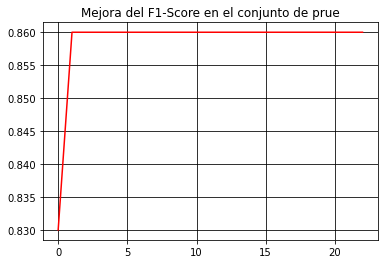

In [16]:
plt.plot(improve,color='red')
plt.grid((50,50),color='black')
plt.title("Mejora del F1-Score en el conjunto de prue")

## Evaluación en el conjunto de prueba

In [8]:
toinfer=torch.load("ViTEstDet2022-03-13BEST.pt",map_location=torch.device('cpu'))
c,d=toinfer.eval_model(test_dl)

In [9]:
print(classification_report(c,d)) #Tenemos un rendimiento bastante bueno del modelo

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.88      0.94        25

    accuracy                           0.92        38
   macro avg       0.91      0.94      0.92        38
weighted avg       0.94      0.92      0.92        38



# Inferencia sobre cualquier imagen de entrada

In [31]:
mascara,logits=toinfer.predict('1.png')

In [32]:
imagen_original=cv2.imread('1.png')
nmask=cv2.resize(logits.astype('float32'),(imagen_original.shape[1],imagen_original.shape[0]))

(-0.5, 1023.5, 511.5, -0.5)

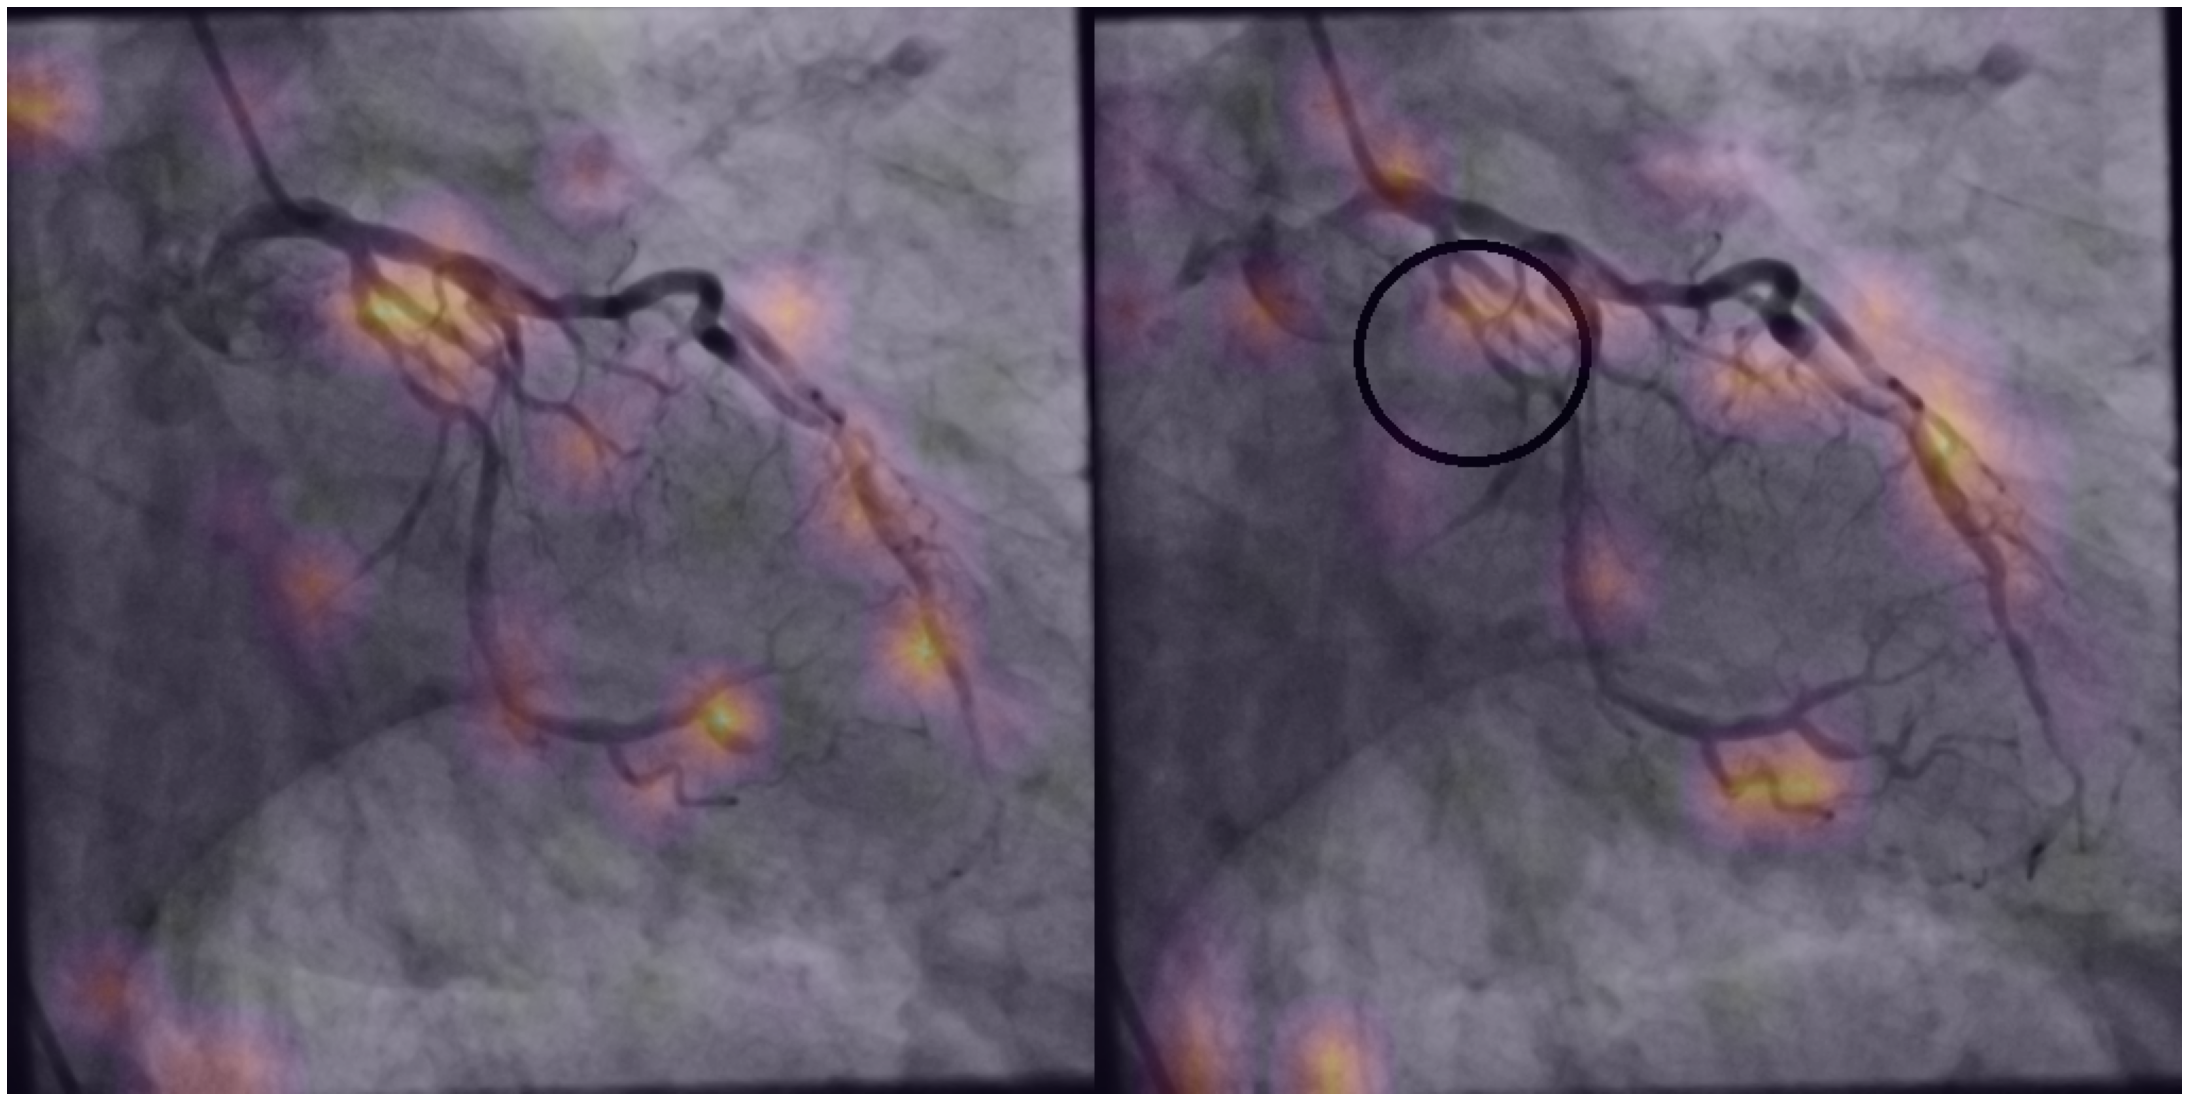

In [33]:
plt.figure(figsize = (50,20))
plt.imshow(imagen_original)
plt.imshow(nmask,alpha=0.3,cmap='inferno')
plt.axis('off')

(-0.5, 1023.5, 511.5, -0.5)

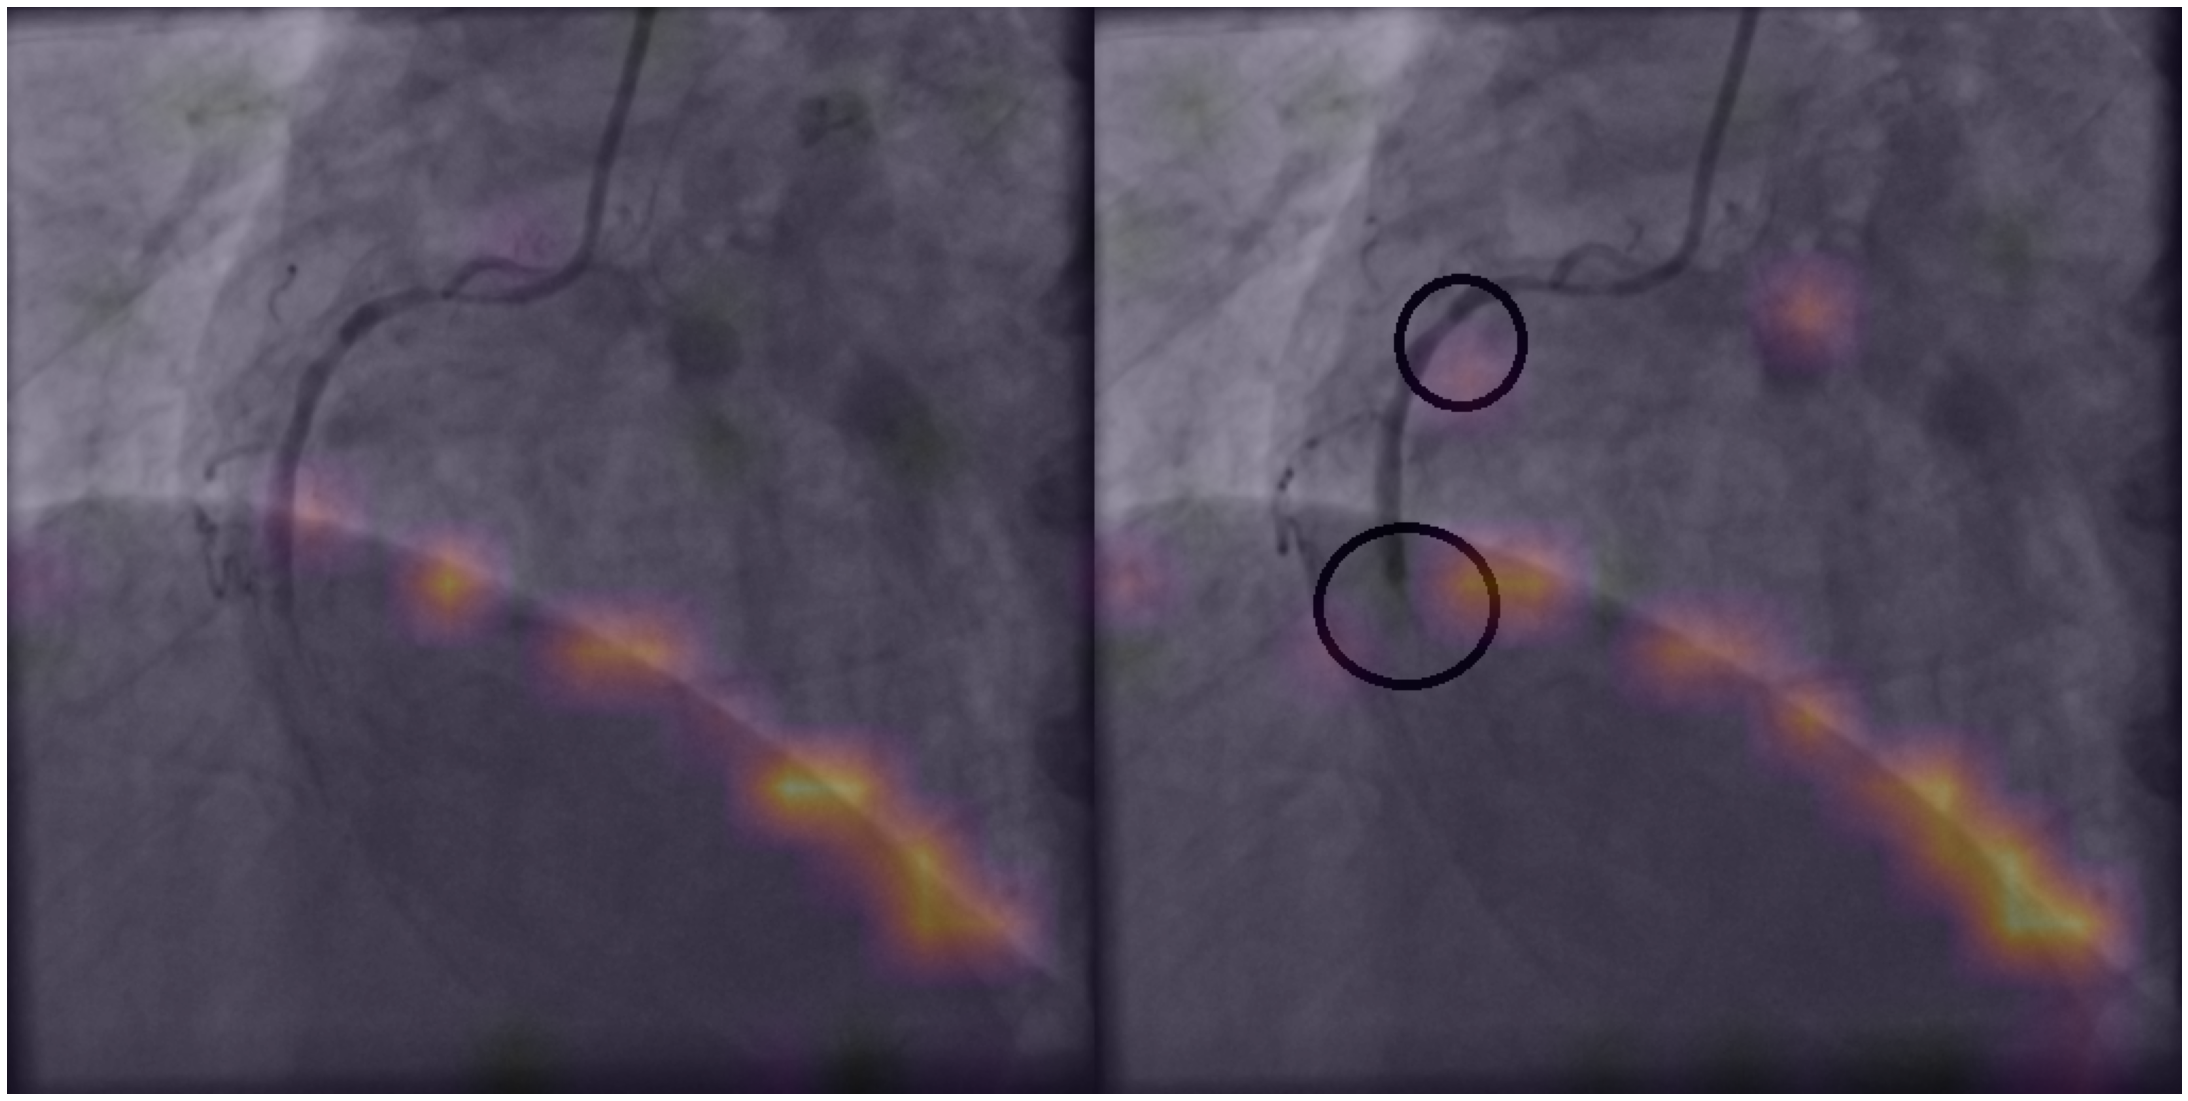

In [34]:
mascara,logits=toinfer.predict('4.png')
imagen_original=cv2.imread('4.png')
nmask=cv2.resize(logits.astype('float32'),(imagen_original.shape[1],imagen_original.shape[0]))
plt.figure(figsize = (50,20))
plt.imshow(imagen_original)
plt.imshow(nmask,alpha=0.3,cmap='inferno')
plt.axis('off')

(-0.5, 1023.5, 511.5, -0.5)

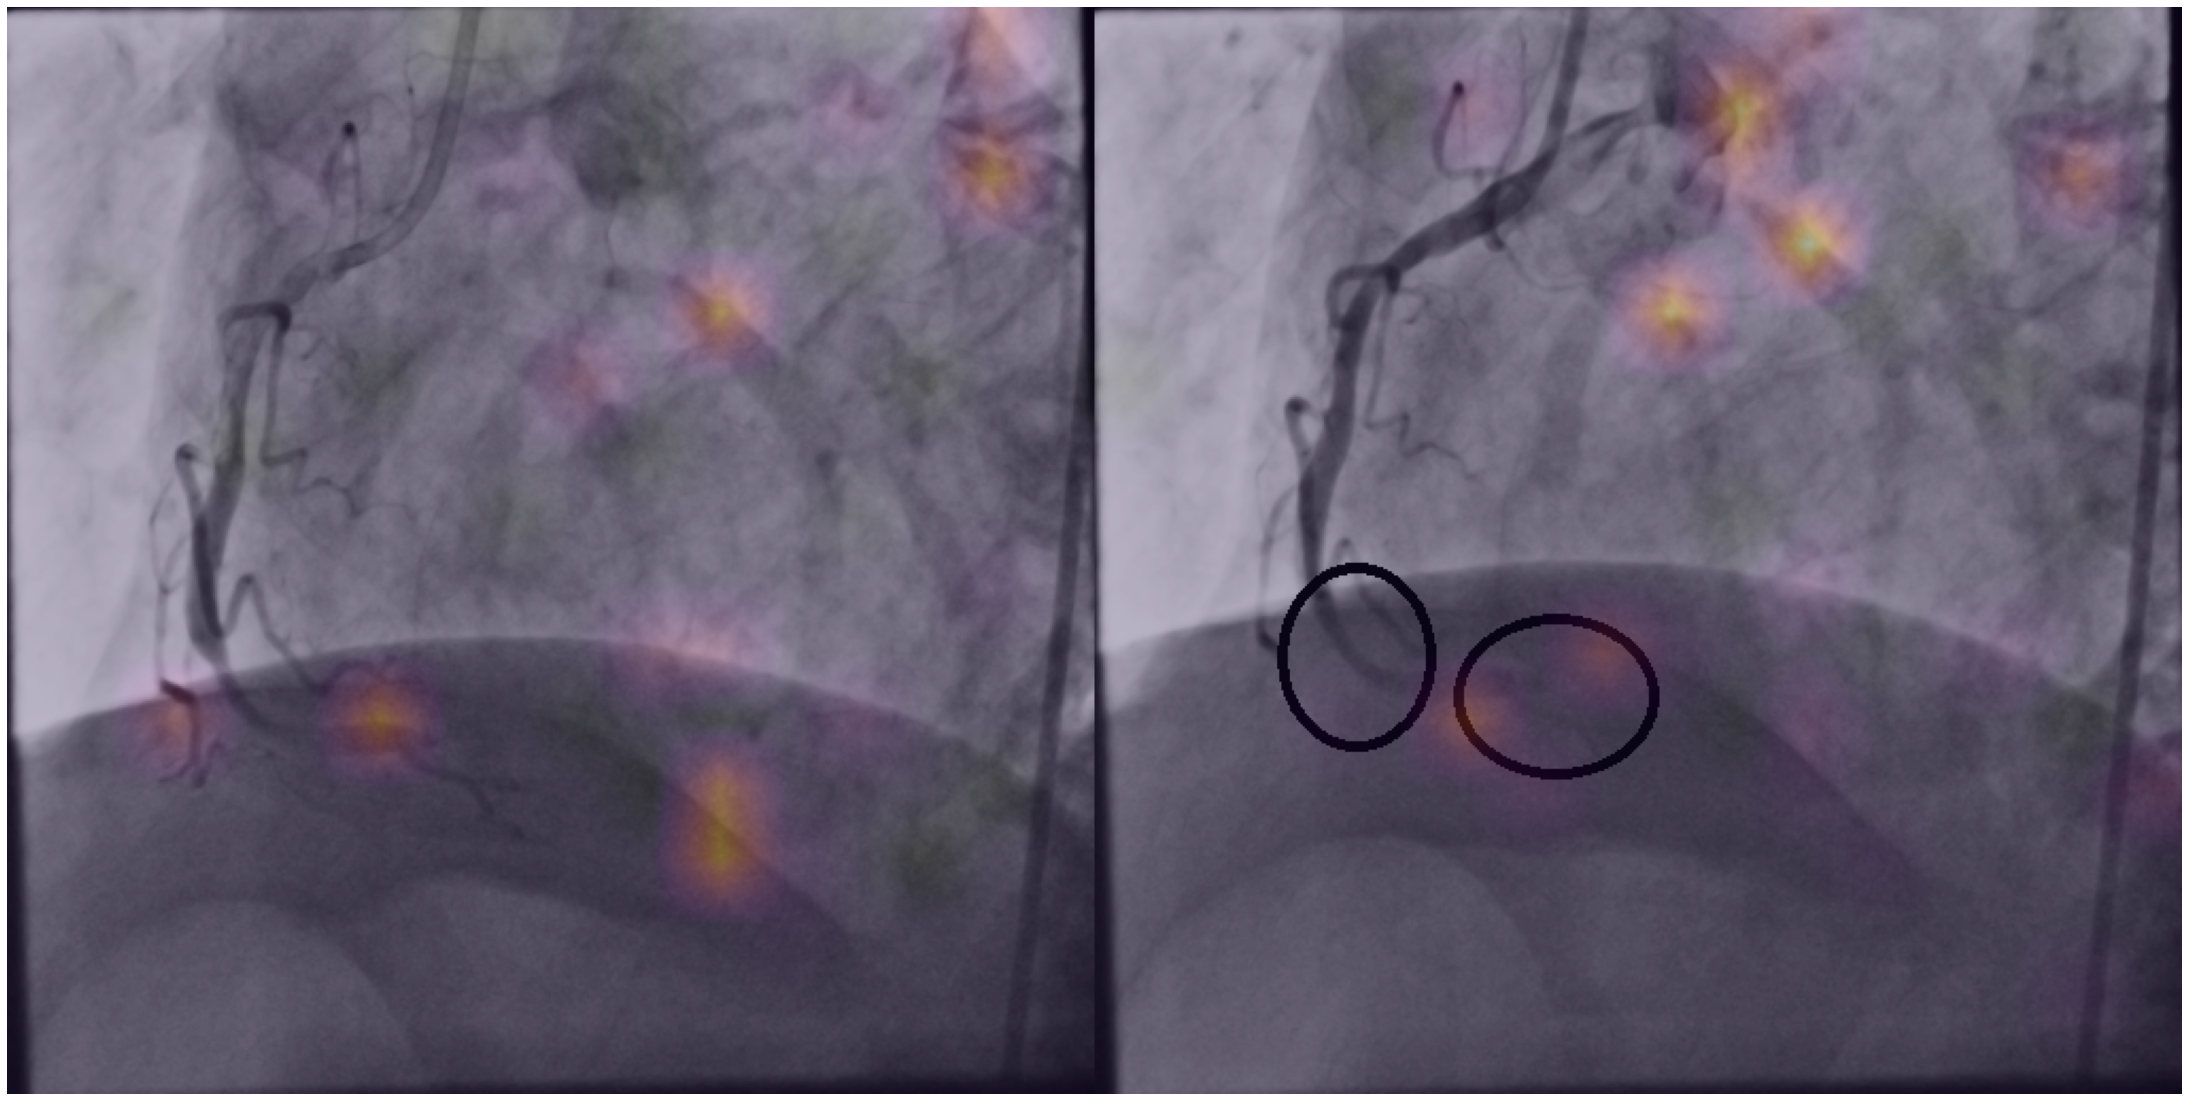

In [35]:
mascara,logits=toinfer.predict('2.png')
imagen_original=cv2.imread('2.png')
nmask=cv2.resize(logits.astype('float32'),(imagen_original.shape[1],imagen_original.shape[0]))
plt.figure(figsize = (50,20))
plt.imshow(imagen_original)
plt.imshow(nmask,alpha=0.3,cmap='inferno')
plt.axis('off')